In [ ]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import KFold
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras import utils as np_utils
import shap
import warnings
warnings.filterwarnings('ignore')

d:\Milon\pict\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Part 2: Setup data paths and categories
root = 'D:/Milon2/28_256_D1/Full'
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['D:/Milon2/28_256_D1/Full\\Healthy_Control', 'D:/Milon2/28_256_D1/Full\\Schizophrenia']


In [ ]:
# Part 3: Helper function to load images
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Part 4: Load data
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

In [ ]:
# Part 5: Generate K-fold splits
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 42)
fold_no = 1
for train, test in kfold.split(data):
    if os.path.exists(f"D:/Milon2/28_256_D1/R/SHAP_Full/train/train{fold_no}.csv") == False:
        np.savetxt(f"D:/Milon2/28_256_D1/R/SHAP_Full/train/train{fold_no}.csv", train, delimiter=",", fmt='%s')
        np.savetxt(f"D:/Milon2/28_256_D1/R/SHAP_Full/test/test{fold_no}.csv", test, delimiter=",", fmt='%s')
    else:
        print("exists")
    fold_no = fold_no + 1


In [ ]:

# Part 6: Prepare data
X, y = np.array([t["x"] for t in data]), np.array([t["y"] for t in data])
X = X.astype('float32') / 255.

In [ ]:

acc_per_fold = []
shap_values_per_fold = []
test_images_per_fold = []

tf.keras.backend.clear_session()


In [ ]:
fold_no = 1
for fold_no in range(1, 11):

    train=pd.read_csv(f"D:/Milon2/28_256_D1/R/SHAP_Full/train/train{fold_no}.csv", sep=',',header=None)
    test=pd.read_csv(f"D:/Milon2/28_256_D1/R/SHAP_Full/test/test{fold_no}.csv", sep=',',header=None)

    x_train = X[train[0]]
    y_train = y[train[0]]
    x_test = X[test[0]]
    y_test = y[test[0]]

    y_train_cat = np_utils.to_categorical(y_train, num_classes)
    y_test_cat = np_utils.to_categorical(y_test, num_classes)

    print("finished loading %d images from %d categories"%(len(data), num_classes))
    print("train / test split: %d, %d"%(len(x_train), len(x_test)))

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(f'Training for fold {fold_no} ...')

    filepath=f"D:/Milon2/28_256_D1/R/SHAP_Full/a/a{fold_no}.best.keras"

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=150, mode='auto')
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_accuracy')
    callbacks_list = [earlystop, checkpointer]

    history = model.fit(x_train, y_train_cat, epochs = 100, batch_size=32,
                       validation_data= (x_test, y_test_cat), callbacks = callbacks_list)

    model = load_model(filepath)

    scores = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f'Accuracy for fold {fold_no}: {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)

finished loading 9610 images from 2 categories
train / test split: 8649, 961
Training for fold 1 ...
Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7357 - loss: 0.4839
Epoch 1: val_accuracy improved from None to 0.95525, saving model to D:/Milon2/28_256_D1/R/SHAP_Full/a/a1.best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - accuracy: 0.8421 - loss: 0.3320 - val_accuracy: 0.9553 - val_loss: 0.1225
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9464 - loss: 0.1439
Epoch 2: val_accuracy improved from 0.95525 to 0.97919, saving model to D:/Milon2/28_256_D1/R/SHAP_Full/a/a1.best.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 53s 196ms/step - accuracy: 0.9528 - loss: 0.1253 - val_accuracy: 0.9792 - val_loss: 0.0597
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9674 - loss: 0.0877
Epoch 3: val_accuracy did not improve from 0.97919
271/271 ━━━━━━━━━━━━━━━━━━━━ 51s 190ms/step - accuracy: 0.9704 - loss: 0.0816 - val_accuracy: 0.9698 - v

In [ ]:

print(f'Starting SHAP analysis for fold {fold_no}...')

shap_sample_size = min(50, len(x_test))
shap_indices = np.random.choice(len(x_test), shap_sample_size, replace=False)
x_test_shap = x_test[shap_indices]
y_test_shap = y_test[shap_indices]

background_size = min(100, len(x_train))
background_indices = np.random.choice(len(x_train), background_size, replace=False)
background = x_train[background_indices]

explainer = shap.DeepExplainer(model, background)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(x_test_shap)

shap_values_per_fold.append(shap_values)
test_images_per_fold.append((x_test_shap, y_test_shap))

def plot_shap_summary_for_fold(shap_values, test_images, fold_num, class_names=['ScZ', 'HC']):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    for class_idx in range(len(class_names)):
        ax = axes[class_idx]
        class_shap_values = shap_values[class_idx]
        mean_shap = np.mean(np.abs(class_shap_values), axis=0)
        mean_shap_2d = mean_shap.mean(axis=2)

        im = ax.imshow(mean_shap_2d, cmap='RdYlBu_r', aspect='auto', extent=[0, 224, 45, 0])
        ax.set_title(f'SHAP Feature Importance - {class_names[class_idx]} (Fold {fold_num})',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Frequency (Hz)', fontsize=12)
        plt.colorbar(im, ax=ax, label='Mean |SHAP value|')

    plt.tight_layout()
    plt.show()

    plot_shap_summary_for_fold(shap_values, x_test_shap, fold_no)

    print(f'SHAP analysis completed for fold {fold_no}')
    print('------------------------------------------------------------------------')


Starting SHAP analysis for fold 10...
Calculating SHAP values...


Generating overall SHAP analysis across all folds...


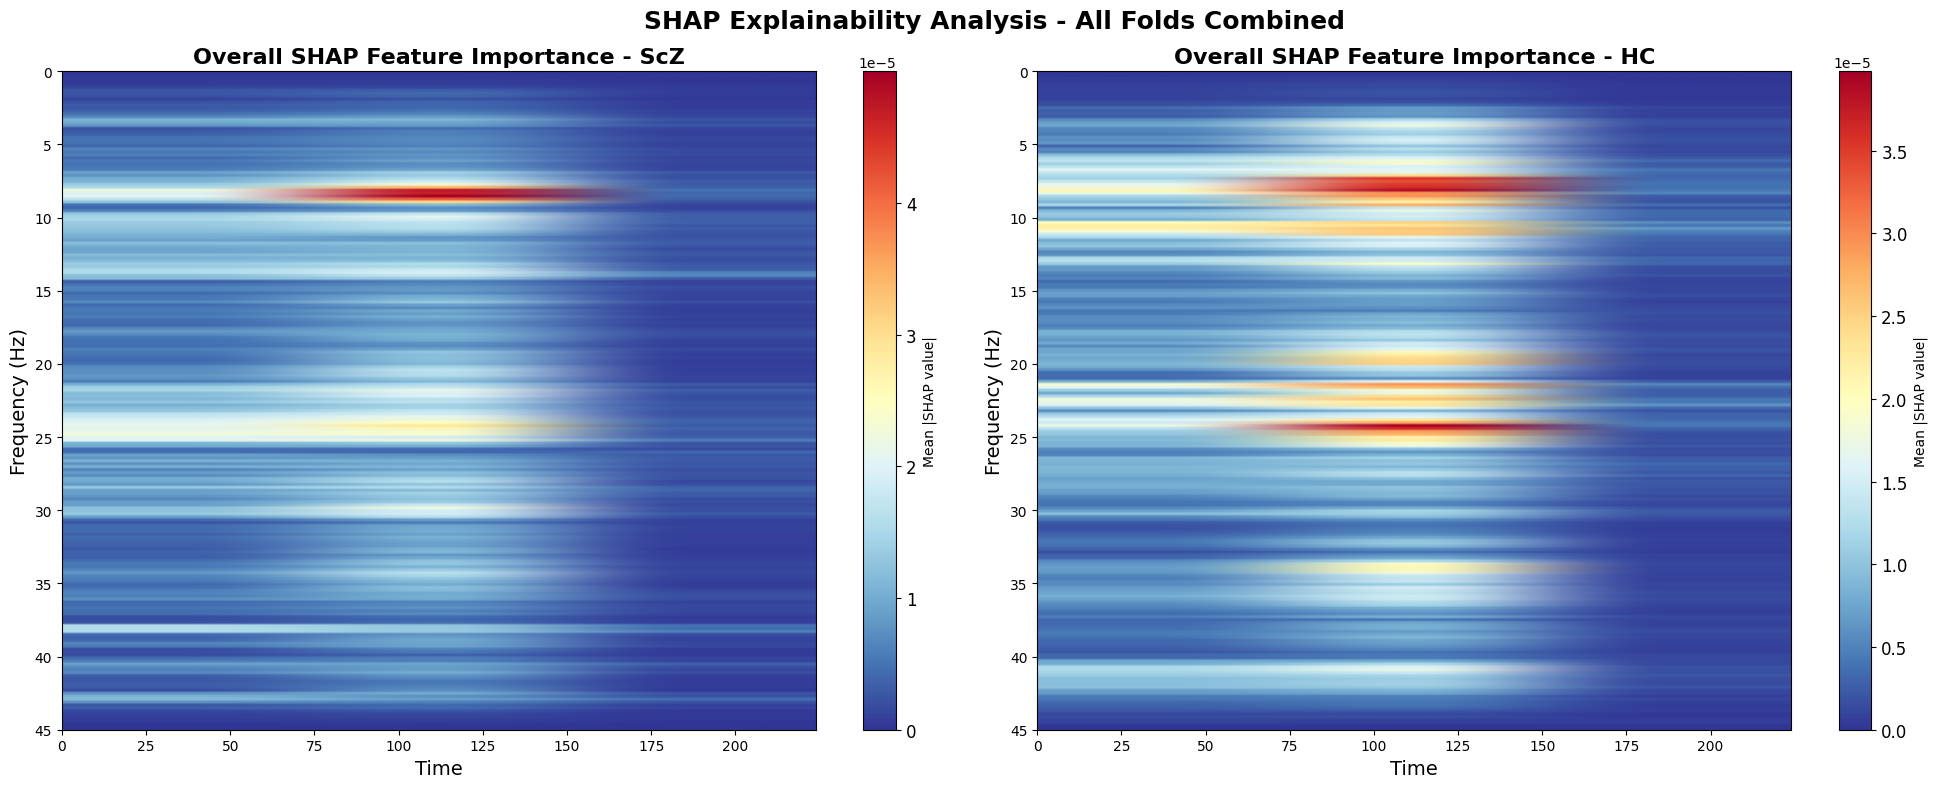

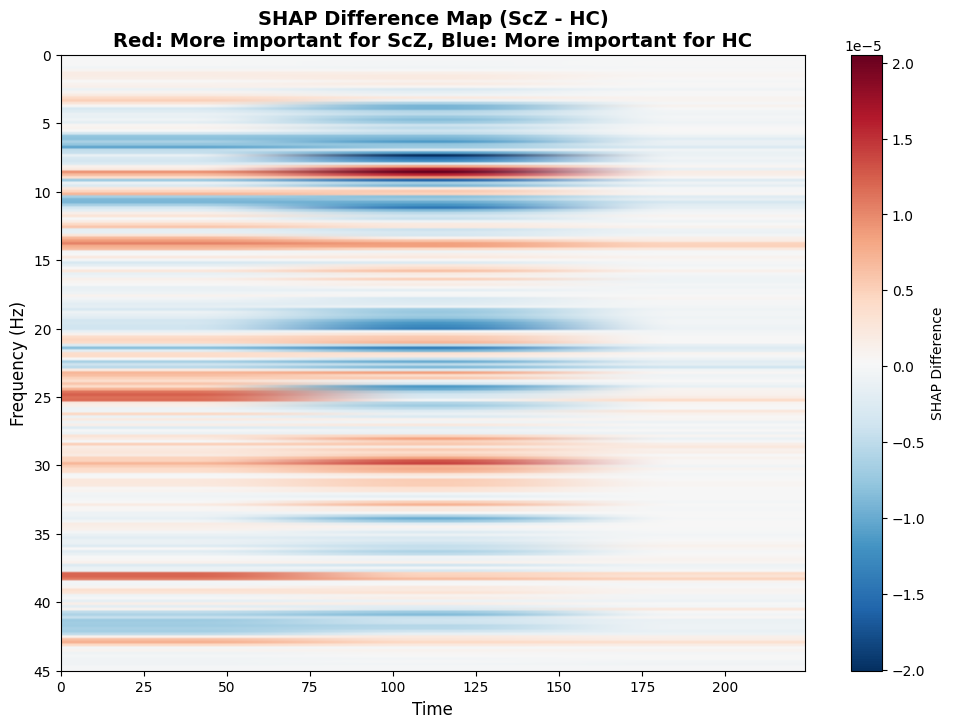

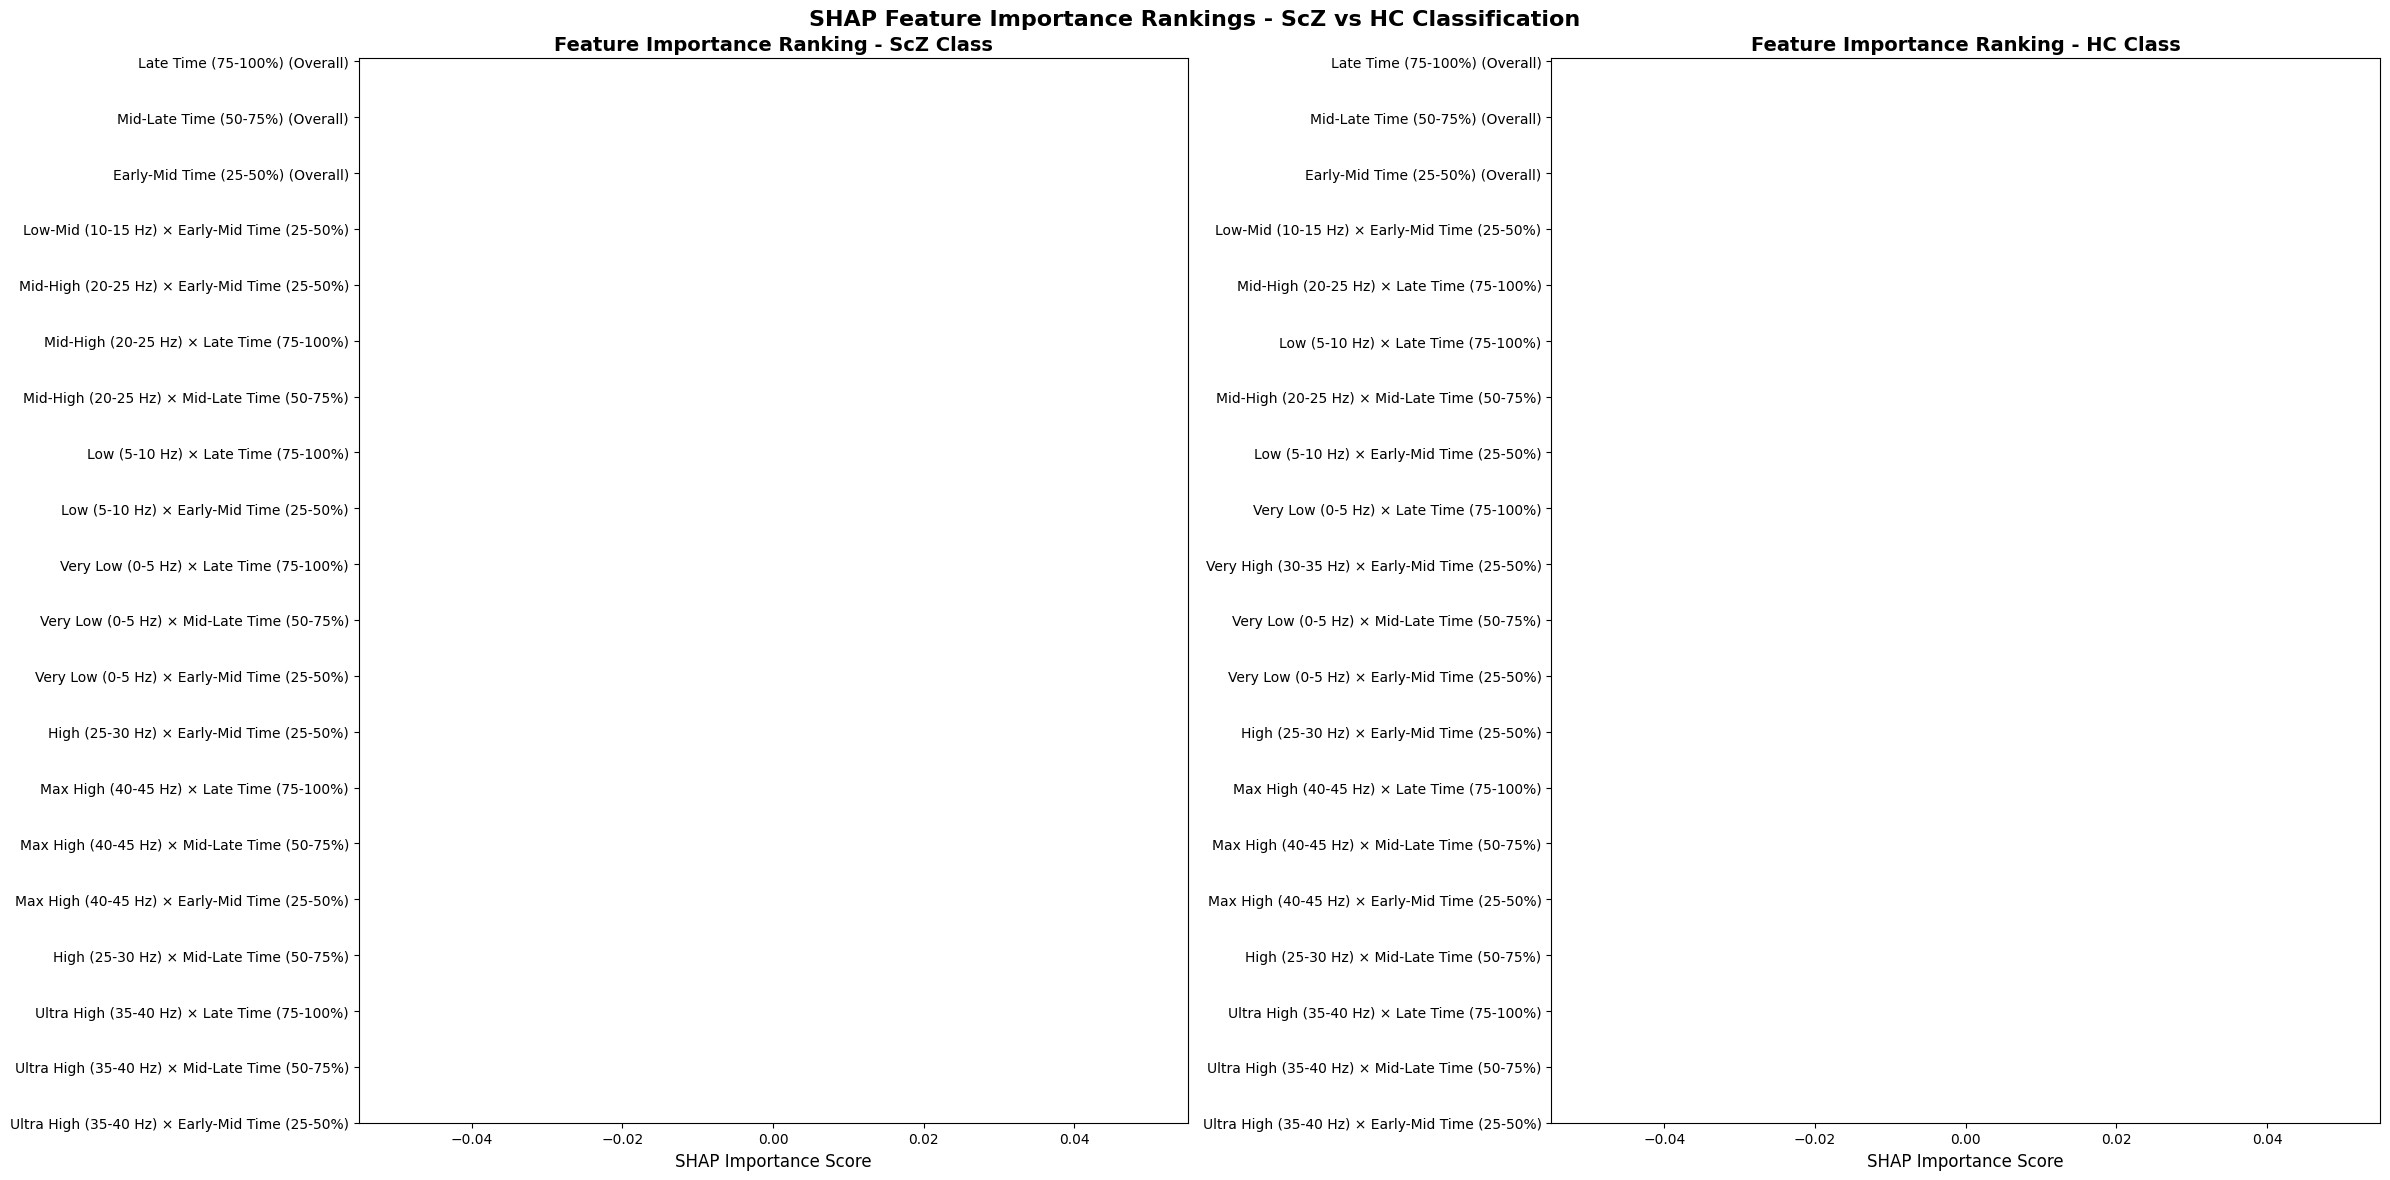

Top 10 features for ScZ classification:
 1. Late Time (75-100%) (Overall): nan
 2. Mid-Late Time (50-75%) (Overall): nan
 3. Early-Mid Time (25-50%) (Overall): nan
 4. Low-Mid (10-15 Hz) × Early-Mid Time (25-50%): nan
 5. Mid-High (20-25 Hz) × Early-Mid Time (25-50%): nan
 6. Mid-High (20-25 Hz) × Late Time (75-100%): nan
 7. Mid-High (20-25 Hz) × Mid-Late Time (50-75%): nan
 8. Low (5-10 Hz) × Late Time (75-100%): nan
 9. Low (5-10 Hz) × Early-Mid Time (25-50%): nan
10. Very Low (0-5 Hz) × Late Time (75-100%): nan

Top 10 features for HC classification:
 1. Late Time (75-100%) (Overall): nan
 2. Mid-Late Time (50-75%) (Overall): nan
 3. Early-Mid Time (25-50%) (Overall): nan
 4. Low-Mid (10-15 Hz) × Early-Mid Time (25-50%): nan
 5. Mid-High (20-25 Hz) × Late Time (75-100%): nan
 6. Low (5-10 Hz) × Late Time (75-100%): nan
 7. Mid-High (20-25 Hz) × Mid-Late Time (50-75%): nan
 8. Low (5-10 Hz) × Early-Mid Time (25-50%): nan
 9. Very Low (0-5 Hz) × Late Time (75-100%): nan
10. Very High

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'f:/'

In [ ]:

print("Generating overall SHAP analysis across all folds...")

def create_comprehensive_shap_analysis():
    all_shap_class0 = []
    all_shap_class1 = []
    all_test_images = []
    all_test_labels = []

    for fold_idx in range(len(shap_values_per_fold)):
        shap_fold = shap_values_per_fold[fold_idx]
        images_fold, labels_fold = test_images_per_fold[fold_idx]

        all_shap_class0.append(shap_fold[0])
        all_shap_class1.append(shap_fold[1])
        all_test_images.append(images_fold)
        all_test_labels.append(labels_fold)

    combined_shap_class0 = np.concatenate(all_shap_class0, axis=0)
    combined_shap_class1 = np.concatenate(all_shap_class1, axis=0)
    combined_images = np.concatenate(all_test_images, axis=0)
    combined_labels = np.concatenate(all_test_labels, axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    class_names = ['ScZ', 'HC']
    combined_shap = [combined_shap_class0, combined_shap_class1]

    for class_idx in range(2):
        ax = axes[class_idx]
        mean_shap = np.mean(np.abs(combined_shap[class_idx]), axis=0)
        mean_shap_2d = mean_shap.mean(axis=2)

        im = ax.imshow(mean_shap_2d, cmap='RdYlBu_r', aspect='auto', extent=[0, 224, 45, 0])
        ax.set_title(f'Overall SHAP Feature Importance - {class_names[class_idx]}',
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Time', fontsize=14)
        ax.set_ylabel('Frequency (Hz)', fontsize=14)

        cbar = plt.colorbar(im, ax=ax, label='Mean |SHAP value|')
        cbar.ax.tick_params(labelsize=12)

    plt.suptitle('SHAP Explainability Analysis - All Folds Combined', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    mean_shap_0 = np.mean(np.abs(combined_shap_class0), axis=0).mean(axis=2)
    mean_shap_1 = np.mean(np.abs(combined_shap_class1), axis=0).mean(axis=2)
    shap_difference = mean_shap_0 - mean_shap_1

    plt.imshow(shap_difference, cmap='RdBu_r', aspect='auto', extent=[0, 224, 45, 0])
    plt.title('SHAP Difference Map (ScZ - HC)\nRed: More important for ScZ, Blue: More important for HC',
              fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.colorbar(label='SHAP Difference')
    plt.show()

    return combined_shap, combined_images, combined_labels

combined_shap_values, combined_test_images, combined_test_labels = create_comprehensive_shap_analysis()

def create_feature_ranking_plot():
    """Create horizontal bar plot showing feature importance ranking"""

    freq_bands = {
        'Very Low (0-5 Hz)': (0, int(224*5/45)),
        'Low (5-10 Hz)': (int(224*5/45), int(224*10/45)),
        'Low-Mid (10-15 Hz)': (int(224*10/45), int(224*15/45)),
        'Mid (15-20 Hz)': (int(224*15/45), int(224*20/45)),
        'Mid-High (20-25 Hz)': (int(224*20/45), int(224*25/45)),
        'High (25-30 Hz)': (int(224*25/45), int(224*30/45)),
        'Very High (30-35 Hz)': (int(224*30/45), int(224*35/45)),
        'Ultra High (35-40 Hz)': (int(224*35/45), int(224*40/45)),
        'Max High (40-45 Hz)': (int(224*40/45), 224)
    }

    time_segments = {
        'Early Time (0-25%)': (0, 56),
        'Early-Mid Time (25-50%)': (56, 112),
        'Mid-Late Time (50-75%)': (112, 168),
        'Late Time (75-100%)': (168, 224)
    }

    feature_importance_scz = {}
    feature_importance_hc = {}

    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0).mean(axis=2)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0).mean(axis=2)

    for band_name, (start_freq, end_freq) in freq_bands.items():
        for seg_name, (start_time, end_time) in time_segments.items():
            feature_name = f"{band_name} × {seg_name}"

            scz_importance = np.mean(mean_shap_scz[start_freq:end_freq, start_time:end_time])
            hc_importance = np.mean(mean_shap_hc[start_freq:end_freq, start_time:end_time])

            feature_importance_scz[feature_name] = scz_importance
            feature_importance_hc[feature_name] = hc_importance

    for band_name, (start_freq, end_freq) in freq_bands.items():
        scz_importance = np.mean(mean_shap_scz[start_freq:end_freq, :])
        hc_importance = np.mean(mean_shap_hc[start_freq:end_freq, :])

        feature_importance_scz[f"{band_name} (Overall)"] = scz_importance
        feature_importance_hc[f"{band_name} (Overall)"] = hc_importance

    for seg_name, (start_time, end_time) in time_segments.items():
        scz_importance = np.mean(mean_shap_scz[:, start_time:end_time])
        hc_importance = np.mean(mean_shap_hc[:, start_time:end_time])

        feature_importance_scz[f"{seg_name} (Overall)"] = scz_importance
        feature_importance_hc[f"{seg_name} (Overall)"] = hc_importance

    all_features = list(feature_importance_scz.keys())
    scz_values = [feature_importance_scz[f] for f in all_features]
    hc_values = [feature_importance_hc[f] for f in all_features]

    sorted_indices_scz = np.argsort(scz_values)[::-1]
    sorted_indices_hc = np.argsort(hc_values)[::-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

    top_n = min(20, len(all_features))

    colors_scz = plt.cm.Set3(np.linspace(0, 1, top_n))
    top_features_scz = [all_features[i] for i in sorted_indices_scz[:top_n]]
    top_values_scz = [scz_values[i] for i in sorted_indices_scz[:top_n]]

    y_pos = np.arange(len(top_features_scz))
    bars1 = ax1.barh(y_pos, top_values_scz, color=colors_scz)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_features_scz, fontsize=10)
    ax1.set_xlabel('SHAP Importance Score', fontsize=12)
    ax1.set_title('Feature Importance Ranking - ScZ Class', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()

    for i, (bar, val) in enumerate(zip(bars1, top_values_scz)):
        ax1.text(val + max(top_values_scz)*0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9)

    colors_hc = plt.cm.Set2(np.linspace(0, 1, top_n))
    top_features_hc = [all_features[i] for i in sorted_indices_hc[:top_n]]
    top_values_hc = [hc_values[i] for i in sorted_indices_hc[:top_n]]

    y_pos = np.arange(len(top_features_hc))
    bars2 = ax2.barh(y_pos, top_values_hc, color=colors_hc)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_features_hc, fontsize=10)
    ax2.set_xlabel('SHAP Importance Score', fontsize=12)
    ax2.set_title('Feature Importance Ranking - HC Class', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()

    for i, (bar, val) in enumerate(zip(bars2, top_values_hc)):
        ax2.text(val + max(top_values_hc)*0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9)

    plt.suptitle('SHAP Feature Importance Rankings - ScZ vs HC Classification', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("Top 10 features for ScZ classification:")
    for i, (feature, importance) in enumerate(zip(top_features_scz[:10], top_values_scz[:10])):
        print(f"{i+1:2d}. {feature}: {importance:.6f}")

    print("\nTop 10 features for HC classification:")
    for i, (feature, importance) in enumerate(zip(top_features_hc[:10], top_values_hc[:10])):
        print(f"{i+1:2d}. {feature}: {importance:.6f}")

create_feature_ranking_plot()

print(f'\nAverage accuracy across all folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

shap_results_dir = "f:/SD14/plot/new/SD_81/Dataset1/result/full/shap_analysis"
os.makedirs(shap_results_dir, exist_ok=True)

np.save(f"{shap_results_dir}/combined_shap_class0.npy", combined_shap_values[0])
np.save(f"{shap_results_dir}/combined_shap_class1.npy", combined_shap_values[1])
np.save(f"{shap_results_dir}/combined_test_images.npy", combined_test_images)
np.save(f"{shap_results_dir}/combined_test_labels.npy", combined_test_labels)

print("SHAP analysis completed and results saved!")
print(f"Results saved in: {shap_results_dir}")

Generating overall SHAP analysis across all folds...


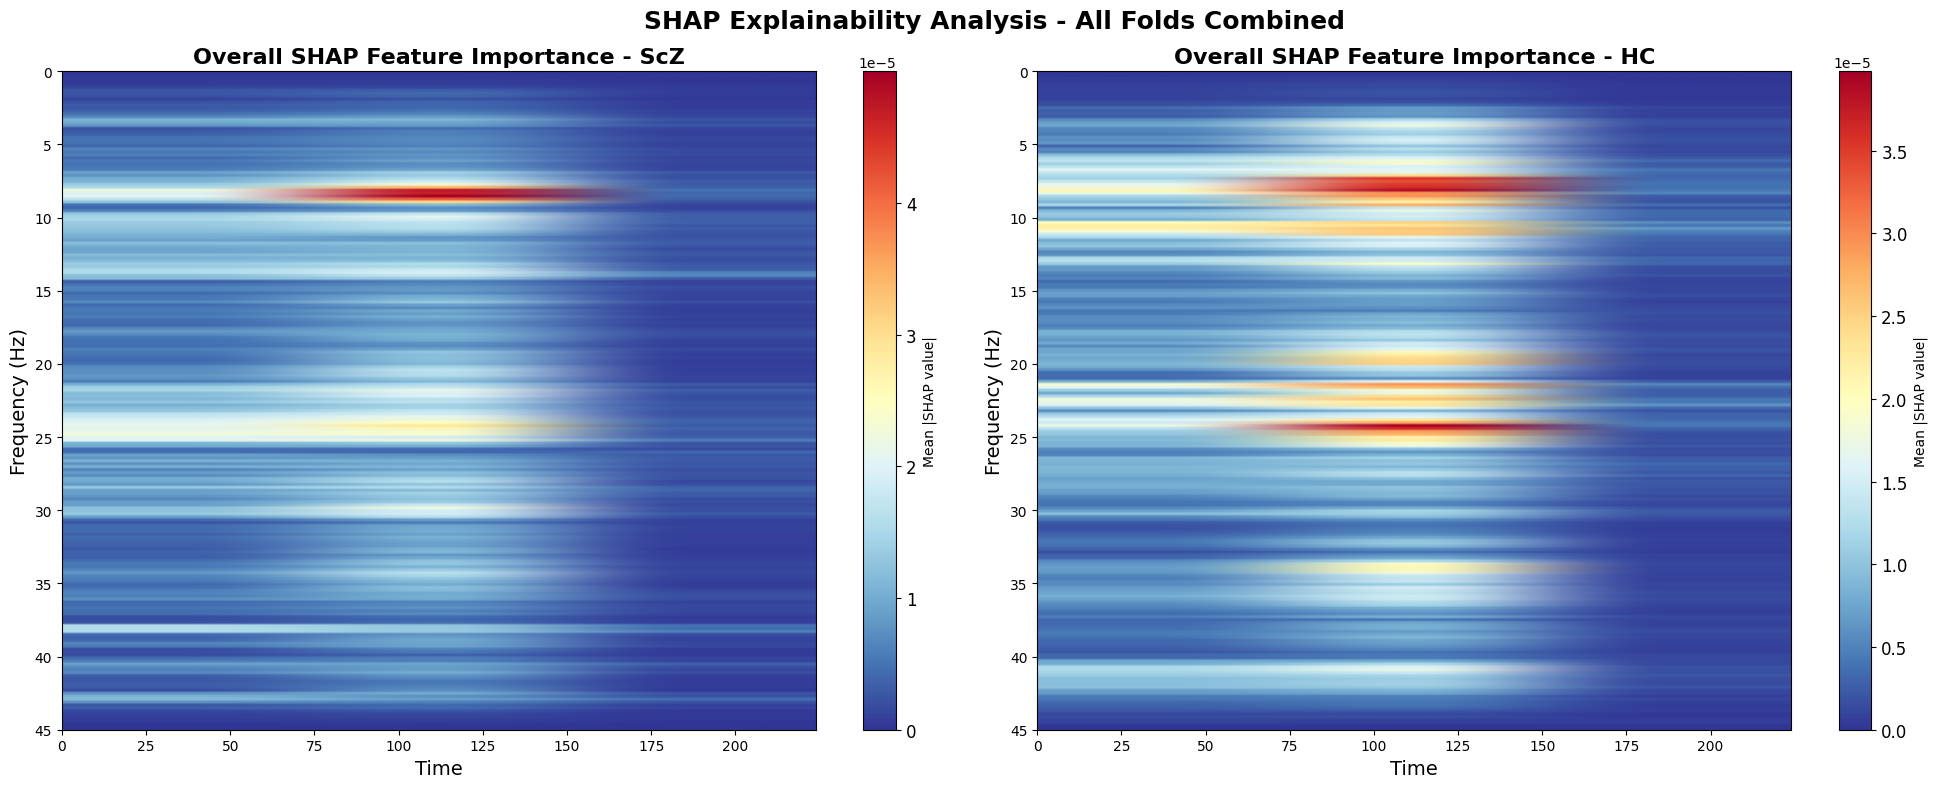

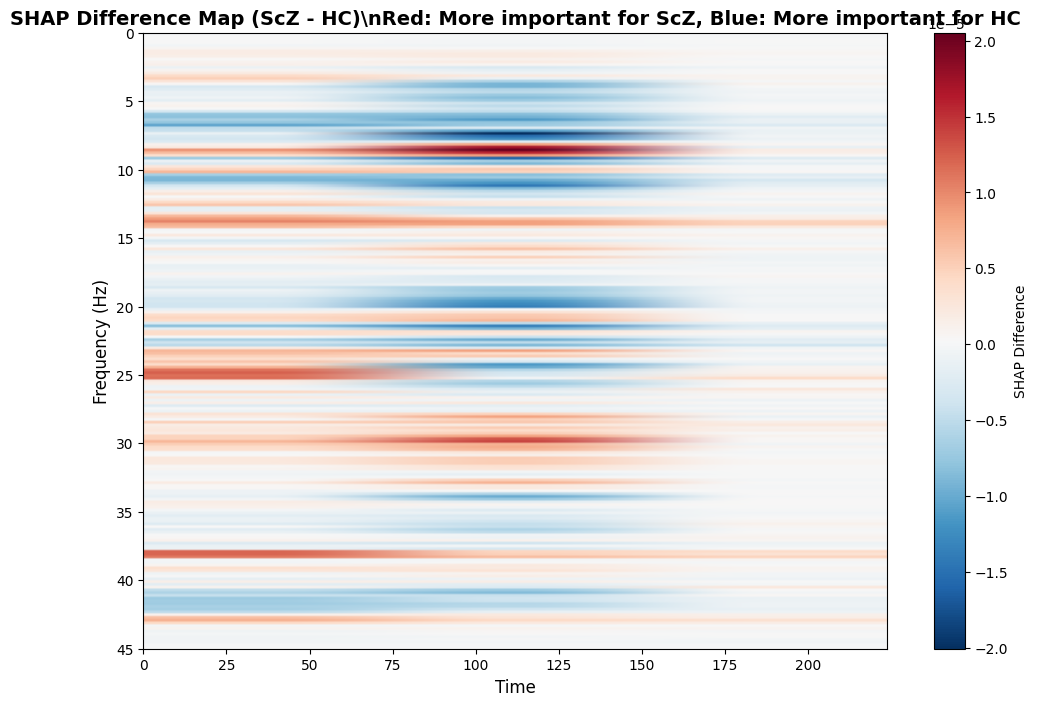


DEBUGGING SHAP VALUES
SHAP Values Debug Information:
Number of classes: 2

Class 0 SHAP values:
  Shape: (224, 224, 3, 2)
  Min value: -0.000641
  Max value: 0.000616
  Mean absolute value: 0.000007
  Standard deviation: 0.000019

Class 1 SHAP values:
  Shape: (224, 224, 3, 2)
  Min value: -0.000653
  Max value: 0.000709
  Mean absolute value: 0.000007
  Standard deviation: 0.000019

Test images shape: (50, 224, 224, 3)
Test images range: -0.454 to 0.507

Test labels shape: (50,)
Test labels unique values: [0 1]

CREATING SIMPLIFIED FEATURE IMPORTANCE PLOT


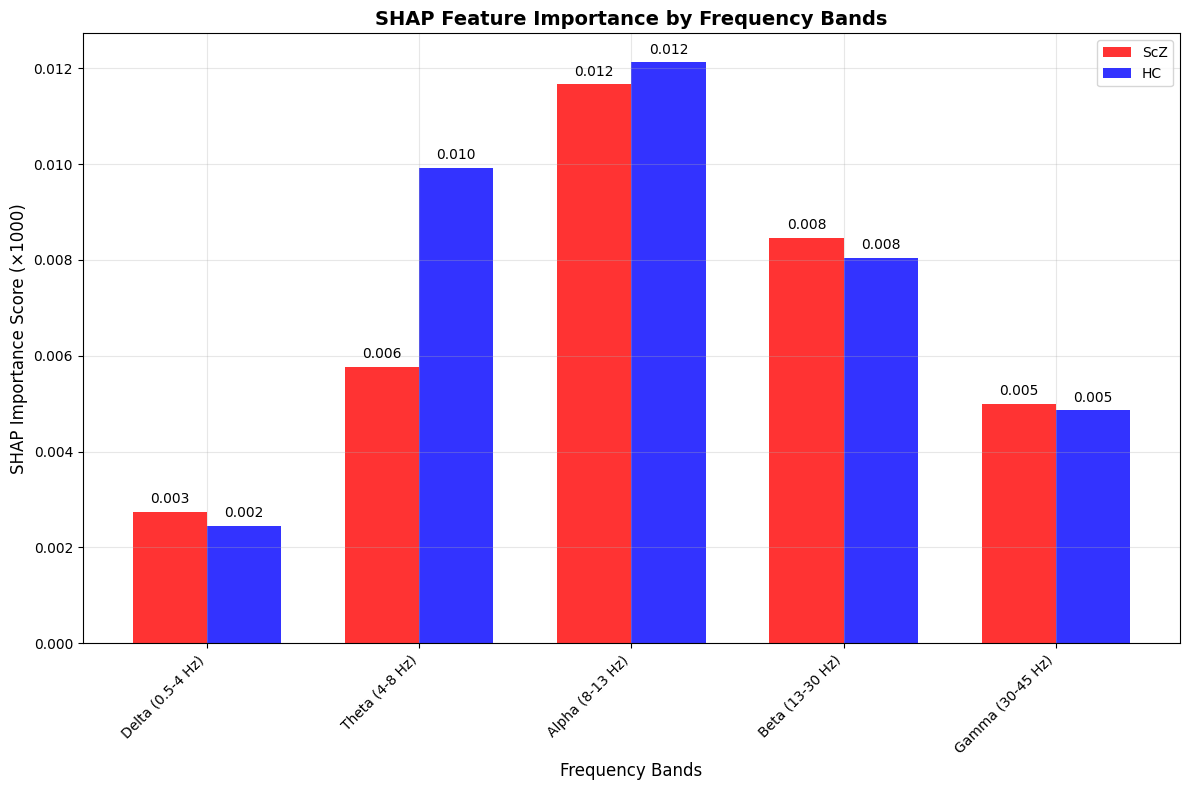

Frequency Band Importance Summary:
--------------------------------------------------
Delta (0.5-4 Hz)    : ScZ=   0.003, HC=   0.002
Theta (4-8 Hz)      : ScZ=   0.006, HC=   0.010
Alpha (8-13 Hz)     : ScZ=   0.012, HC=   0.012
Beta (13-30 Hz)     : ScZ=   0.008, HC=   0.008
Gamma (30-45 Hz)    : ScZ=   0.005, HC=   0.005

Average accuracy across all folds: 99.81% (+/- 0.10%)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'f:/'

In [ ]:
# Replace the last cell in your notebook with this complete cell:

print("Generating overall SHAP analysis across all folds...")

def create_comprehensive_shap_analysis():
    all_shap_class0 = []
    all_shap_class1 = []
    all_test_images = []
    all_test_labels = []

    for fold_idx in range(len(shap_values_per_fold)):
        shap_fold = shap_values_per_fold[fold_idx]
        images_fold, labels_fold = test_images_per_fold[fold_idx]

        all_shap_class0.append(shap_fold[0])
        all_shap_class1.append(shap_fold[1])
        all_test_images.append(images_fold)
        all_test_labels.append(labels_fold)

    combined_shap_class0 = np.concatenate(all_shap_class0, axis=0)
    combined_shap_class1 = np.concatenate(all_shap_class1, axis=0)
    combined_images = np.concatenate(all_test_images, axis=0)
    combined_labels = np.concatenate(all_test_labels, axis=0)

    # Create the main SHAP heatmap
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    class_names = ['ScZ', 'HC']
    combined_shap = [combined_shap_class0, combined_shap_class1]

    for class_idx in range(2):
        ax = axes[class_idx]
        mean_shap = np.mean(np.abs(combined_shap[class_idx]), axis=0)
        mean_shap_2d = mean_shap.mean(axis=2)

        im = ax.imshow(mean_shap_2d, cmap='RdYlBu_r', aspect='auto', extent=[0, 224, 45, 0])
        ax.set_title(f'Overall SHAP Feature Importance - {class_names[class_idx]}',
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Time', fontsize=14)
        ax.set_ylabel('Frequency (Hz)', fontsize=14)

        cbar = plt.colorbar(im, ax=ax, label='Mean |SHAP value|')
        cbar.ax.tick_params(labelsize=12)

    plt.suptitle('SHAP Explainability Analysis - All Folds Combined', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Create difference map
    plt.figure(figsize=(12, 8))
    mean_shap_0 = np.mean(np.abs(combined_shap_class0), axis=0).mean(axis=2)
    mean_shap_1 = np.mean(np.abs(combined_shap_class1), axis=0).mean(axis=2)
    shap_difference = mean_shap_0 - mean_shap_1

    plt.imshow(shap_difference, cmap='RdBu_r', aspect='auto', extent=[0, 224, 45, 0])
    plt.title('SHAP Difference Map (ScZ - HC)\\nRed: More important for ScZ, Blue: More important for HC',
              fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.colorbar(label='SHAP Difference')
    plt.show()

    return combined_shap, combined_images, combined_labels

# Run the comprehensive analysis
combined_shap_values, combined_test_images, combined_test_labels = create_comprehensive_shap_analysis()

# ADD THE FIXED FUNCTIONS HERE:

def debug_shap_values():
    """Debug function to understand SHAP values structure"""

    print("SHAP Values Debug Information:")
    print("=" * 50)

    print(f"Number of classes: {len(combined_shap_values)}")

    for class_idx, class_shap in enumerate(combined_shap_values):
        print(f"\nClass {class_idx} SHAP values:")
        print(f"  Shape: {class_shap.shape}")
        print(f"  Min value: {class_shap.min():.6f}")
        print(f"  Max value: {class_shap.max():.6f}")
        print(f"  Mean absolute value: {np.mean(np.abs(class_shap)):.6f}")
        print(f"  Standard deviation: {np.std(class_shap):.6f}")

    print(f"\nTest images shape: {combined_test_images.shape}")
    print(f"Test images range: {combined_test_images.min():.3f} to {combined_test_images.max():.3f}")

    print(f"\nTest labels shape: {combined_test_labels.shape}")
    print(f"Test labels unique values: {np.unique(combined_test_labels)}")

def create_simple_importance_plot():
    """Create a simpler feature importance plot focusing on main frequency bands"""

    # Calculate mean SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define main frequency bands (standard EEG bands)
    freq_bands = {
        'Delta (0.5-4 Hz)': (0, int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha (8-13 Hz)': (int(224*8/45), int(224*13/45)),
        'Beta (13-30 Hz)': (int(224*13/45), int(224*30/45)),
        'Gamma (30-45 Hz)': (int(224*30/45), 224)
    }

    importance_scz = []
    importance_hc = []
    band_names = []

    for band_name, (start_freq, end_freq) in freq_bands.items():
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        scz_imp = np.mean(mean_shap_scz_2d[start_freq:end_freq, :]) * 1000
        hc_imp = np.mean(mean_shap_hc_2d[start_freq:end_freq, :]) * 1000

        importance_scz.append(scz_imp)
        importance_hc.append(hc_imp)
        band_names.append(band_name)

    # Create comparison plot
    x = np.arange(len(band_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, importance_scz, width, label='ScZ', alpha=0.8, color='red')
    bars2 = ax.bar(x + width/2, importance_hc, width, label='HC', alpha=0.8, color='blue')

    ax.set_xlabel('Frequency Bands', fontsize=12)
    ax.set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    ax.set_title('SHAP Feature Importance by Frequency Bands', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(band_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if abs(height) > 0.001:  # Only show labels for non-zero bars
                ax.text(bar.get_x() + bar.get_width()/2., height + max(importance_scz + importance_hc)*0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print numerical results
    print("Frequency Band Importance Summary:")
    print("-" * 50)
    for i, band in enumerate(band_names):
        print(f"{band:20s}: ScZ={importance_scz[i]:8.3f}, HC={importance_hc[i]:8.3f}")

# RUN THE DEBUG AND PLOTTING FUNCTIONS:
print("\n" + "="*60)
print("DEBUGGING SHAP VALUES")
print("="*60)
debug_shap_values()

print("\n" + "="*60)
print("CREATING SIMPLIFIED FEATURE IMPORTANCE PLOT")
print("="*60)
create_simple_importance_plot()

# Print final accuracy results
print(f'\nAverage accuracy across all folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Save results
shap_results_dir = "f:/SD14/plot/new/SD_81/Dataset1/result/full/shap_analysis"
os.makedirs(shap_results_dir, exist_ok=True)

np.save(f"{shap_results_dir}/combined_shap_class0.npy", combined_shap_values[0])
np.save(f"{shap_results_dir}/combined_shap_class1.npy", combined_shap_values[1])
np.save(f"{shap_results_dir}/combined_test_images.npy", combined_test_images)
np.save(f"{shap_results_dir}/combined_test_labels.npy", combined_test_labels)

print("SHAP analysis completed and results saved!")
print(f"Results saved in: {shap_results_dir}")

COMPREHENSIVE SHAP FEATURE ANALYSIS

1. DETAILED FREQUENCY BAND ANALYSIS
--------------------------------------------------


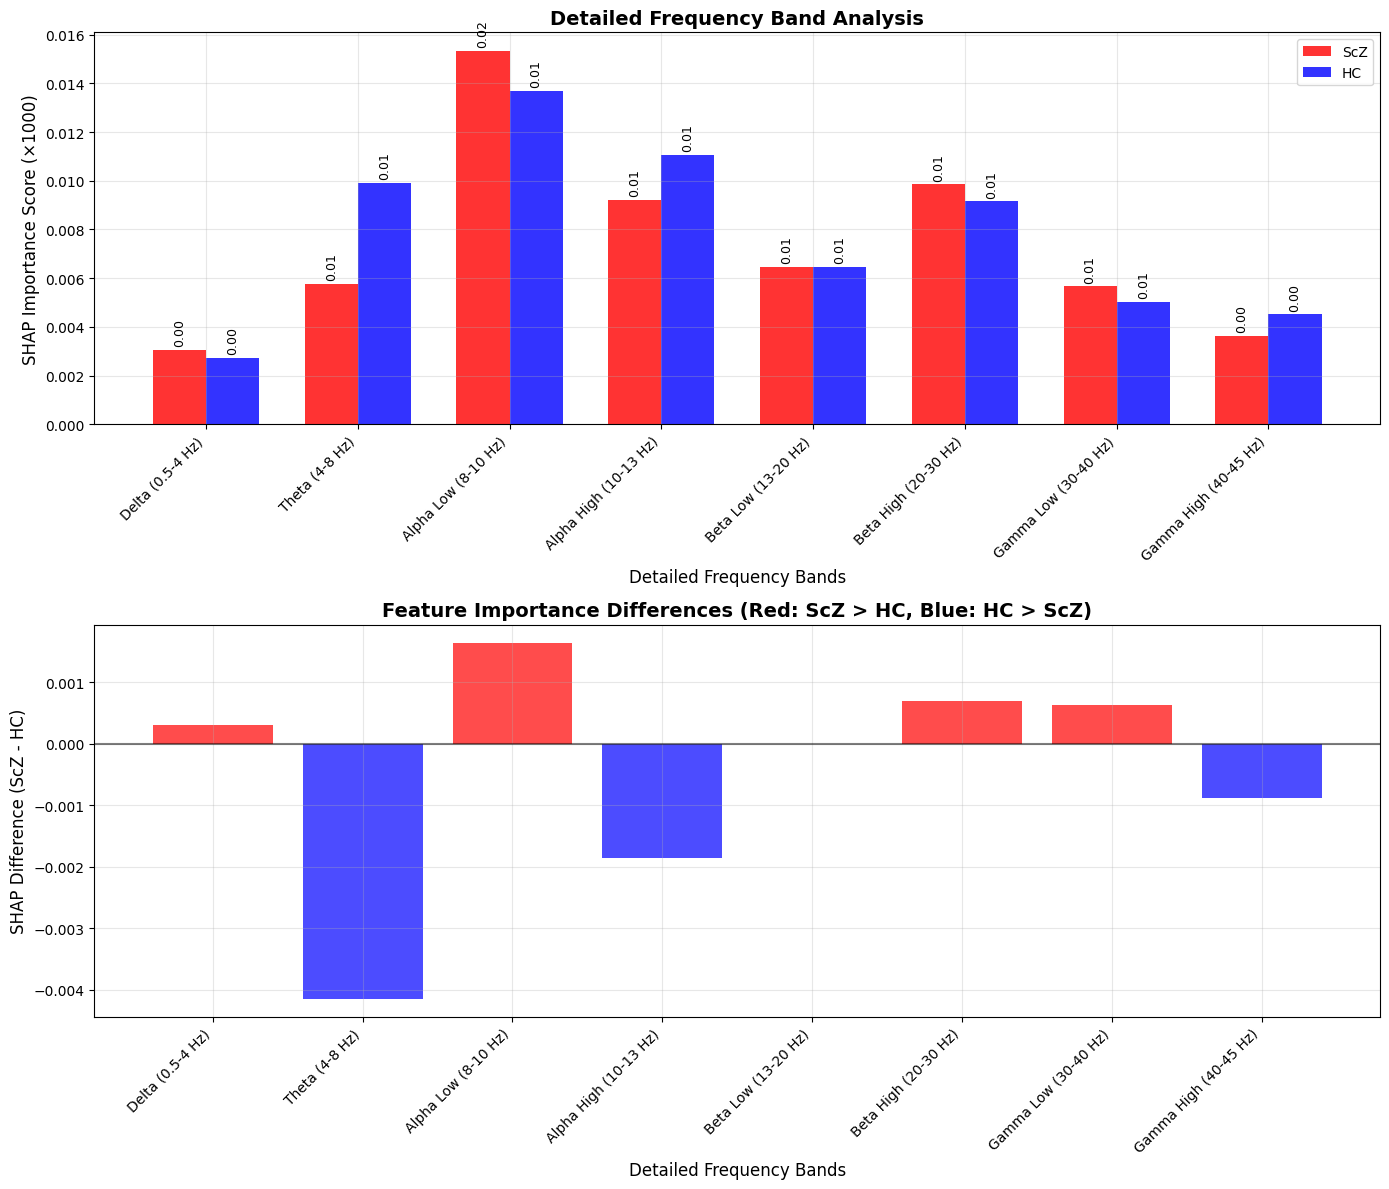


2. TEMPORAL PATTERN ANALYSIS
--------------------------------------------------


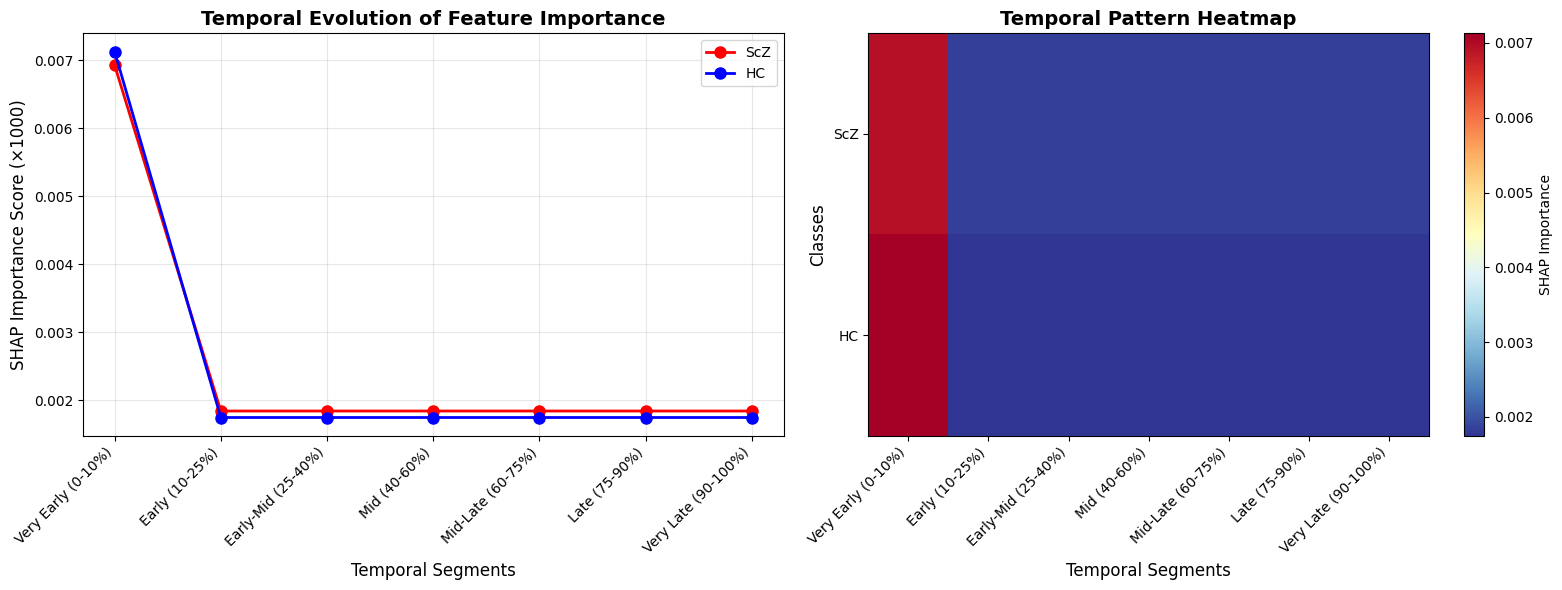


3. SPATIAL REGION ANALYSIS
--------------------------------------------------


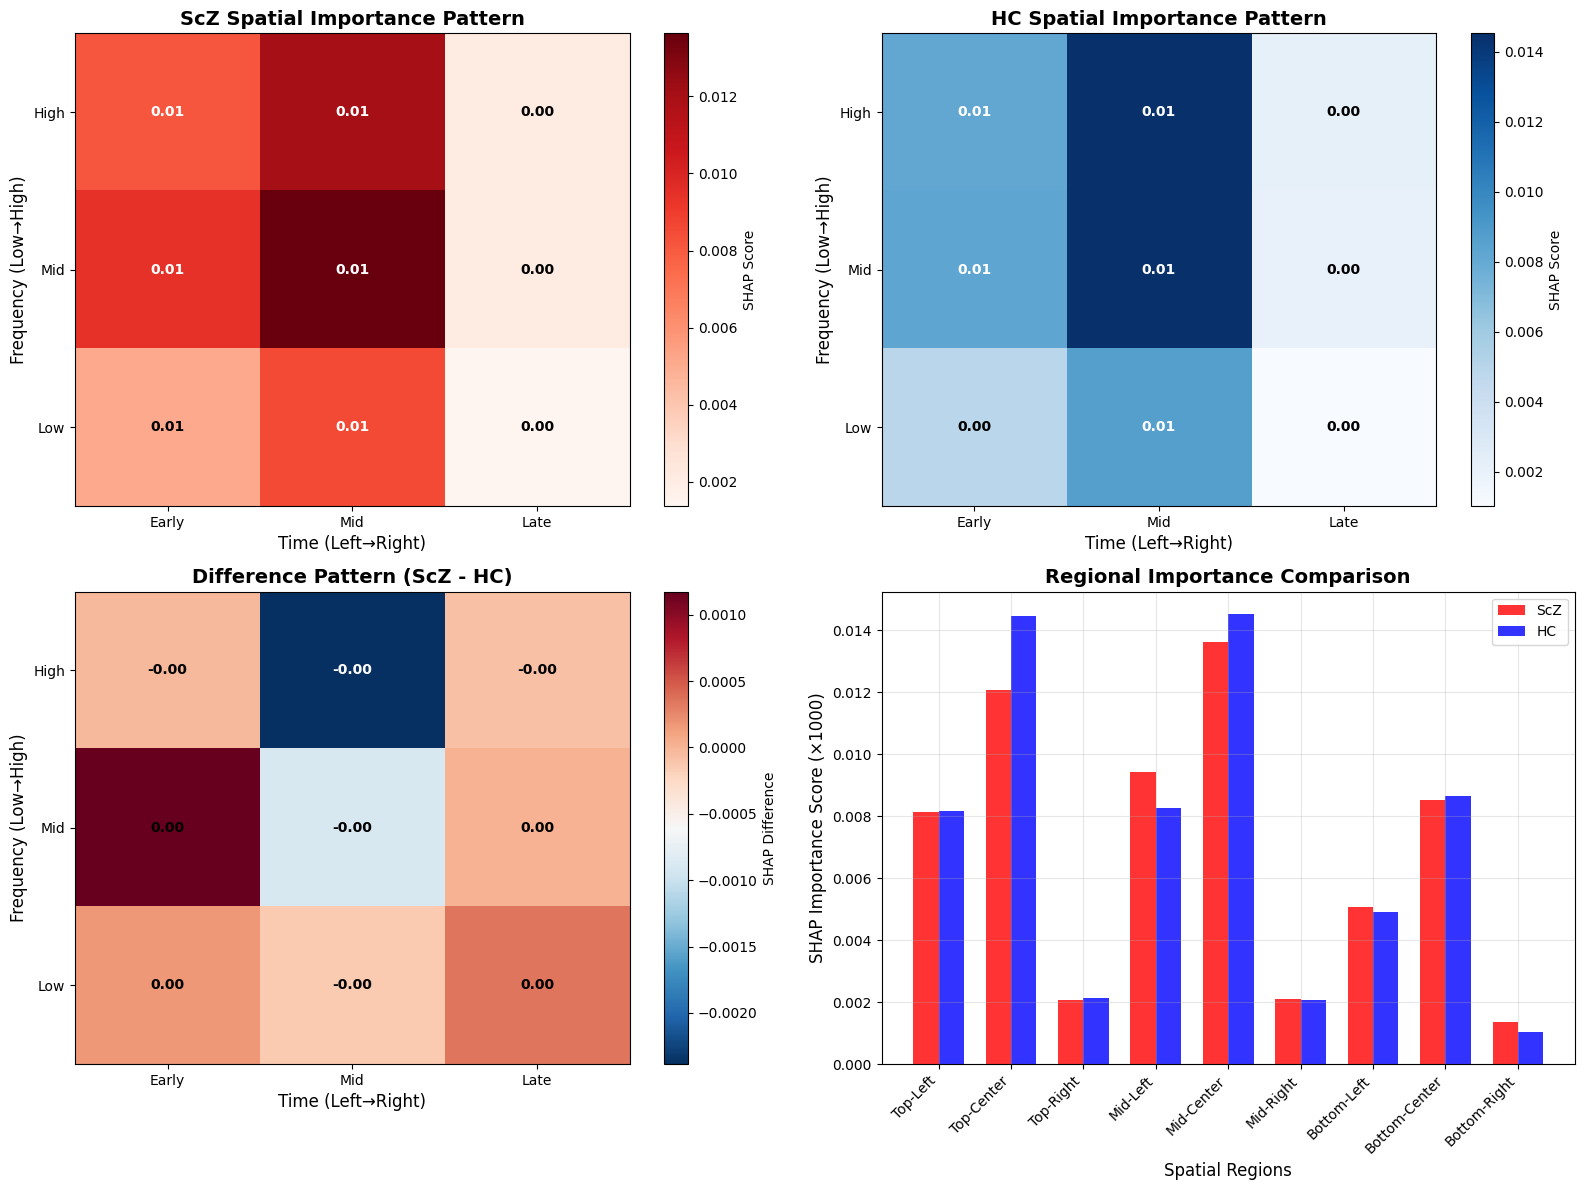


4. STATISTICAL SIGNIFICANCE ANALYSIS
--------------------------------------------------


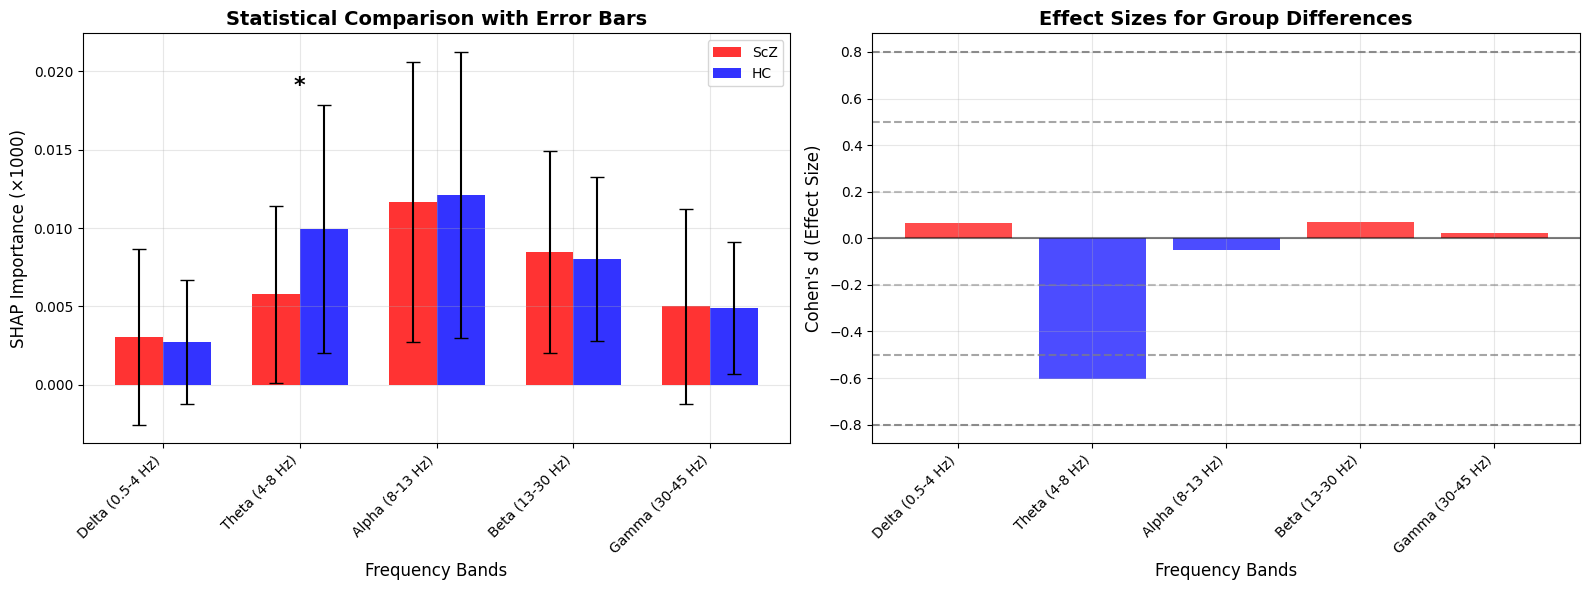


Statistical Significance Analysis:
Band                 ScZ Mean   HC Mean    p-value    Cohen d    Significant
----------------------------------------------------------------------
Delta (0.5-4 Hz)     0.003      0.003      0.496      0.064      
Theta (4-8 Hz)       0.006      0.010      0.000      -0.604     ***
Alpha (8-13 Hz)      0.012      0.012      0.590      -0.051     
Beta (13-30 Hz)      0.008      0.008      0.459      0.070      
Gamma (30-45 Hz)     0.005      0.005      0.801      0.024      

5. MULTI-METRIC FEATURE RANKING
--------------------------------------------------


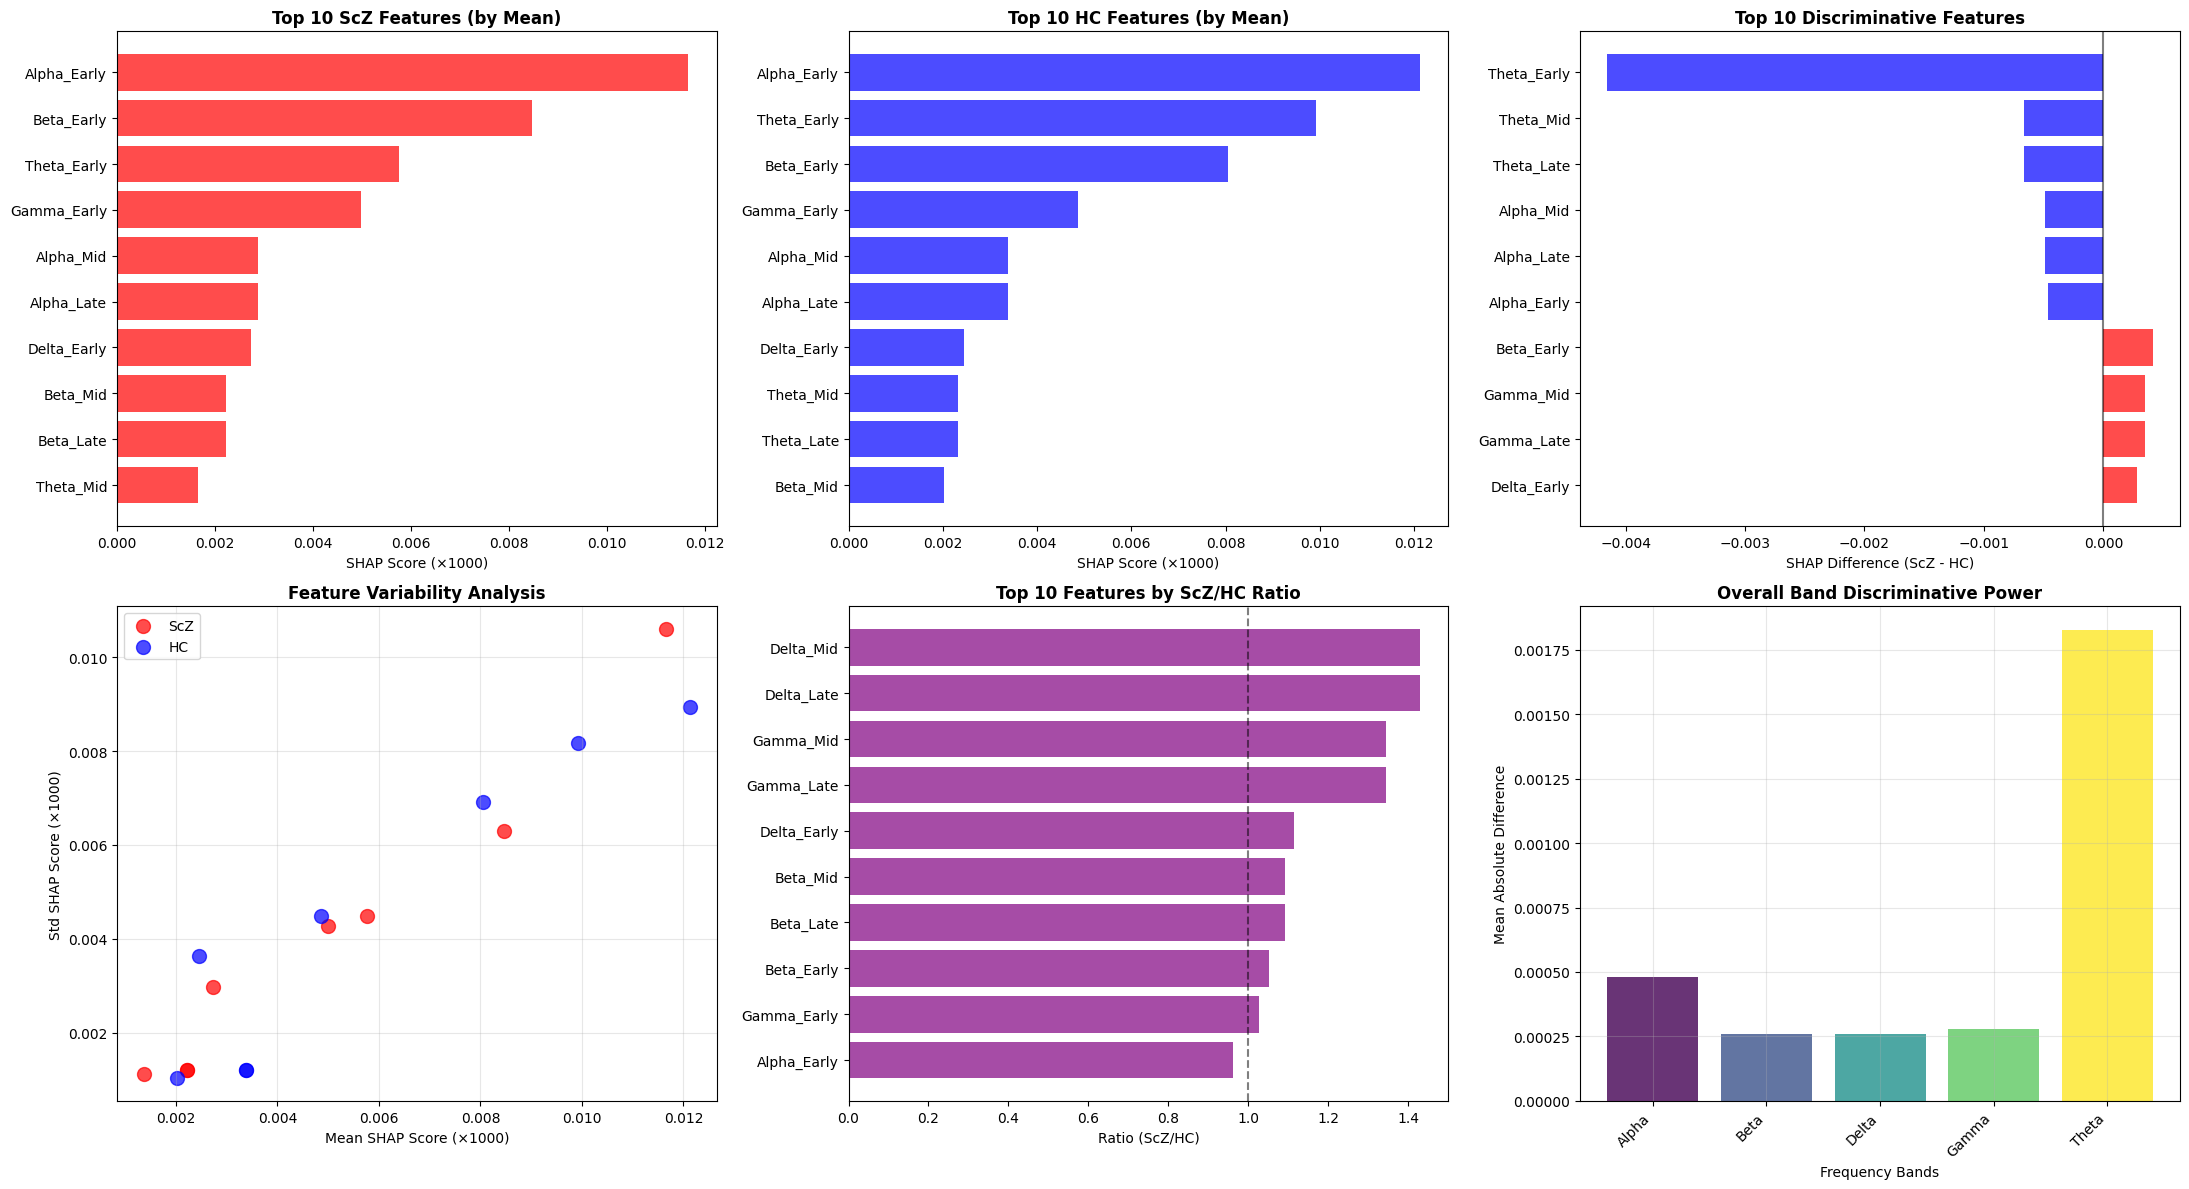


6. INDIVIDUAL SAMPLE VISUALIZATION
--------------------------------------------------


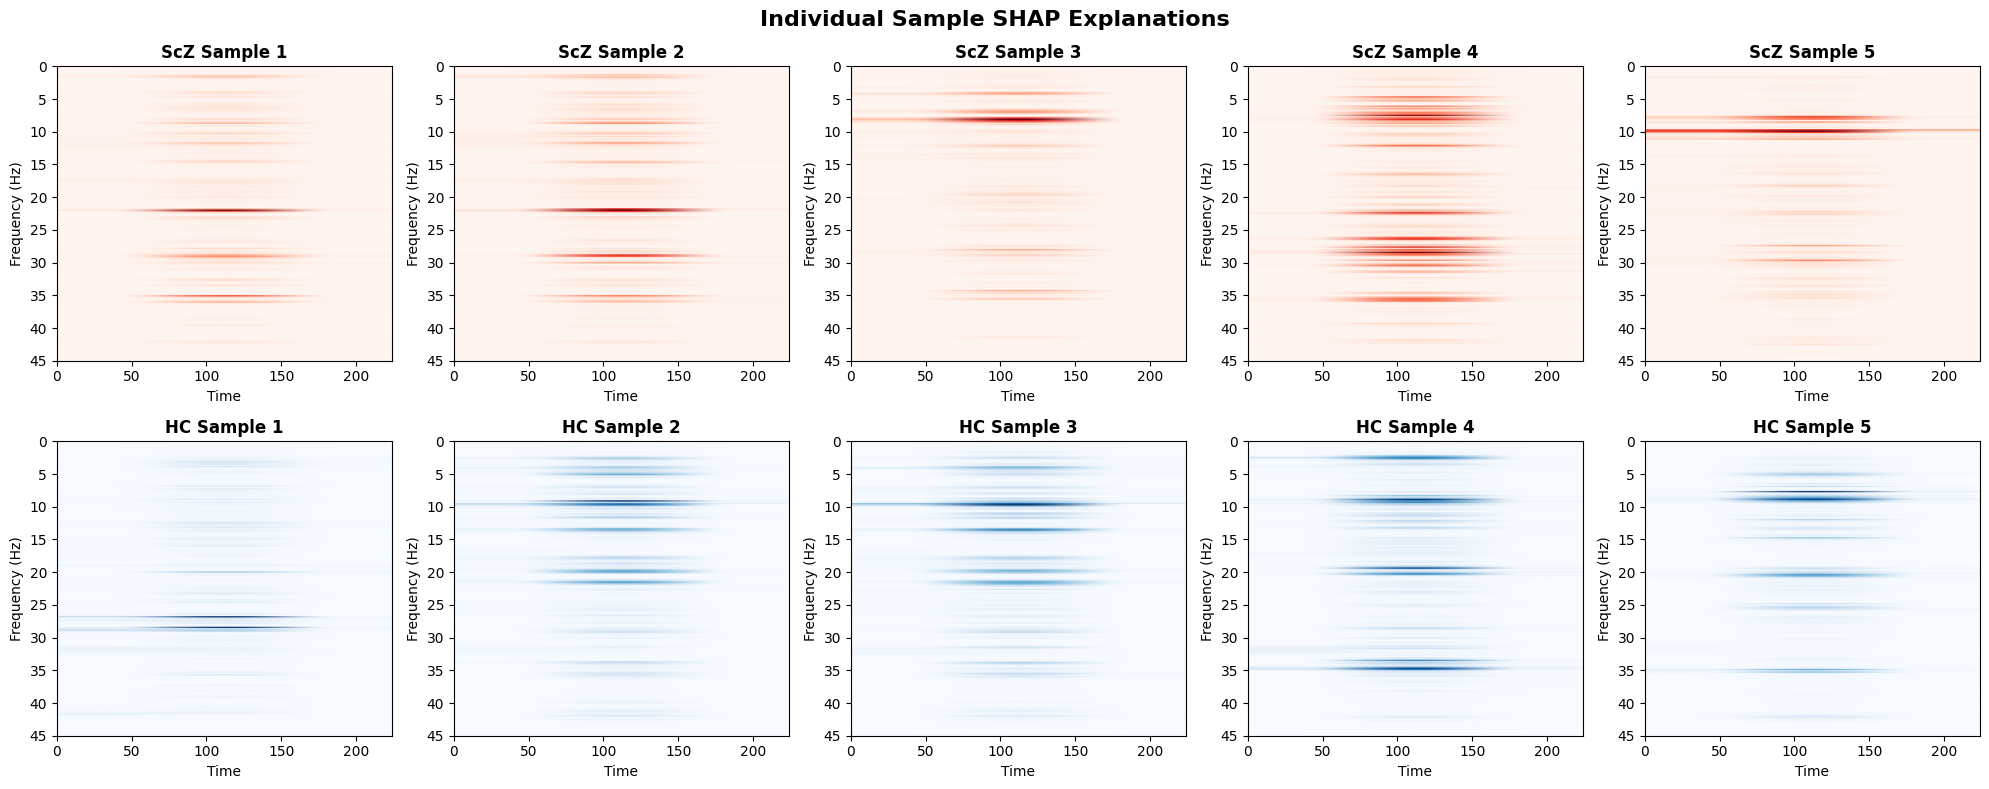


7. DETAILED HEATMAP GRID
--------------------------------------------------


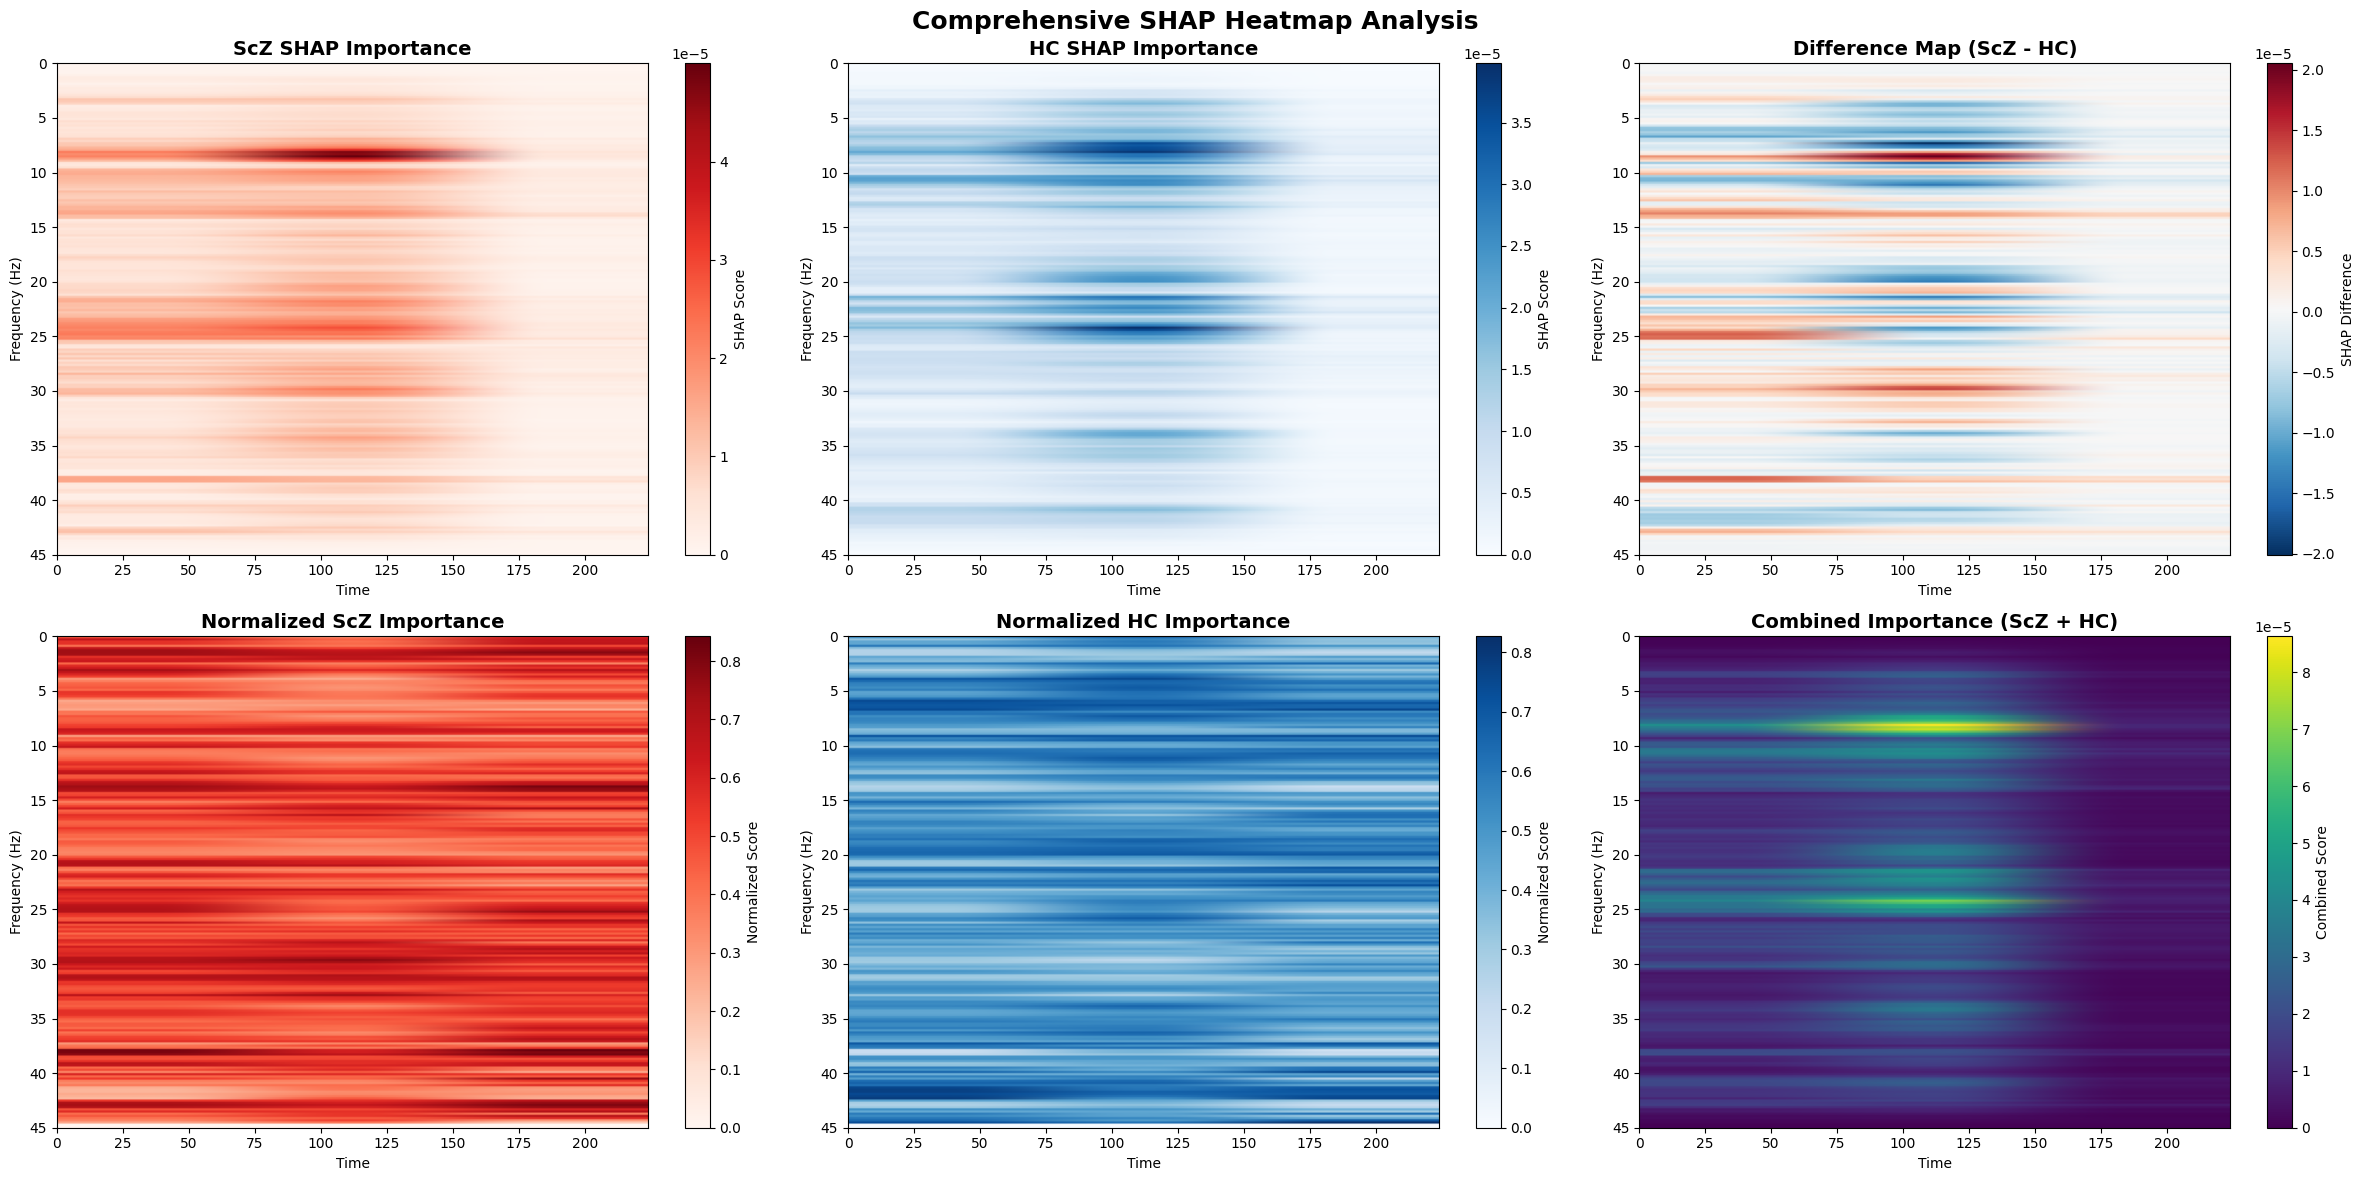


8. PERCENTILE THRESHOLD ANALYSIS
--------------------------------------------------


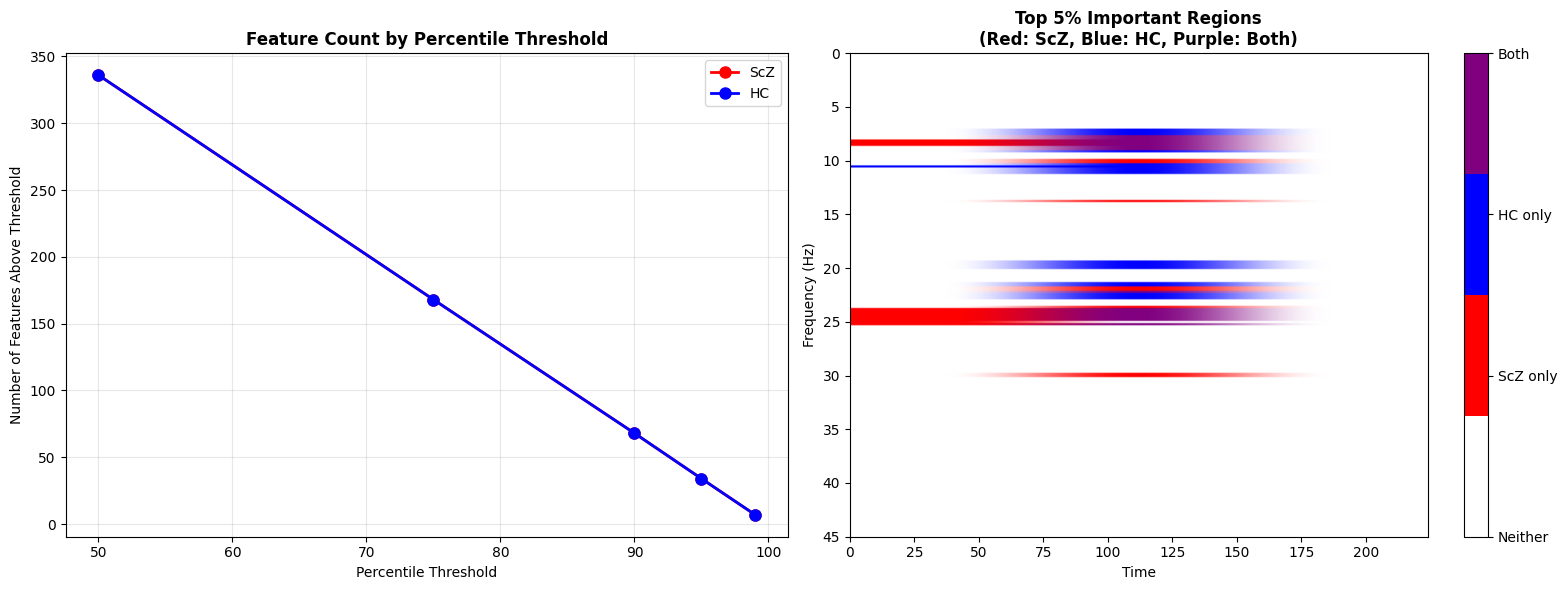


9. CLINICAL PATTERN DETECTION
--------------------------------------------------


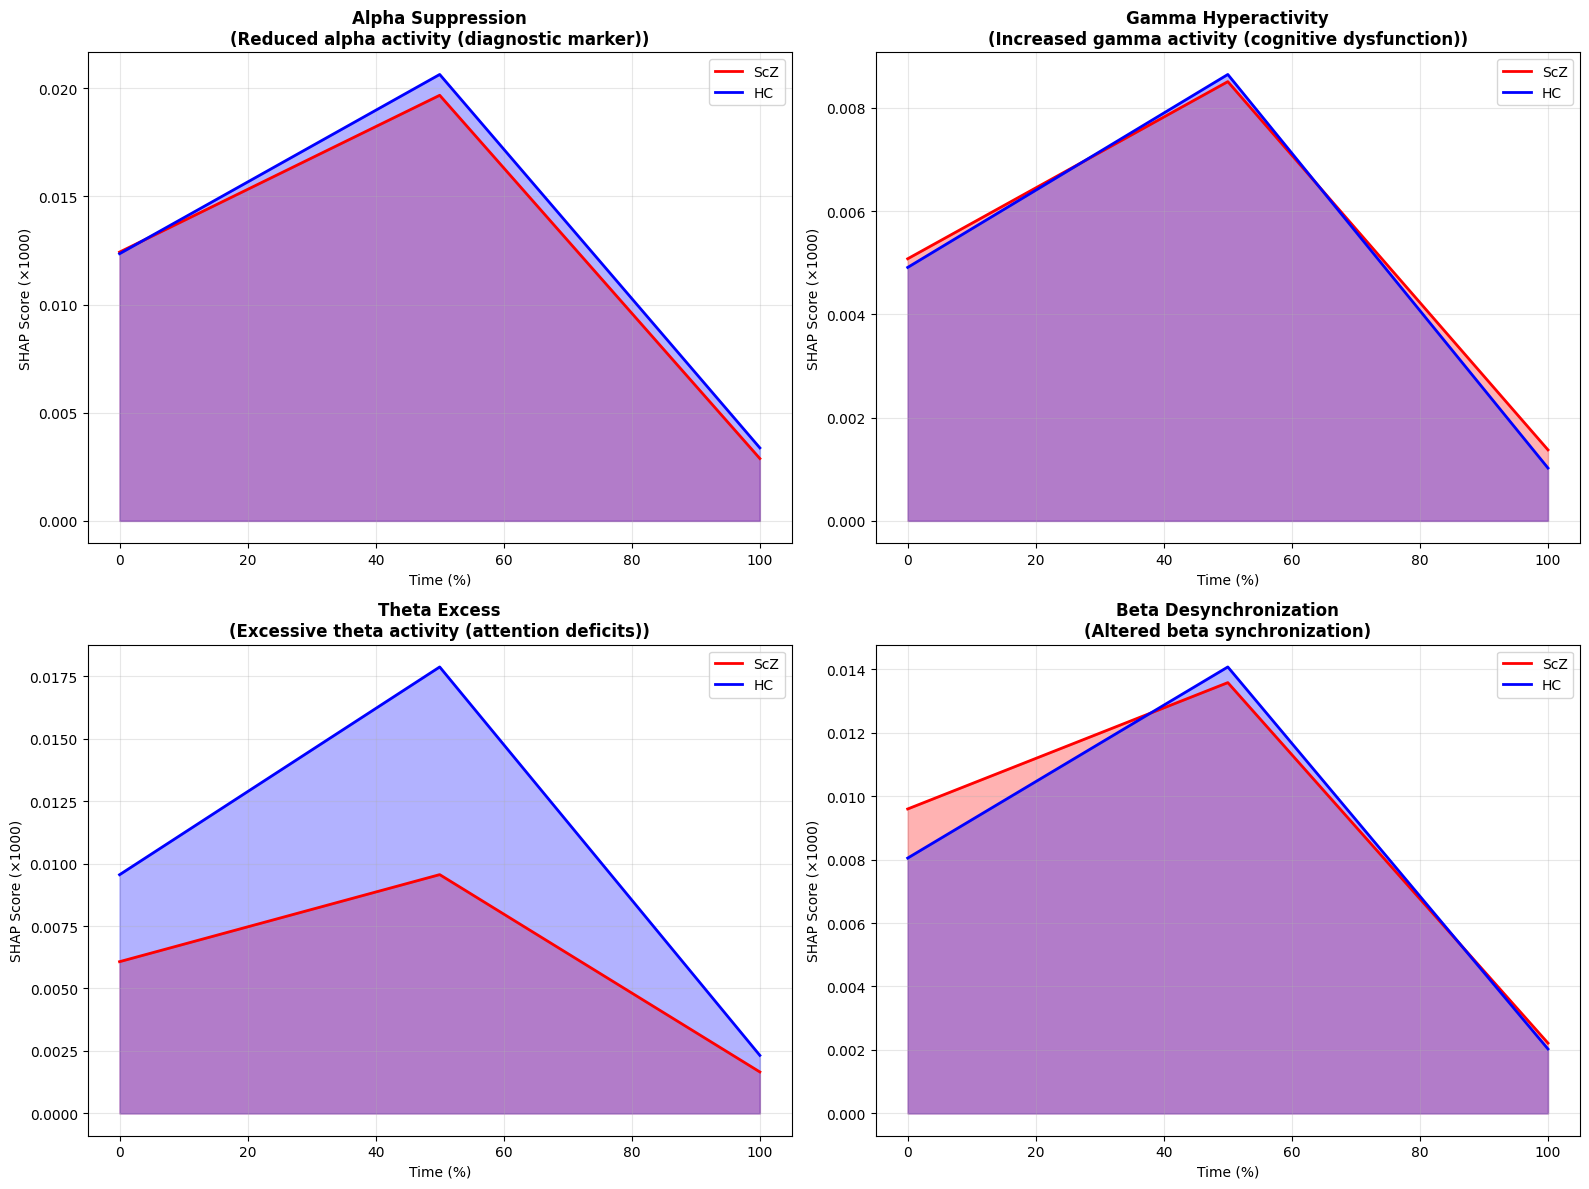


Clinical Pattern Analysis:

Alpha Suppression:
  Expected: Lower in ScZ
  ScZ Mean: 0.012, Peak: 0.020
  HC Mean:  0.012, Peak: 0.021
  Difference (ScZ-HC): -0.000
  ✓ MATCHES expected pattern

Gamma Hyperactivity:
  Expected: Higher in ScZ
  ScZ Mean: 0.005, Peak: 0.009
  HC Mean:  0.005, Peak: 0.009
  Difference (ScZ-HC): 0.000
  ✓ MATCHES expected pattern

Theta Excess:
  Expected: Higher in ScZ
  ScZ Mean: 0.006, Peak: 0.010
  HC Mean:  0.010, Peak: 0.018
  Difference (ScZ-HC): -0.004
  ✗ Does NOT match expected pattern

Beta Desynchronization:
  Expected: Different pattern in ScZ
  ScZ Mean: 0.008, Peak: 0.014
  HC Mean:  0.008, Peak: 0.014
  Difference (ScZ-HC): 0.000
  → Shows different pattern (diff: 0.000)

COMPREHENSIVE ANALYSIS COMPLETED!


In [ ]:
# COMPREHENSIVE SHAP FEATURE ANALYSIS
# Add this as a new cell in your notebook

def create_comprehensive_feature_analysis():
    """Create comprehensive feature analysis with multiple visualizations"""

    # Calculate mean SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    return mean_shap_scz_2d, mean_shap_hc_2d

# 1. DETAILED FREQUENCY BAND ANALYSIS
def analyze_detailed_frequency_bands():
    """Analyze detailed frequency bands with clinical relevance"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # More detailed frequency bands with clinical significance
    detailed_freq_bands = {
        'Delta (0.5-4 Hz)': (int(224*0.5/45), int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha Low (8-10 Hz)': (int(224*8/45), int(224*10/45)),
        'Alpha High (10-13 Hz)': (int(224*10/45), int(224*13/45)),
        'Beta Low (13-20 Hz)': (int(224*13/45), int(224*20/45)),
        'Beta High (20-30 Hz)': (int(224*20/45), int(224*30/45)),
        'Gamma Low (30-40 Hz)': (int(224*30/45), int(224*40/45)),
        'Gamma High (40-45 Hz)': (int(224*40/45), 224)
    }

    importance_scz = []
    importance_hc = []
    band_names = []

    for band_name, (start_freq, end_freq) in detailed_freq_bands.items():
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        scz_imp = np.mean(mean_shap_scz_2d[start_freq:end_freq, :]) * 1000
        hc_imp = np.mean(mean_shap_hc_2d[start_freq:end_freq, :]) * 1000

        importance_scz.append(scz_imp)
        importance_hc.append(hc_imp)
        band_names.append(band_name)

    # Create detailed frequency band plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Bar plot comparison
    x = np.arange(len(band_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, importance_scz, width, label='ScZ', alpha=0.8, color='red')
    bars2 = ax1.bar(x + width/2, importance_hc, width, label='HC', alpha=0.8, color='blue')

    ax1.set_xlabel('Detailed Frequency Bands', fontsize=12)
    ax1.set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    ax1.set_title('Detailed Frequency Band Analysis', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(band_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if abs(height) > 0.001:
                ax1.text(bar.get_x() + bar.get_width()/2., height + max(importance_scz + importance_hc)*0.01,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9, rotation=90)

    # Difference plot
    differences = np.array(importance_scz) - np.array(importance_hc)
    colors = ['red' if d > 0 else 'blue' for d in differences]
    bars3 = ax2.bar(x, differences, color=colors, alpha=0.7)
    ax2.set_xlabel('Detailed Frequency Bands', fontsize=12)
    ax2.set_ylabel('SHAP Difference (ScZ - HC)', fontsize=12)
    ax2.set_title('Feature Importance Differences (Red: ScZ > HC, Blue: HC > ScZ)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(band_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return detailed_freq_bands, importance_scz, importance_hc, differences

# 2. TEMPORAL ANALYSIS
def analyze_temporal_patterns():
    """Analyze temporal patterns in SHAP values"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define multiple temporal segments
    temporal_segments = {
        'Very Early (0-10%)': (0, 22),
        'Early (10-25%)': (22, 56),
        'Early-Mid (25-40%)': (56, 90),
        'Mid (40-60%)': (90, 134),
        'Mid-Late (60-75%)': (134, 168),
        'Late (75-90%)': (168, 202),
        'Very Late (90-100%)': (202, 224)
    }

    temporal_importance_scz = []
    temporal_importance_hc = []
    segment_names = []

    for seg_name, (start_time, end_time) in temporal_segments.items():
        start_time = max(0, min(start_time, mean_shap_scz_2d.shape[1]-1))
        end_time = max(start_time+1, min(end_time, mean_shap_scz_2d.shape[1]))

        scz_imp = np.mean(mean_shap_scz_2d[:, start_time:end_time]) * 1000
        hc_imp = np.mean(mean_shap_hc_2d[:, start_time:end_time]) * 1000

        temporal_importance_scz.append(scz_imp)
        temporal_importance_hc.append(hc_imp)
        segment_names.append(seg_name)

    # Create temporal analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Line plot showing temporal evolution
    time_points = range(len(segment_names))
    ax1.plot(time_points, temporal_importance_scz, 'ro-', label='ScZ', linewidth=2, markersize=8)
    ax1.plot(time_points, temporal_importance_hc, 'bo-', label='HC', linewidth=2, markersize=8)
    ax1.set_xlabel('Temporal Segments', fontsize=12)
    ax1.set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    ax1.set_title('Temporal Evolution of Feature Importance', fontsize=14, fontweight='bold')
    ax1.set_xticks(time_points)
    ax1.set_xticklabels(segment_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Heatmap showing temporal patterns
    temporal_data = np.array([temporal_importance_scz, temporal_importance_hc])
    im = ax2.imshow(temporal_data, cmap='RdYlBu_r', aspect='auto')
    ax2.set_xlabel('Temporal Segments', fontsize=12)
    ax2.set_ylabel('Classes', fontsize=12)
    ax2.set_title('Temporal Pattern Heatmap', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(segment_names)))
    ax2.set_xticklabels(segment_names, rotation=45, ha='right')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['ScZ', 'HC'])
    plt.colorbar(im, ax=ax2, label='SHAP Importance')

    plt.tight_layout()
    plt.show()

    return temporal_segments, temporal_importance_scz, temporal_importance_hc

# 3. FREQUENCY-TIME INTERACTION ANALYSIS
def analyze_frequency_time_interactions():
    """Analyze specific frequency-time combinations of clinical interest"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Clinical frequency-time combinations
    clinical_features = {
        'Early Delta Activity': {'freq': (0, int(224*4/45)), 'time': (0, 56)},
        'Early Theta Activity': {'freq': (int(224*4/45), int(224*8/45)), 'time': (0, 56)},
        'Early Alpha Activity': {'freq': (int(224*8/45), int(224*13/45)), 'time': (0, 56)},
        'Early Beta Activity': {'freq': (int(224*13/45), int(224*30/45)), 'time': (0, 56)},
        'Early Gamma Activity': {'freq': (int(224*30/45), 224), 'time': (0, 56)},

        'Mid Delta Activity': {'freq': (0, int(224*4/45)), 'time': (56, 168)},
        'Mid Theta Activity': {'freq': (int(224*4/45), int(224*8/45)), 'time': (56, 168)},
        'Mid Alpha Activity': {'freq': (int(224*8/45), int(224*13/45)), 'time': (56, 168)},
        'Mid Beta Activity': {'freq': (int(224*13/45), int(224*30/45)), 'time': (56, 168)},
        'Mid Gamma Activity': {'freq': (int(224*30/45), 224), 'time': (56, 168)},

        'Late Delta Activity': {'freq': (0, int(224*4/45)), 'time': (168, 224)},
        'Late Theta Activity': {'freq': (int(224*4/45), int(224*8/45)), 'time': (168, 224)},
        'Late Alpha Activity': {'freq': (int(224*8/45), int(224*13/45)), 'time': (168, 224)},
        'Late Beta Activity': {'freq': (int(224*13/45), int(224*30/45)), 'time': (168, 224)},
        'Late Gamma Activity': {'freq': (int(224*30/45), 224), 'time': (168, 224)},

        # Additional clinical patterns
        'Alpha-Beta Transition': {'freq': (int(224*10/45), int(224*15/45)), 'time': (56, 168)},
        'Beta-Gamma Transition': {'freq': (int(224*25/45), int(224*35/45)), 'time': (56, 168)},
        'High Frequency Burst': {'freq': (int(224*35/45), 224), 'time': (0, 112)},
        'Low Frequency Sustained': {'freq': (0, int(224*8/45)), 'time': (112, 224)},
    }

    feature_scores_scz = []
    feature_scores_hc = []
    feature_names = []

    for feature_name, coords in clinical_features.items():
        freq_range = coords['freq']
        time_range = coords['time']

        # Ensure indices are within bounds
        start_freq = max(0, min(freq_range[0], mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(freq_range[1], mean_shap_scz_2d.shape[0]))
        start_time = max(0, min(time_range[0], mean_shap_scz_2d.shape[1]-1))
        end_time = max(start_time+1, min(time_range[1], mean_shap_scz_2d.shape[1]))

        scz_score = np.mean(mean_shap_scz_2d[start_freq:end_freq, start_time:end_time]) * 1000
        hc_score = np.mean(mean_shap_hc_2d[start_freq:end_freq, start_time:end_time]) * 1000

        feature_scores_scz.append(scz_score)
        feature_scores_hc.append(hc_score)
        feature_names.append(feature_name)

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Top ScZ features
    scz_indices = np.argsort(feature_scores_scz)[::-1]
    top_15_scz = scz_indices[:15]

    y_pos = np.arange(len(top_15_scz))
    bars1 = axes[0,0].barh(y_pos, [feature_scores_scz[i] for i in top_15_scz],
                          color=plt.cm.Reds(np.linspace(0.4, 0.9, len(top_15_scz))))
    axes[0,0].set_yticks(y_pos)
    axes[0,0].set_yticklabels([feature_names[i] for i in top_15_scz], fontsize=10)
    axes[0,0].set_xlabel('SHAP Importance Score (×1000)', fontsize=12)
    axes[0,0].set_title('Top 15 Features for ScZ Classification', fontsize=14, fontweight='bold')
    axes[0,0].invert_yaxis()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Top HC features
    hc_indices = np.argsort(feature_scores_hc)[::-1]
    top_15_hc = hc_indices[:15]

    y_pos = np.arange(len(top_15_hc))
    bars2 = axes[0,1].barh(y_pos, [feature_scores_hc[i] for i in top_15_hc],
                          color=plt.cm.Blues(np.linspace(0.4, 0.9, len(top_15_hc))))
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels([feature_names[i] for i in top_15_hc], fontsize=10)
    axes[0,1].set_xlabel('SHAP Importance Score (×1000)', fontsize=12)
    axes[0,1].set_title('Top 15 Features for HC Classification', fontsize=14, fontweight='bold')
    axes[0,1].invert_yaxis()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Difference analysis
    differences = np.array(feature_scores_scz) - np.array(feature_scores_hc)
    diff_indices = np.argsort(np.abs(differences))[::-1]
    top_15_diff = diff_indices[:15]

    colors_diff = ['red' if differences[i] > 0 else 'blue' for i in top_15_diff]
    y_pos = np.arange(len(top_15_diff))
    bars3 = axes[1,0].barh(y_pos, [differences[i] for i in top_15_diff], color=colors_diff, alpha=0.7)
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels([feature_names[i] for i in top_15_diff], fontsize=10)
    axes[1,0].set_xlabel('SHAP Difference (ScZ - HC)', fontsize=12)
    axes[1,0].set_title('Top 15 Discriminative Features', fontsize=14, fontweight='bold')
    axes[1,0].invert_yaxis()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # 4. Feature correlation matrix
    feature_matrix = np.array([feature_scores_scz, feature_scores_hc])
    correlation_matrix = np.corrcoef(feature_matrix)

    im = axes[1,1].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1,1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    axes[1,1].set_xticks([0, 1])
    axes[1,1].set_yticks([0, 1])
    axes[1,1].set_xticklabels(['ScZ', 'HC'])
    axes[1,1].set_yticklabels(['ScZ', 'HC'])

    # Add correlation values
    for i in range(2):
        for j in range(2):
            axes[1,1].text(j, i, f'{correlation_matrix[i,j]:.3f}',
                          ha='center', va='center', fontsize=12, fontweight='bold')

    plt.colorbar(im, ax=axes[1,1], label='Correlation')

    plt.suptitle('Comprehensive Clinical Feature Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return clinical_features, feature_scores_scz, feature_scores_hc, differences

# 4. REGIONAL ANALYSIS (Spatial Patterns)
def analyze_spatial_regions():
    """Analyze spatial regions of the time-frequency representation"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define spatial regions
    height, width = mean_shap_scz_2d.shape
    regions = {
        'Top-Left': {'freq': (0, height//3), 'time': (0, width//3)},
        'Top-Center': {'freq': (0, height//3), 'time': (width//3, 2*width//3)},
        'Top-Right': {'freq': (0, height//3), 'time': (2*width//3, width)},
        'Mid-Left': {'freq': (height//3, 2*height//3), 'time': (0, width//3)},
        'Mid-Center': {'freq': (height//3, 2*height//3), 'time': (width//3, 2*width//3)},
        'Mid-Right': {'freq': (height//3, 2*height//3), 'time': (2*width//3, width)},
        'Bottom-Left': {'freq': (2*height//3, height), 'time': (0, width//3)},
        'Bottom-Center': {'freq': (2*height//3, height), 'time': (width//3, 2*width//3)},
        'Bottom-Right': {'freq': (2*height//3, height), 'time': (2*width//3, width)},
    }

    region_scores_scz = []
    region_scores_hc = []
    region_names = []

    for region_name, coords in regions.items():
        freq_range = coords['freq']
        time_range = coords['time']

        scz_score = np.mean(mean_shap_scz_2d[freq_range[0]:freq_range[1],
                                           time_range[0]:time_range[1]]) * 1000
        hc_score = np.mean(mean_shap_hc_2d[freq_range[0]:freq_range[1],
                                          time_range[0]:time_range[1]]) * 1000

        region_scores_scz.append(scz_score)
        region_scores_hc.append(hc_score)
        region_names.append(region_name)

    # Create 3x3 grid visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Reshape scores for grid visualization
    scz_grid = np.array(region_scores_scz).reshape(3, 3)
    hc_grid = np.array(region_scores_hc).reshape(3, 3)

    # ScZ spatial pattern
    im1 = axes[0,0].imshow(scz_grid, cmap='Reds', aspect='auto')
    axes[0,0].set_title('ScZ Spatial Importance Pattern', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Time (Left→Right)', fontsize=12)
    axes[0,0].set_ylabel('Frequency (Low→High)', fontsize=12)
    axes[0,0].set_xticks([0, 1, 2])
    axes[0,0].set_xticklabels(['Early', 'Mid', 'Late'])
    axes[0,0].set_yticks([0, 1, 2])
    axes[0,0].set_yticklabels(['High', 'Mid', 'Low'])
    plt.colorbar(im1, ax=axes[0,0], label='SHAP Score')

    # Add values to cells
    for i in range(3):
        for j in range(3):
            axes[0,0].text(j, i, f'{scz_grid[i,j]:.2f}', ha='center', va='center',
                          fontweight='bold', color='white' if scz_grid[i,j] > scz_grid.max()*0.5 else 'black')

    # HC spatial pattern
    im2 = axes[0,1].imshow(hc_grid, cmap='Blues', aspect='auto')
    axes[0,1].set_title('HC Spatial Importance Pattern', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Time (Left→Right)', fontsize=12)
    axes[0,1].set_ylabel('Frequency (Low→High)', fontsize=12)
    axes[0,1].set_xticks([0, 1, 2])
    axes[0,1].set_xticklabels(['Early', 'Mid', 'Late'])
    axes[0,1].set_yticks([0, 1, 2])
    axes[0,1].set_yticklabels(['High', 'Mid', 'Low'])
    plt.colorbar(im2, ax=axes[0,1], label='SHAP Score')

    # Add values to cells
    for i in range(3):
        for j in range(3):
            axes[0,1].text(j, i, f'{hc_grid[i,j]:.2f}', ha='center', va='center',
                          fontweight='bold', color='white' if hc_grid[i,j] > hc_grid.max()*0.5 else 'black')

    # Difference grid
    diff_grid = scz_grid - hc_grid
    im3 = axes[1,0].imshow(diff_grid, cmap='RdBu_r', aspect='auto')
    axes[1,0].set_title('Difference Pattern (ScZ - HC)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Time (Left→Right)', fontsize=12)
    axes[1,0].set_ylabel('Frequency (Low→High)', fontsize=12)
    axes[1,0].set_xticks([0, 1, 2])
    axes[1,0].set_xticklabels(['Early', 'Mid', 'Late'])
    axes[1,0].set_yticks([0, 1, 2])
    axes[1,0].set_yticklabels(['High', 'Mid', 'Low'])
    plt.colorbar(im3, ax=axes[1,0], label='SHAP Difference')

    # Add values to cells
    for i in range(3):
        for j in range(3):
            axes[1,0].text(j, i, f'{diff_grid[i,j]:.2f}', ha='center', va='center',
                          fontweight='bold', color='white' if abs(diff_grid[i,j]) > abs(diff_grid).max()*0.5 else 'black')

    # Regional comparison bar plot
    x = np.arange(len(region_names))
    width = 0.35
    bars1 = axes[1,1].bar(x - width/2, region_scores_scz, width, label='ScZ', alpha=0.8, color='red')
    bars2 = axes[1,1].bar(x + width/2, region_scores_hc, width, label='HC', alpha=0.8, color='blue')

    axes[1,1].set_xlabel('Spatial Regions', fontsize=12)
    axes[1,1].set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    axes[1,1].set_title('Regional Importance Comparison', fontsize=14, fontweight='bold')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(region_names, rotation=45, ha='right')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return regions, region_scores_scz, region_scores_hc

# 5. STATISTICAL SIGNIFICANCE ANALYSIS
def analyze_statistical_significance():
    """Analyze statistical significance of SHAP differences"""

    from scipy import stats

    # Get raw SHAP values for statistical testing
    shap_scz_raw = combined_shap_values[0]  # Shape: (n_samples, height, width, channels)
    shap_hc_raw = combined_shap_values[1]

    # Calculate sample-wise importance for each frequency band
    freq_bands = {
        'Delta (0.5-4 Hz)': (int(224*0.5/45), int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha (8-13 Hz)': (int(224*8/45), int(224*13/45)),
        'Beta (13-30 Hz)': (int(224*13/45), int(224*30/45)),
        'Gamma (30-45 Hz)': (int(224*30/45), 224)
    }

    statistical_results = {}

    for band_name, (start_freq, end_freq) in freq_bands.items():
        start_freq = max(0, min(start_freq, shap_scz_raw.shape[1]-1))
        end_freq = max(start_freq+1, min(end_freq, shap_scz_raw.shape[1]))

        # Calculate importance per sample
        scz_samples = []
        hc_samples = []

        for sample_idx in range(shap_scz_raw.shape[0]):
            scz_sample_importance = np.mean(np.abs(shap_scz_raw[sample_idx, start_freq:end_freq, :, :]))
            scz_samples.append(scz_sample_importance)

        for sample_idx in range(shap_hc_raw.shape[0]):
            hc_sample_importance = np.mean(np.abs(shap_hc_raw[sample_idx, start_freq:end_freq, :, :]))
            hc_samples.append(hc_sample_importance)

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(scz_samples, hc_samples)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(scz_samples)-1)*np.var(scz_samples) +
                             (len(hc_samples)-1)*np.var(hc_samples)) /
                            (len(scz_samples) + len(hc_samples) - 2))
        cohens_d = (np.mean(scz_samples) - np.mean(hc_samples)) / pooled_std

        statistical_results[band_name] = {
            'scz_mean': np.mean(scz_samples) * 1000,
            'hc_mean': np.mean(hc_samples) * 1000,
            'scz_std': np.std(scz_samples) * 1000,
            'hc_std': np.std(hc_samples) * 1000,
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significant': p_value < 0.05
        }

    # Create statistical visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Error bar plot
    bands = list(statistical_results.keys())
    scz_means = [statistical_results[b]['scz_mean'] for b in bands]
    hc_means = [statistical_results[b]['hc_mean'] for b in bands]
    scz_stds = [statistical_results[b]['scz_std'] for b in bands]
    hc_stds = [statistical_results[b]['hc_std'] for b in bands]

    x = np.arange(len(bands))
    width = 0.35

    bars1 = ax1.bar(x - width/2, scz_means, width, yerr=scz_stds, label='ScZ',
                   alpha=0.8, color='red', capsize=5)
    bars2 = ax1.bar(x + width/2, hc_means, width, yerr=hc_stds, label='HC',
                   alpha=0.8, color='blue', capsize=5)

    ax1.set_xlabel('Frequency Bands', fontsize=12)
    ax1.set_ylabel('SHAP Importance (×1000)', fontsize=12)
    ax1.set_title('Statistical Comparison with Error Bars', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(bands, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add significance markers
    for i, band in enumerate(bands):
        if statistical_results[band]['significant']:
            max_height = max(scz_means[i] + scz_stds[i], hc_means[i] + hc_stds[i])
            ax1.text(i, max_height + max(scz_means + hc_means)*0.05, '*',
                    ha='center', va='bottom', fontsize=16, fontweight='bold')

    # Effect size plot
    effect_sizes = [statistical_results[b]['cohens_d'] for b in bands]
    colors = ['red' if es > 0 else 'blue' for es in effect_sizes]

    bars3 = ax2.bar(x, effect_sizes, color=colors, alpha=0.7)
    ax2.set_xlabel('Frequency Bands', fontsize=12)
    ax2.set_ylabel("Cohen's d (Effect Size)", fontsize=12)
    ax2.set_title('Effect Sizes for Group Differences', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(bands, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add effect size interpretation lines
    ax2.axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Small effect')
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Medium effect')
    ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.9, label='Large effect')
    ax2.axhline(y=-0.2, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.7)
    ax2.axhline(y=-0.8, color='gray', linestyle='--', alpha=0.9)

    plt.tight_layout()
    plt.show()

    # Print statistical results
    print("\nStatistical Significance Analysis:")
    print("=" * 70)
    print(f"{'Band':<20} {'ScZ Mean':<10} {'HC Mean':<10} {'p-value':<10} {'Cohen d':<10} {'Significant'}")
    print("-" * 70)
    for band in bands:
        result = statistical_results[band]
        sig_marker = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['significant'] else ""
        print(f"{band:<20} {result['scz_mean']:<10.3f} {result['hc_mean']:<10.3f} "
              f"{result['p_value']:<10.3f} {result['cohens_d']:<10.3f} {sig_marker}")

    return statistical_results

# 6. INDIVIDUAL SAMPLE ANALYSIS
def analyze_individual_samples(n_samples=10):
    """Analyze individual samples to show SHAP explanations"""

    # Select diverse samples
    scz_indices = np.where(combined_test_labels == 0)[0]
    hc_indices = np.where(combined_test_labels == 1)[0]

    selected_scz = np.random.choice(scz_indices, min(n_samples//2, len(scz_indices)), replace=False)
    selected_hc = np.random.choice(hc_indices, min(n_samples//2, len(hc_indices)), replace=False)

    fig, axes = plt.subplots(2, min(5, n_samples//2), figsize=(20, 8))
    if min(5, n_samples//2) == 1:
        axes = axes.reshape(-1, 1)

    # Plot ScZ samples
    for i, sample_idx in enumerate(selected_scz[:5]):
        if i >= axes.shape[1]:
            break
        sample_shap = np.mean(np.abs(combined_shap_values[0][sample_idx]), axis=2)
        im = axes[0, i].imshow(sample_shap, cmap='Reds', aspect='auto', extent=[0, 224, 45, 0])
        axes[0, i].set_title(f'ScZ Sample {i+1}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel('Frequency (Hz)')

    # Plot HC samples
    for i, sample_idx in enumerate(selected_hc[:5]):
        if i >= axes.shape[1]:
            break
        sample_shap = np.mean(np.abs(combined_shap_values[1][sample_idx]), axis=2)
        im = axes[1, i].imshow(sample_shap, cmap='Blues', aspect='auto', extent=[0, 224, 45, 0])
        axes[1, i].set_title(f'HC Sample {i+1}', fontsize=12, fontweight='bold')
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel('Frequency (Hz)')

    plt.suptitle('Individual Sample SHAP Explanations', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 7. FEATURE RANKING WITH MULTIPLE METRICS
def create_multi_metric_ranking():
    """Create feature ranking using multiple metrics"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define features
    freq_bands = {
        'Delta': (0, int(224*4/45)),
        'Theta': (int(224*4/45), int(224*8/45)),
        'Alpha': (int(224*8/45), int(224*13/45)),
        'Beta': (int(224*13/45), int(224*30/45)),
        'Gamma': (int(224*30/45), 224)
    }

    time_segments = {
        'Early': (0, 75),
        'Mid': (75, 149),
        'Late': (149, 224)
    }

    features_data = []

    for band_name, (start_freq, end_freq) in freq_bands.items():
        for seg_name, (start_time, end_time) in time_segments.items():
            start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
            end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))
            start_time = max(0, min(start_time, mean_shap_scz_2d.shape[1]-1))
            end_time = max(start_time+1, min(end_time, mean_shap_scz_2d.shape[1]))

            # Extract region
            scz_region = mean_shap_scz_2d[start_freq:end_freq, start_time:end_time]
            hc_region = mean_shap_hc_2d[start_freq:end_freq, start_time:end_time]

            feature_name = f"{band_name}_{seg_name}"

            # Calculate multiple metrics
            scz_mean = np.mean(scz_region) * 1000
            hc_mean = np.mean(hc_region) * 1000
            scz_max = np.max(scz_region) * 1000
            hc_max = np.max(hc_region) * 1000
            scz_std = np.std(scz_region) * 1000
            hc_std = np.std(hc_region) * 1000

            difference = scz_mean - hc_mean
            ratio = scz_mean / (hc_mean + 1e-10)  # Avoid division by zero

            features_data.append({
                'feature': feature_name,
                'band': band_name,
                'time': seg_name,
                'scz_mean': scz_mean,
                'hc_mean': hc_mean,
                'scz_max': scz_max,
                'hc_max': hc_max,
                'scz_std': scz_std,
                'hc_std': hc_std,
                'difference': difference,
                'ratio': ratio,
                'abs_difference': abs(difference)
            })

    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(features_data)

    # Create multi-metric visualization
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))

    # 1. Top features by ScZ importance
    top_scz = df.nlargest(10, 'scz_mean')
    y_pos = np.arange(len(top_scz))
    axes[0,0].barh(y_pos, top_scz['scz_mean'], color='red', alpha=0.7)
    axes[0,0].set_yticks(y_pos)
    axes[0,0].set_yticklabels(top_scz['feature'], fontsize=10)
    axes[0,0].set_xlabel('SHAP Score (×1000)')
    axes[0,0].set_title('Top 10 ScZ Features (by Mean)', fontweight='bold')
    axes[0,0].invert_yaxis()

    # 2. Top features by HC importance
    top_hc = df.nlargest(10, 'hc_mean')
    y_pos = np.arange(len(top_hc))
    axes[0,1].barh(y_pos, top_hc['hc_mean'], color='blue', alpha=0.7)
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels(top_hc['feature'], fontsize=10)
    axes[0,1].set_xlabel('SHAP Score (×1000)')
    axes[0,1].set_title('Top 10 HC Features (by Mean)', fontweight='bold')
    axes[0,1].invert_yaxis()

    # 3. Top features by absolute difference
    top_diff = df.nlargest(10, 'abs_difference')
    colors_diff = ['red' if d > 0 else 'blue' for d in top_diff['difference']]
    y_pos = np.arange(len(top_diff))
    axes[0,2].barh(y_pos, top_diff['difference'], color=colors_diff, alpha=0.7)
    axes[0,2].set_yticks(y_pos)
    axes[0,2].set_yticklabels(top_diff['feature'], fontsize=10)
    axes[0,2].set_xlabel('SHAP Difference (ScZ - HC)')
    axes[0,2].set_title('Top 10 Discriminative Features', fontweight='bold')
    axes[0,2].invert_yaxis()
    axes[0,2].axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # 4. Feature variability (by std)
    top_var_scz = df.nlargest(8, 'scz_std')
    top_var_hc = df.nlargest(8, 'hc_std')

    axes[1,0].scatter(top_var_scz['scz_mean'], top_var_scz['scz_std'],
                     color='red', alpha=0.7, s=100, label='ScZ')
    axes[1,0].scatter(top_var_hc['hc_mean'], top_var_hc['hc_std'],
                     color='blue', alpha=0.7, s=100, label='HC')
    axes[1,0].set_xlabel('Mean SHAP Score (×1000)')
    axes[1,0].set_ylabel('Std SHAP Score (×1000)')
    axes[1,0].set_title('Feature Variability Analysis', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 5. Ratio analysis
    top_ratio = df.nlargest(10, 'ratio')
    y_pos = np.arange(len(top_ratio))
    axes[1,1].barh(y_pos, top_ratio['ratio'], color='purple', alpha=0.7)
    axes[1,1].set_yticks(y_pos)
    axes[1,1].set_yticklabels(top_ratio['feature'], fontsize=10)
    axes[1,1].set_xlabel('Ratio (ScZ/HC)')
    axes[1,1].set_title('Top 10 Features by ScZ/HC Ratio', fontweight='bold')
    axes[1,1].invert_yaxis()
    axes[1,1].axvline(x=1, color='black', linestyle='--', alpha=0.5)

    # 6. Band-wise summary
    band_summary = df.groupby('band').agg({
        'scz_mean': 'mean',
        'hc_mean': 'mean',
        'difference': 'mean',
        'abs_difference': 'mean'
    }).reset_index()

    x_bands = np.arange(len(band_summary))
    axes[1,2].bar(x_bands, band_summary['abs_difference'],
                 color=plt.cm.viridis(np.linspace(0, 1, len(band_summary))), alpha=0.8)
    axes[1,2].set_xlabel('Frequency Bands')
    axes[1,2].set_ylabel('Mean Absolute Difference')
    axes[1,2].set_title('Overall Band Discriminative Power', fontweight='bold')
    axes[1,2].set_xticks(x_bands)
    axes[1,2].set_xticklabels(band_summary['band'], rotation=45, ha='right')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df, statistical_results

# 8. HEATMAP GRID ANALYSIS
def create_detailed_heatmap_grid():
    """Create detailed heatmap grid for different aspects"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    fig, axes = plt.subplots(2, 3, figsize=(24, 12))

    # 1. Raw ScZ SHAP values
    im1 = axes[0,0].imshow(mean_shap_scz_2d, cmap='Reds', aspect='auto', extent=[0, 224, 45, 0])
    axes[0,0].set_title('ScZ SHAP Importance', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im1, ax=axes[0,0], label='SHAP Score')

    # 2. Raw HC SHAP values
    im2 = axes[0,1].imshow(mean_shap_hc_2d, cmap='Blues', aspect='auto', extent=[0, 224, 45, 0])
    axes[0,1].set_title('HC SHAP Importance', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im2, ax=axes[0,1], label='SHAP Score')

    # 3. Difference map
    difference_map = mean_shap_scz_2d - mean_shap_hc_2d
    im3 = axes[0,2].imshow(difference_map, cmap='RdBu_r', aspect='auto', extent=[0, 224, 45, 0])
    axes[0,2].set_title('Difference Map (ScZ - HC)', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Time')
    axes[0,2].set_ylabel('Frequency (Hz)')
    plt.colorbar(im3, ax=axes[0,2], label='SHAP Difference')

    # 4. Normalized ScZ (relative to total)
    total_importance = mean_shap_scz_2d + mean_shap_hc_2d + 1e-10
    normalized_scz = mean_shap_scz_2d / total_importance
    im4 = axes[1,0].imshow(normalized_scz, cmap='Reds', aspect='auto', extent=[0, 224, 45, 0])
    axes[1,0].set_title('Normalized ScZ Importance', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im4, ax=axes[1,0], label='Normalized Score')

    # 5. Normalized HC (relative to total)
    normalized_hc = mean_shap_hc_2d / total_importance
    im5 = axes[1,1].imshow(normalized_hc, cmap='Blues', aspect='auto', extent=[0, 224, 45, 0])
    axes[1,1].set_title('Normalized HC Importance', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im5, ax=axes[1,1], label='Normalized Score')

    # 6. Combined importance (sum of both classes)
    combined_importance = mean_shap_scz_2d + mean_shap_hc_2d
    im6 = axes[1,2].imshow(combined_importance, cmap='viridis', aspect='auto', extent=[0, 224, 45, 0])
    axes[1,2].set_title('Combined Importance (ScZ + HC)', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Frequency (Hz)')
    plt.colorbar(im6, ax=axes[1,2], label='Combined Score')

    plt.suptitle('Comprehensive SHAP Heatmap Analysis', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 9. PERCENTILE AND THRESHOLD ANALYSIS
def analyze_percentile_features():
    """Analyze features at different percentile thresholds"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Calculate percentiles
    percentiles = [50, 75, 90, 95, 99]

    scz_percentiles = []
    hc_percentiles = []

    for p in percentiles:
        scz_threshold = np.percentile(mean_shap_scz_2d, p)
        hc_threshold = np.percentile(mean_shap_hc_2d, p)

        scz_above_threshold = np.sum(mean_shap_scz_2d > scz_threshold)
        hc_above_threshold = np.sum(mean_shap_hc_2d > hc_threshold)

        scz_percentiles.append(scz_above_threshold)
        hc_percentiles.append(hc_above_threshold)

    # Plot percentile analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(percentiles, scz_percentiles, 'ro-', linewidth=2, markersize=8, label='ScZ')
    ax1.plot(percentiles, hc_percentiles, 'bo-', linewidth=2, markersize=8, label='HC')
    ax1.set_xlabel('Percentile Threshold')
    ax1.set_ylabel('Number of Features Above Threshold')
    ax1.set_title('Feature Count by Percentile Threshold', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Top regions heatmap
    top_regions_scz = mean_shap_scz_2d > np.percentile(mean_shap_scz_2d, 95)
    top_regions_hc = mean_shap_hc_2d > np.percentile(mean_shap_hc_2d, 95)

    combined_top = top_regions_scz.astype(int) + top_regions_hc.astype(int) * 2
    # 0: Neither, 1: ScZ only, 2: HC only, 3: Both

    colors = ['white', 'red', 'blue', 'purple']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = ax2.imshow(combined_top, cmap=cmap, aspect='auto', extent=[0, 224, 45, 0])
    ax2.set_title('Top 5% Important Regions\n(Red: ScZ, Blue: HC, Purple: Both)', fontweight='bold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Frequency (Hz)')

    # Create custom colorbar
    cbar = plt.colorbar(im, ax=ax2, ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Neither', 'ScZ only', 'HC only', 'Both'])

    plt.tight_layout()
    plt.show()

# 10. CLINICAL PATTERN DETECTION
def detect_clinical_patterns():
    """Detect clinically relevant patterns in SHAP values"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define clinical patterns of interest
    clinical_patterns = {
        'Alpha Suppression': {
            'description': 'Reduced alpha activity (diagnostic marker)',
            'freq_range': (int(224*8/45), int(224*13/45)),
            'expected': 'Lower in ScZ'
        },
        'Gamma Hyperactivity': {
            'description': 'Increased gamma activity (cognitive dysfunction)',
            'freq_range': (int(224*30/45), 224),
            'expected': 'Higher in ScZ'
        },
        'Theta Excess': {
            'description': 'Excessive theta activity (attention deficits)',
            'freq_range': (int(224*4/45), int(224*8/45)),
            'expected': 'Higher in ScZ'
        },
        'Beta Desynchronization': {
            'description': 'Altered beta synchronization',
            'freq_range': (int(224*13/45), int(224*30/45)),
            'expected': 'Different pattern in ScZ'
        }
    }

    pattern_results = {}

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, (pattern_name, pattern_info) in enumerate(clinical_patterns.items()):
        start_freq, end_freq = pattern_info['freq_range']
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        # Extract pattern region
        scz_pattern = mean_shap_scz_2d[start_freq:end_freq, :]
        hc_pattern = mean_shap_hc_2d[start_freq:end_freq, :]

        # Calculate temporal evolution
        scz_temporal = np.mean(scz_pattern, axis=0) * 1000
        hc_temporal = np.mean(hc_pattern, axis=0) * 1000

        # Plot temporal evolution
        time_points = np.linspace(0, 100, len(scz_temporal))
        axes[idx].plot(time_points, scz_temporal, 'r-', linewidth=2, label='ScZ')
        axes[idx].plot(time_points, hc_temporal, 'b-', linewidth=2, label='HC')
        axes[idx].fill_between(time_points, scz_temporal, alpha=0.3, color='red')
        axes[idx].fill_between(time_points, hc_temporal, alpha=0.3, color='blue')

        axes[idx].set_xlabel('Time (%)')
        axes[idx].set_ylabel('SHAP Score (×1000)')
        axes[idx].set_title(f'{pattern_name}\n({pattern_info["description"]})', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

        # Store results
        pattern_results[pattern_name] = {
            'scz_mean': np.mean(scz_temporal),
            'hc_mean': np.mean(hc_temporal),
            'scz_peak': np.max(scz_temporal),
            'hc_peak': np.max(hc_temporal),
            'difference': np.mean(scz_temporal) - np.mean(hc_temporal),
            'expected': pattern_info['expected']
        }

    plt.tight_layout()
    plt.show()

    # Print clinical pattern summary
    print("\nClinical Pattern Analysis:")
    print("=" * 80)
    for pattern_name, results in pattern_results.items():
        print(f"\n{pattern_name}:")
        print(f"  Expected: {results['expected']}")
        print(f"  ScZ Mean: {results['scz_mean']:.3f}, Peak: {results['scz_peak']:.3f}")
        print(f"  HC Mean:  {results['hc_mean']:.3f}, Peak: {results['hc_peak']:.3f}")
        print(f"  Difference (ScZ-HC): {results['difference']:.3f}")

        if 'Lower in ScZ' in results['expected'] and results['difference'] < 0:
            print("  ✓ MATCHES expected pattern")
        elif 'Higher in ScZ' in results['expected'] and results['difference'] > 0:
            print("  ✓ MATCHES expected pattern")
        elif 'Different' in results['expected']:
            print(f"  → Shows different pattern (diff: {results['difference']:.3f})")
        else:
            print("  ✗ Does NOT match expected pattern")

    return pattern_results

# RUN ALL ANALYSES
print("=" * 80)
print("COMPREHENSIVE SHAP FEATURE ANALYSIS")
print("=" * 80)

print("\n1. DETAILED FREQUENCY BAND ANALYSIS")
print("-" * 50)
detailed_bands, scz_scores, hc_scores, differences = analyze_detailed_frequency_bands()

print("\n2. TEMPORAL PATTERN ANALYSIS")
print("-" * 50)
temporal_results = analyze_temporal_patterns()

print("\n3. SPATIAL REGION ANALYSIS")
print("-" * 50)
spatial_results = analyze_spatial_regions()

print("\n4. STATISTICAL SIGNIFICANCE ANALYSIS")
print("-" * 50)
statistical_results = analyze_statistical_significance()

print("\n5. MULTI-METRIC FEATURE RANKING")
print("-" * 50)
features_df, multi_stats = create_multi_metric_ranking()

print("\n6. INDIVIDUAL SAMPLE VISUALIZATION")
print("-" * 50)
analyze_individual_samples(n_samples=10)

print("\n7. DETAILED HEATMAP GRID")
print("-" * 50)
create_detailed_heatmap_grid()

print("\n8. PERCENTILE THRESHOLD ANALYSIS")
print("-" * 50)
analyze_percentile_features()

print("\n9. CLINICAL PATTERN DETECTION")
print("-" * 50)
clinical_results = detect_clinical_patterns()

print("\n" + "=" * 80)
print("COMPREHENSIVE ANALYSIS COMPLETED!")
print("=" * 80)

Generating overall SHAP analysis across all folds...


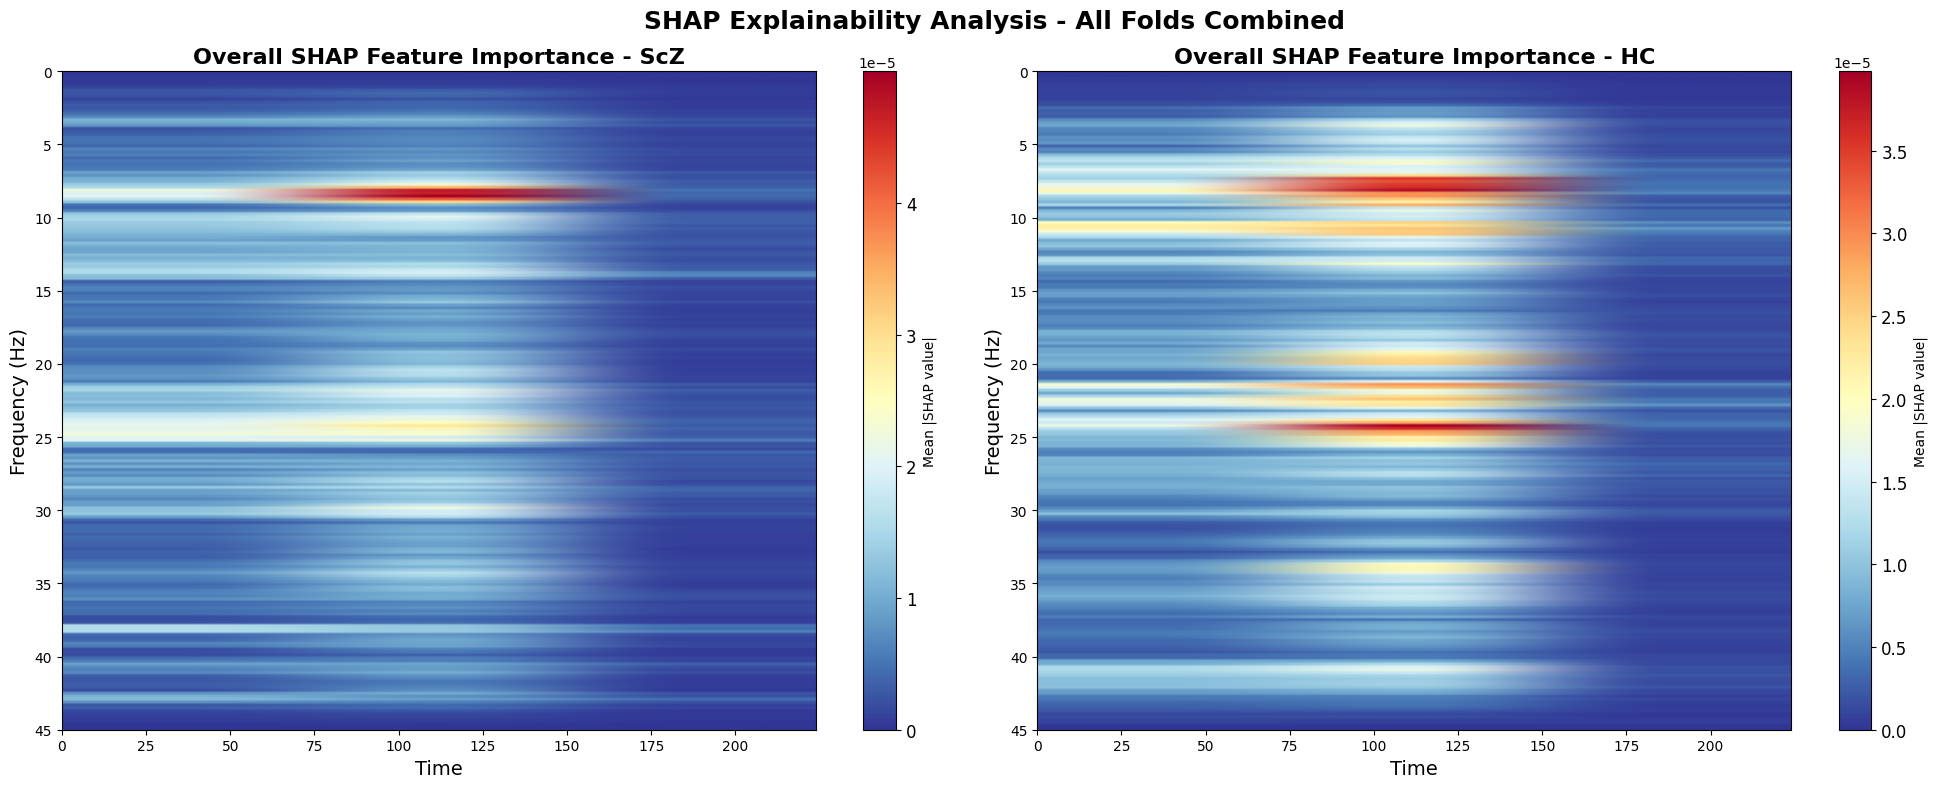

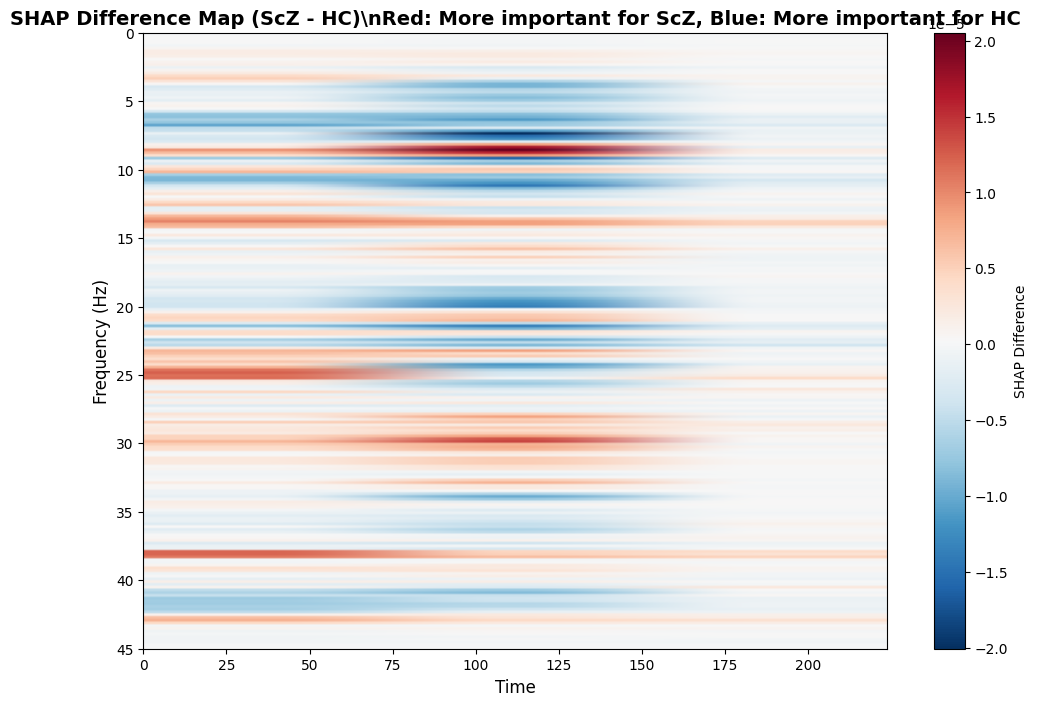


DEBUGGING SHAP VALUES
SHAP Values Debug Information:
Number of classes: 2

Class 0 SHAP values:
  Shape: (224, 224, 3, 2)
  Min value: -0.000641
  Max value: 0.000616
  Mean absolute value: 0.000007
  Standard deviation: 0.000019

Class 1 SHAP values:
  Shape: (224, 224, 3, 2)
  Min value: -0.000653
  Max value: 0.000709
  Mean absolute value: 0.000007
  Standard deviation: 0.000019

Test images shape: (50, 224, 224, 3)
Test images range: -0.454 to 0.507

Test labels shape: (50,)
Test labels unique values: [0 1]

CREATING SIMPLIFIED FEATURE IMPORTANCE PLOT


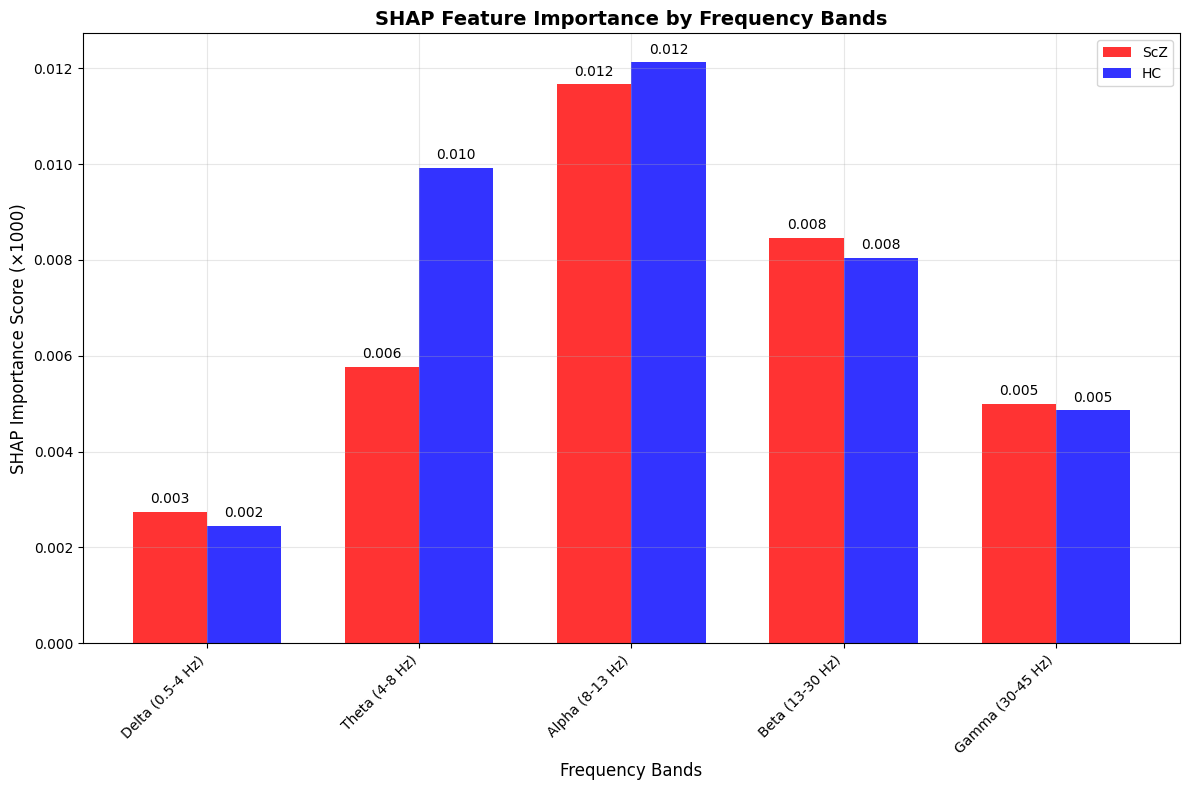

Frequency Band Importance Summary:
--------------------------------------------------
Delta (0.5-4 Hz)    : ScZ=   0.003, HC=   0.002
Theta (4-8 Hz)      : ScZ=   0.006, HC=   0.010
Alpha (8-13 Hz)     : ScZ=   0.012, HC=   0.012
Beta (13-30 Hz)     : ScZ=   0.008, HC=   0.008
Gamma (30-45 Hz)    : ScZ=   0.005, HC=   0.005

Average accuracy across all folds: 99.81% (+/- 0.10%)
SHAP analysis completed and results saved!
Results saved in: D:/Milon2/SHAP/result/Fig


In [ ]:
# Replace the last cell in your notebook with this complete cell:

print("Generating overall SHAP analysis across all folds...")

def create_comprehensive_shap_analysis():
    all_shap_class0 = []
    all_shap_class1 = []
    all_test_images = []
    all_test_labels = []

    for fold_idx in range(len(shap_values_per_fold)):
        shap_fold = shap_values_per_fold[fold_idx]
        images_fold, labels_fold = test_images_per_fold[fold_idx]

        all_shap_class0.append(shap_fold[0])
        all_shap_class1.append(shap_fold[1])
        all_test_images.append(images_fold)
        all_test_labels.append(labels_fold)

    combined_shap_class0 = np.concatenate(all_shap_class0, axis=0)
    combined_shap_class1 = np.concatenate(all_shap_class1, axis=0)
    combined_images = np.concatenate(all_test_images, axis=0)
    combined_labels = np.concatenate(all_test_labels, axis=0)

    # Create the main SHAP heatmap
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    class_names = ['ScZ', 'HC']
    combined_shap = [combined_shap_class0, combined_shap_class1]

    for class_idx in range(2):
        ax = axes[class_idx]
        mean_shap = np.mean(np.abs(combined_shap[class_idx]), axis=0)
        mean_shap_2d = mean_shap.mean(axis=2)

        im = ax.imshow(mean_shap_2d, cmap='RdYlBu_r', aspect='auto', extent=[0, 224, 45, 0])
        ax.set_title(f'Overall SHAP Feature Importance - {class_names[class_idx]}',
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Time', fontsize=14)
        ax.set_ylabel('Frequency (Hz)', fontsize=14)

        cbar = plt.colorbar(im, ax=ax, label='Mean |SHAP value|')
        cbar.ax.tick_params(labelsize=12)

    plt.suptitle('SHAP Explainability Analysis - All Folds Combined', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Create difference map
    plt.figure(figsize=(12, 8))
    mean_shap_0 = np.mean(np.abs(combined_shap_class0), axis=0).mean(axis=2)
    mean_shap_1 = np.mean(np.abs(combined_shap_class1), axis=0).mean(axis=2)
    shap_difference = mean_shap_0 - mean_shap_1

    plt.imshow(shap_difference, cmap='RdBu_r', aspect='auto', extent=[0, 224, 45, 0])
    plt.title('SHAP Difference Map (ScZ - HC)\\nRed: More important for ScZ, Blue: More important for HC',
              fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.colorbar(label='SHAP Difference')
    plt.show()

    return combined_shap, combined_images, combined_labels

# Run the comprehensive analysis
combined_shap_values, combined_test_images, combined_test_labels = create_comprehensive_shap_analysis()

# ADD THE FIXED FUNCTIONS HERE:

def debug_shap_values():
    """Debug function to understand SHAP values structure"""

    print("SHAP Values Debug Information:")
    print("=" * 50)

    print(f"Number of classes: {len(combined_shap_values)}")

    for class_idx, class_shap in enumerate(combined_shap_values):
        print(f"\nClass {class_idx} SHAP values:")
        print(f"  Shape: {class_shap.shape}")
        print(f"  Min value: {class_shap.min():.6f}")
        print(f"  Max value: {class_shap.max():.6f}")
        print(f"  Mean absolute value: {np.mean(np.abs(class_shap)):.6f}")
        print(f"  Standard deviation: {np.std(class_shap):.6f}")

    print(f"\nTest images shape: {combined_test_images.shape}")
    print(f"Test images range: {combined_test_images.min():.3f} to {combined_test_images.max():.3f}")

    print(f"\nTest labels shape: {combined_test_labels.shape}")
    print(f"Test labels unique values: {np.unique(combined_test_labels)}")

def create_simple_importance_plot():
    """Create a simpler feature importance plot focusing on main frequency bands"""

    # Calculate mean SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define main frequency bands (standard EEG bands)
    freq_bands = {
        'Delta (0.5-4 Hz)': (0, int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha (8-13 Hz)': (int(224*8/45), int(224*13/45)),
        'Beta (13-30 Hz)': (int(224*13/45), int(224*30/45)),
        'Gamma (30-45 Hz)': (int(224*30/45), 224)
    }

    importance_scz = []
    importance_hc = []
    band_names = []

    for band_name, (start_freq, end_freq) in freq_bands.items():
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        scz_imp = np.mean(mean_shap_scz_2d[start_freq:end_freq, :]) * 1000
        hc_imp = np.mean(mean_shap_hc_2d[start_freq:end_freq, :]) * 1000

        importance_scz.append(scz_imp)
        importance_hc.append(hc_imp)
        band_names.append(band_name)

    # Create comparison plot
    x = np.arange(len(band_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, importance_scz, width, label='ScZ', alpha=0.8, color='red')
    bars2 = ax.bar(x + width/2, importance_hc, width, label='HC', alpha=0.8, color='blue')

    ax.set_xlabel('Frequency Bands', fontsize=12)
    ax.set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    ax.set_title('SHAP Feature Importance by Frequency Bands', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(band_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if abs(height) > 0.001:  # Only show labels for non-zero bars
                ax.text(bar.get_x() + bar.get_width()/2., height + max(importance_scz + importance_hc)*0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print numerical results
    print("Frequency Band Importance Summary:")
    print("-" * 50)
    for i, band in enumerate(band_names):
        print(f"{band:20s}: ScZ={importance_scz[i]:8.3f}, HC={importance_hc[i]:8.3f}")

# RUN THE DEBUG AND PLOTTING FUNCTIONS:
print("\n" + "="*60)
print("DEBUGGING SHAP VALUES")
print("="*60)
debug_shap_values()

print("\n" + "="*60)
print("CREATING SIMPLIFIED FEATURE IMPORTANCE PLOT")
print("="*60)
create_simple_importance_plot()

# Print final accuracy results
print(f'\nAverage accuracy across all folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Save results
shap_results_dir = "D:/Milon2/SHAP/result/Fig"
os.makedirs(shap_results_dir, exist_ok=True)

np.save(f"{shap_results_dir}/combined_shap_class0.npy", combined_shap_values[0])
np.save(f"{shap_results_dir}/combined_shap_class1.npy", combined_shap_values[1])
np.save(f"{shap_results_dir}/combined_test_images.npy", combined_test_images)
np.save(f"{shap_results_dir}/combined_test_labels.npy", combined_test_labels)

print("SHAP analysis completed and results saved!")
print(f"Results saved in: {shap_results_dir}")

COMPREHENSIVE SHAP FEATURE ANALYSIS

1. DETAILED FREQUENCY BAND ANALYSIS
--------------------------------------------------


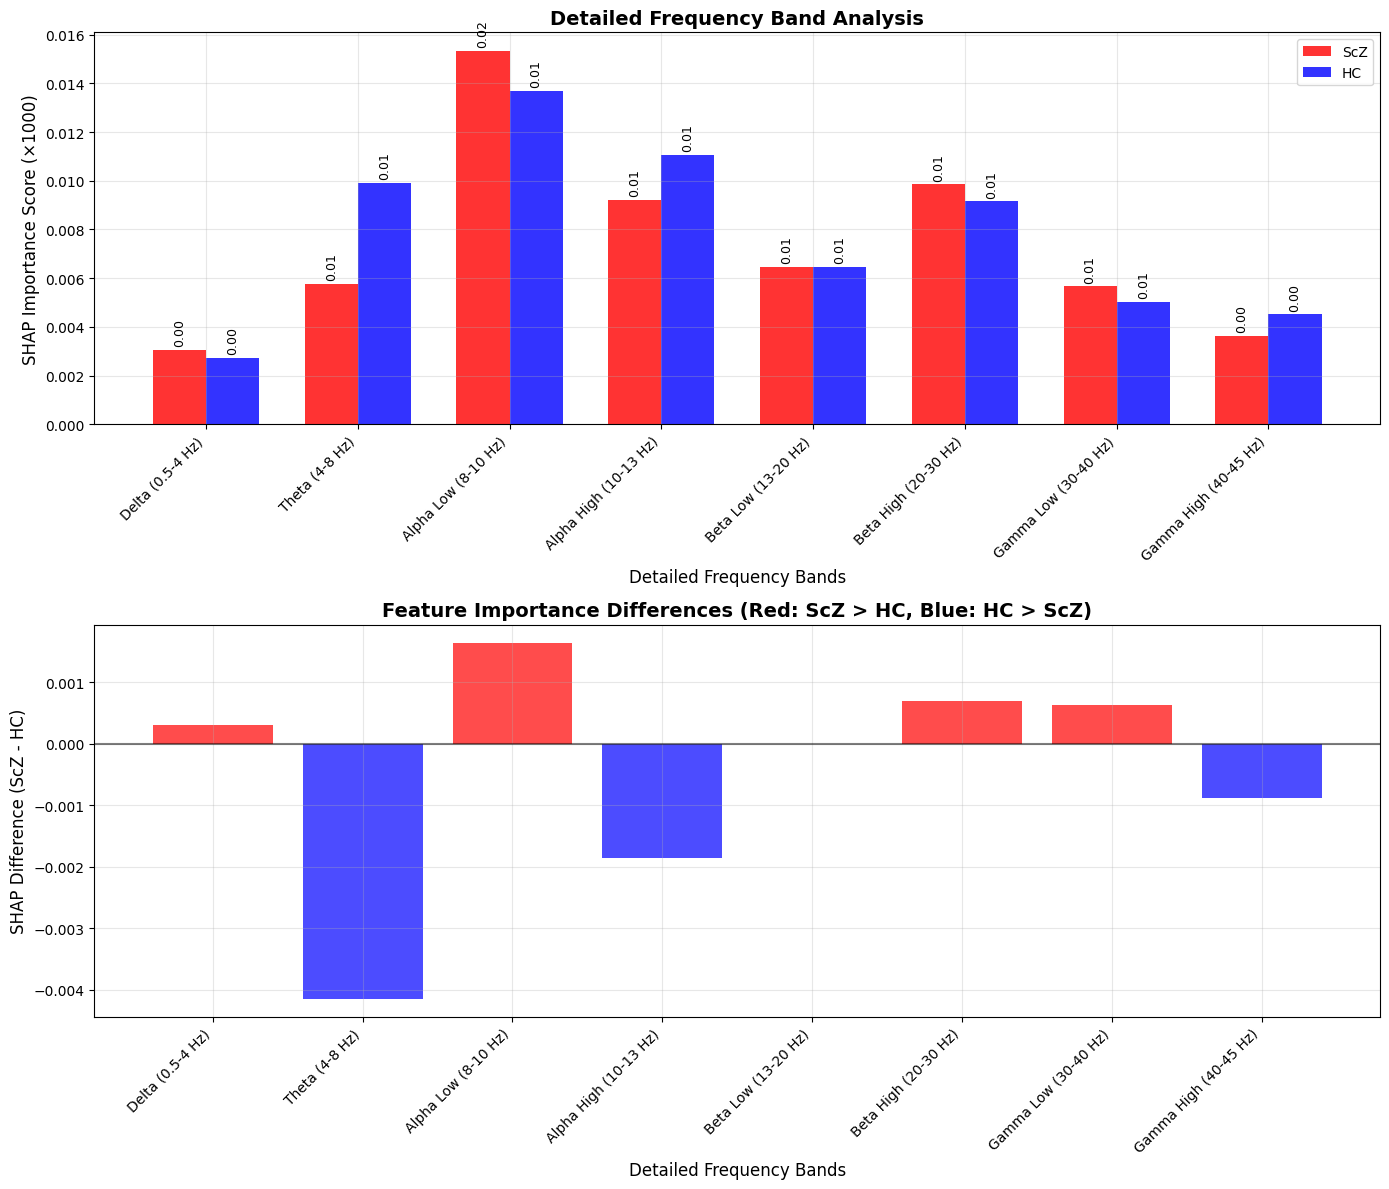


2. TEMPORAL PATTERN ANALYSIS
--------------------------------------------------


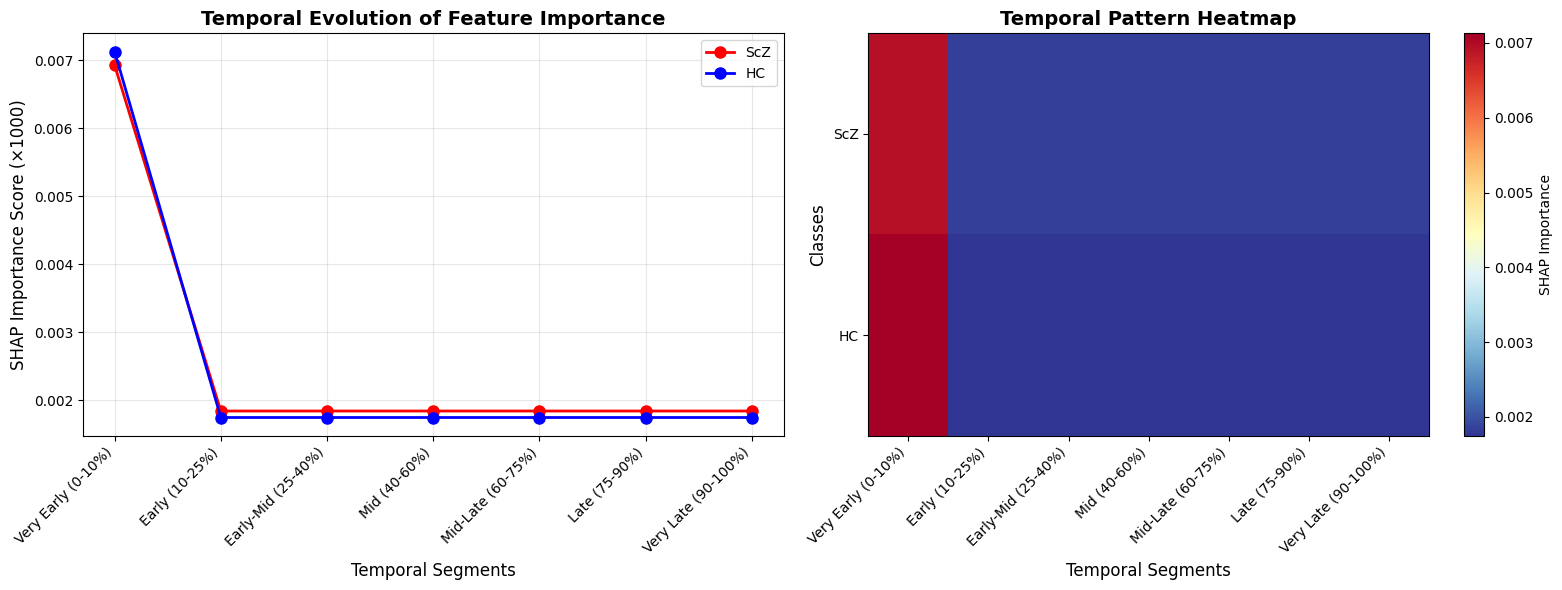


3. SPATIAL REGION ANALYSIS
--------------------------------------------------


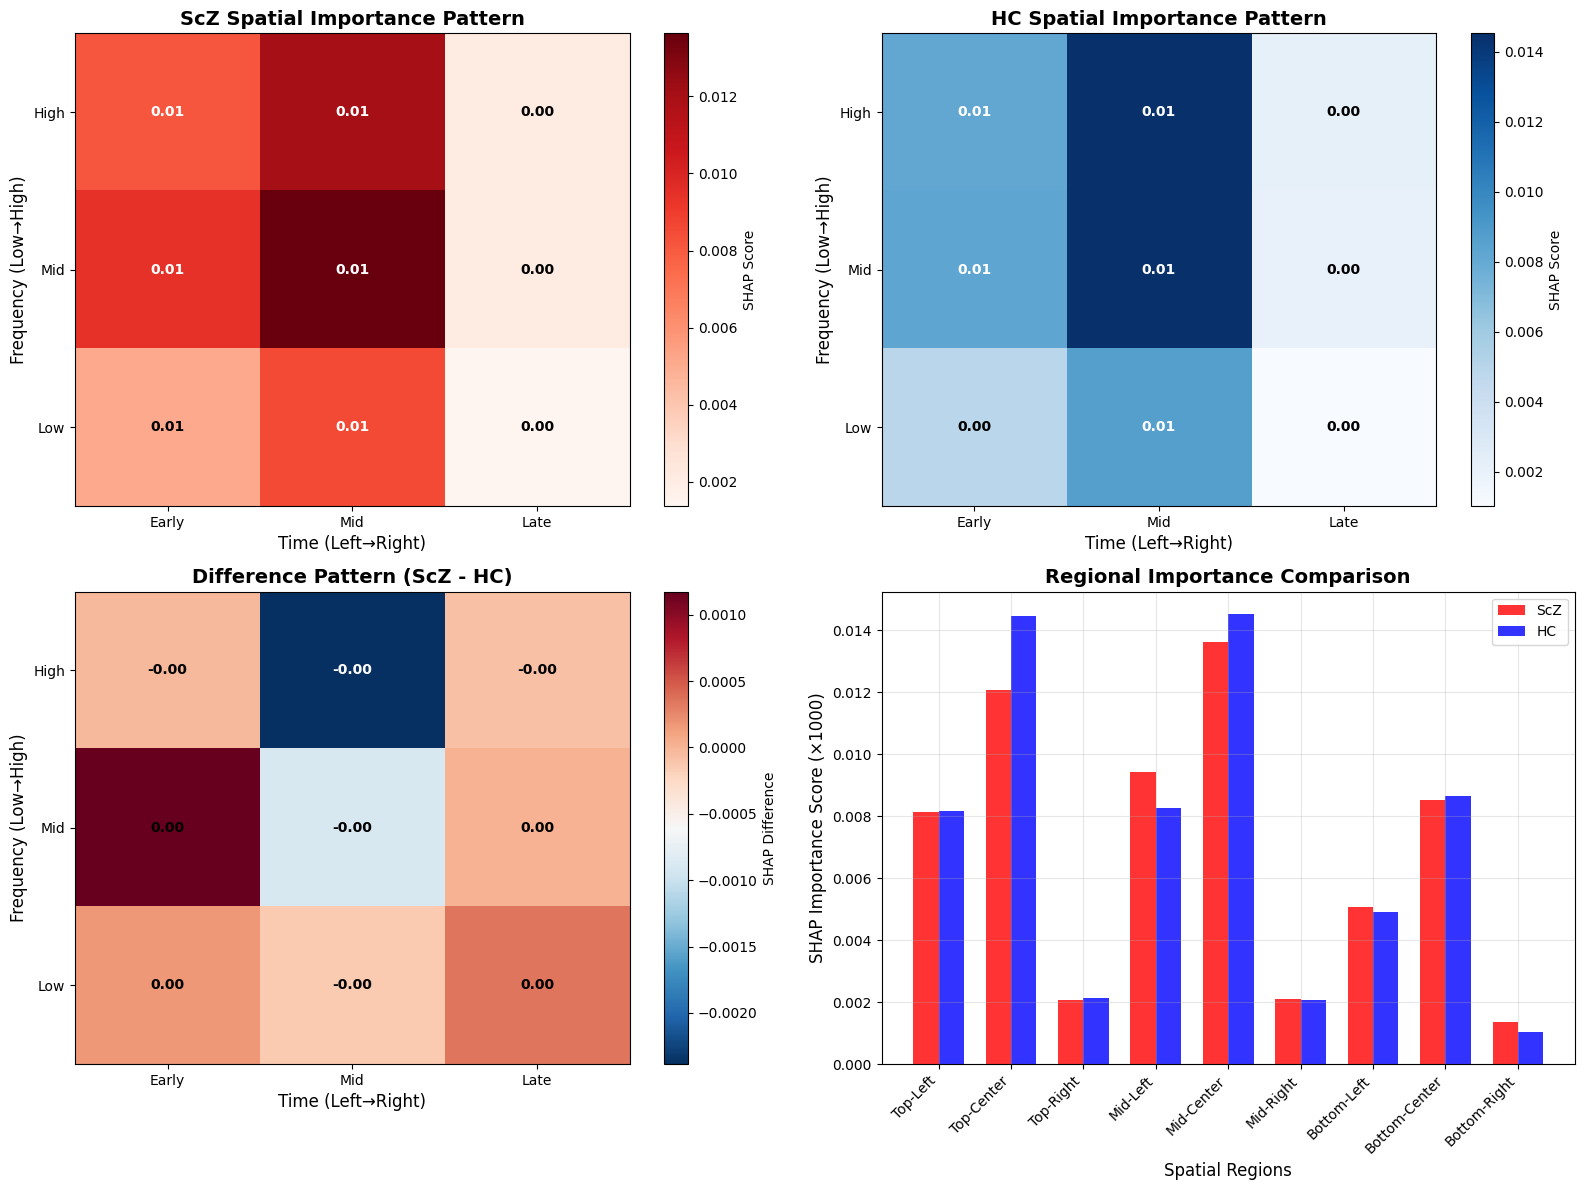


4. STATISTICAL SIGNIFICANCE ANALYSIS
--------------------------------------------------


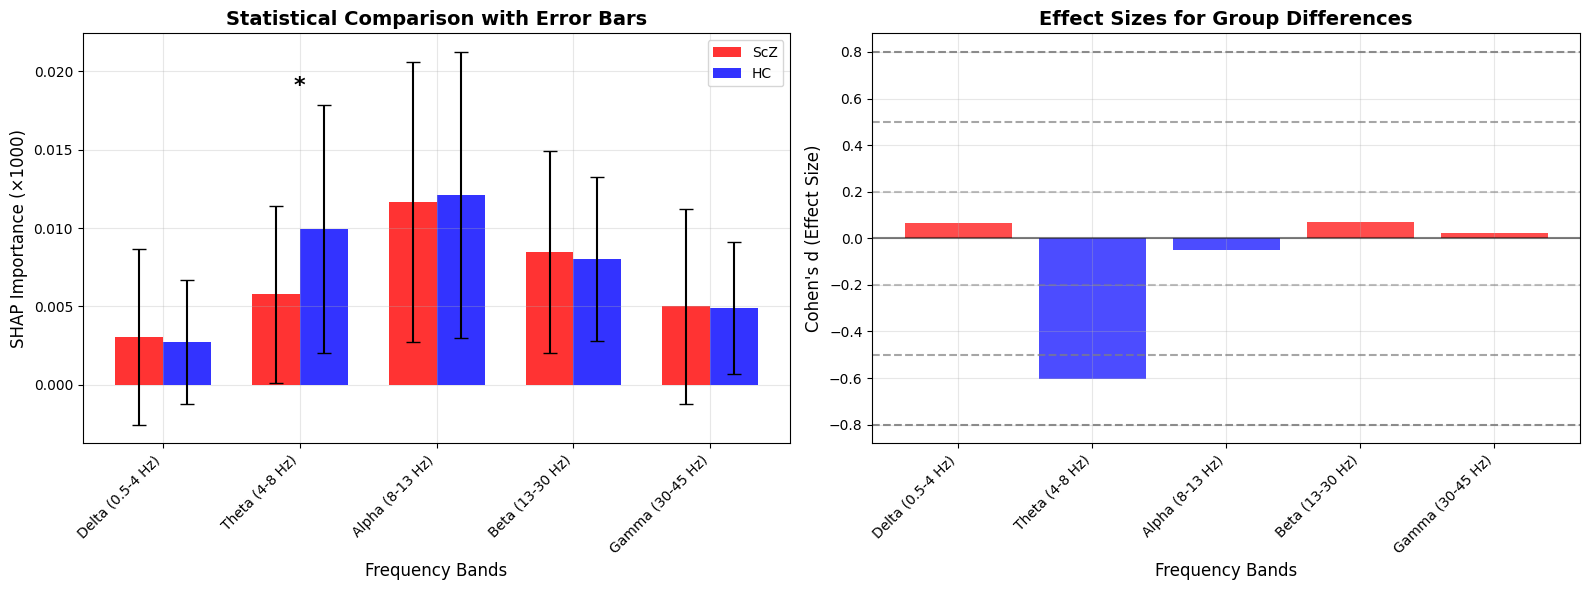


Statistical Significance Analysis:
Band                 ScZ Mean   HC Mean    p-value    Cohen d    Significant
----------------------------------------------------------------------
Delta (0.5-4 Hz)     0.003      0.003      0.496      0.064      
Theta (4-8 Hz)       0.006      0.010      0.000      -0.604     ***
Alpha (8-13 Hz)      0.012      0.012      0.590      -0.051     
Beta (13-30 Hz)      0.008      0.008      0.459      0.070      
Gamma (30-45 Hz)     0.005      0.005      0.801      0.024      

5. MULTI-METRIC FEATURE RANKING
--------------------------------------------------


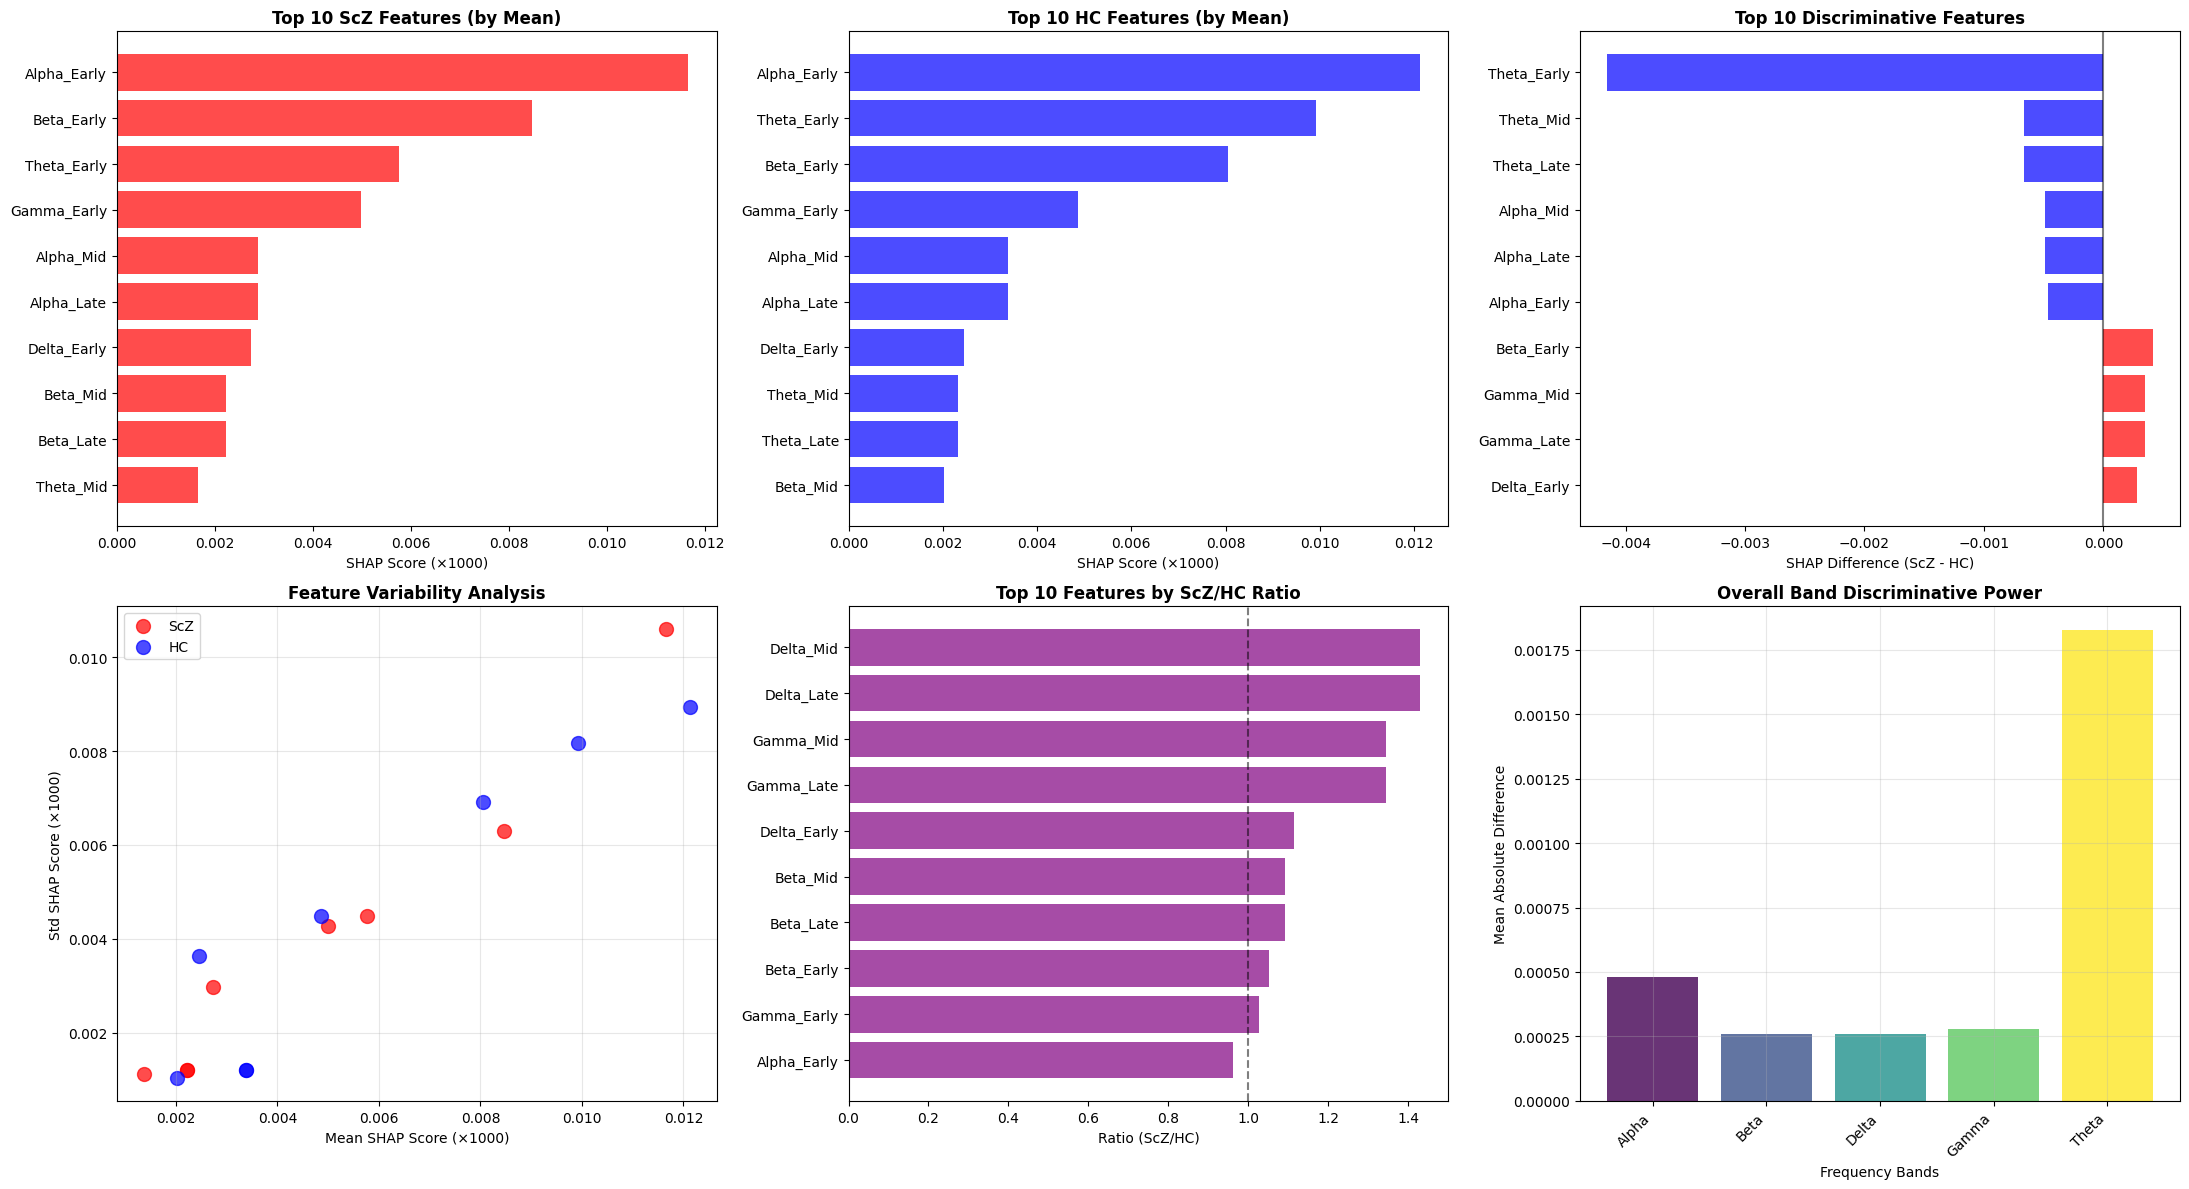


6. INDIVIDUAL SAMPLE VISUALIZATION
--------------------------------------------------


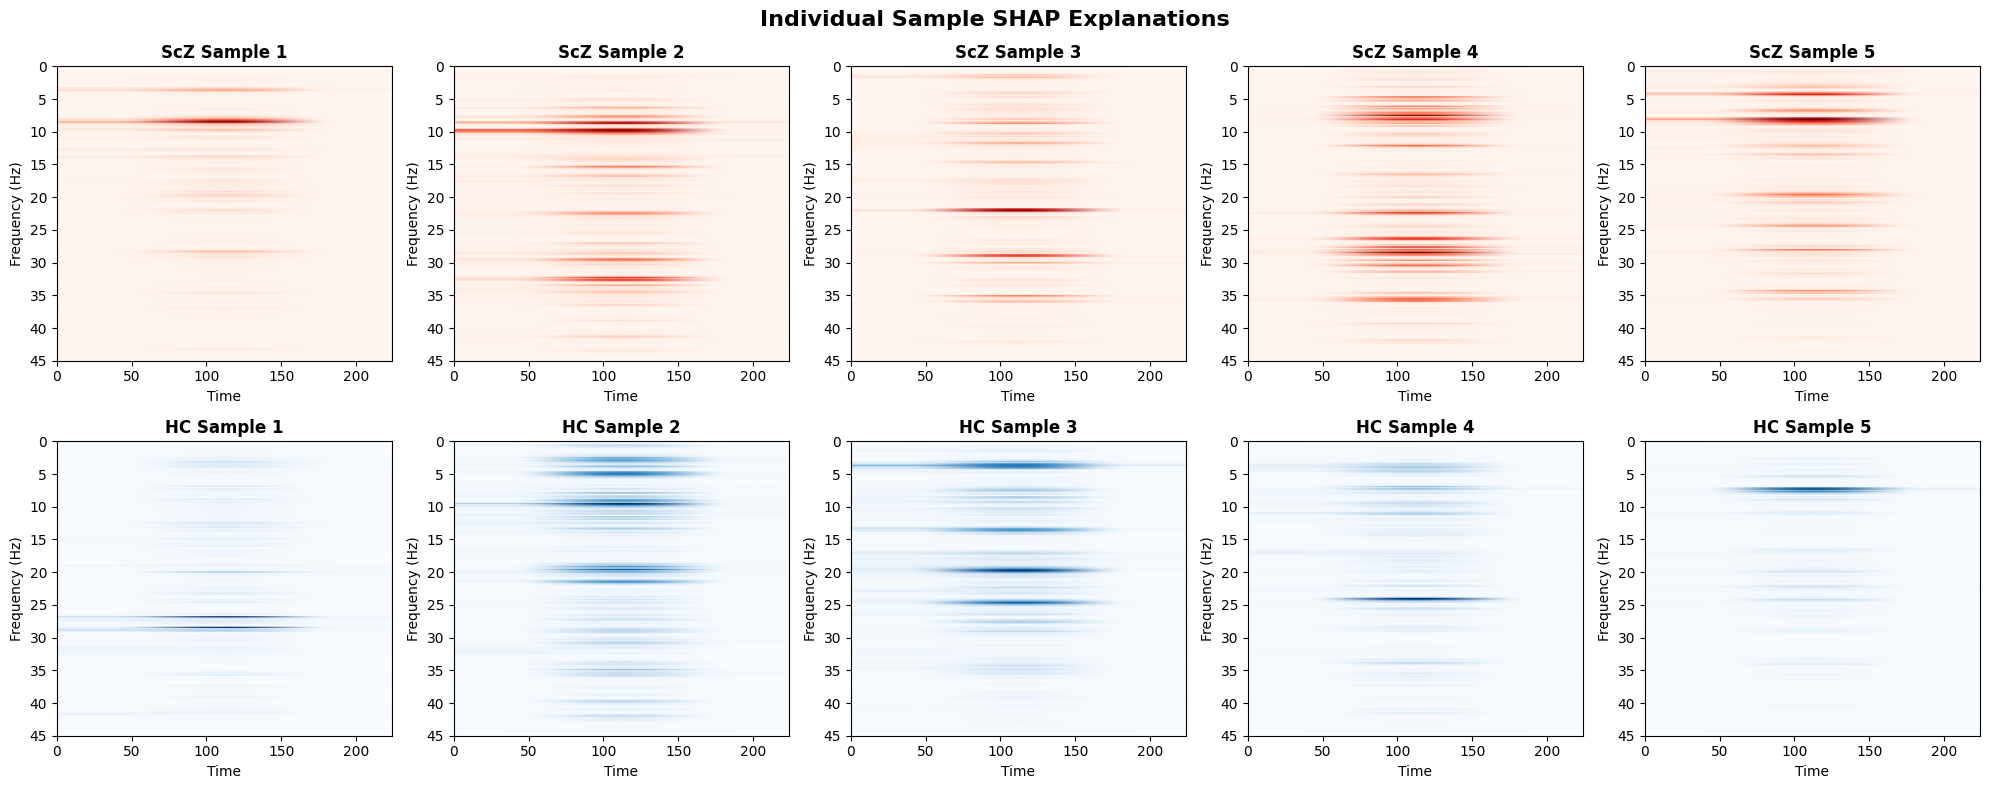


7. DETAILED HEATMAP GRID
--------------------------------------------------


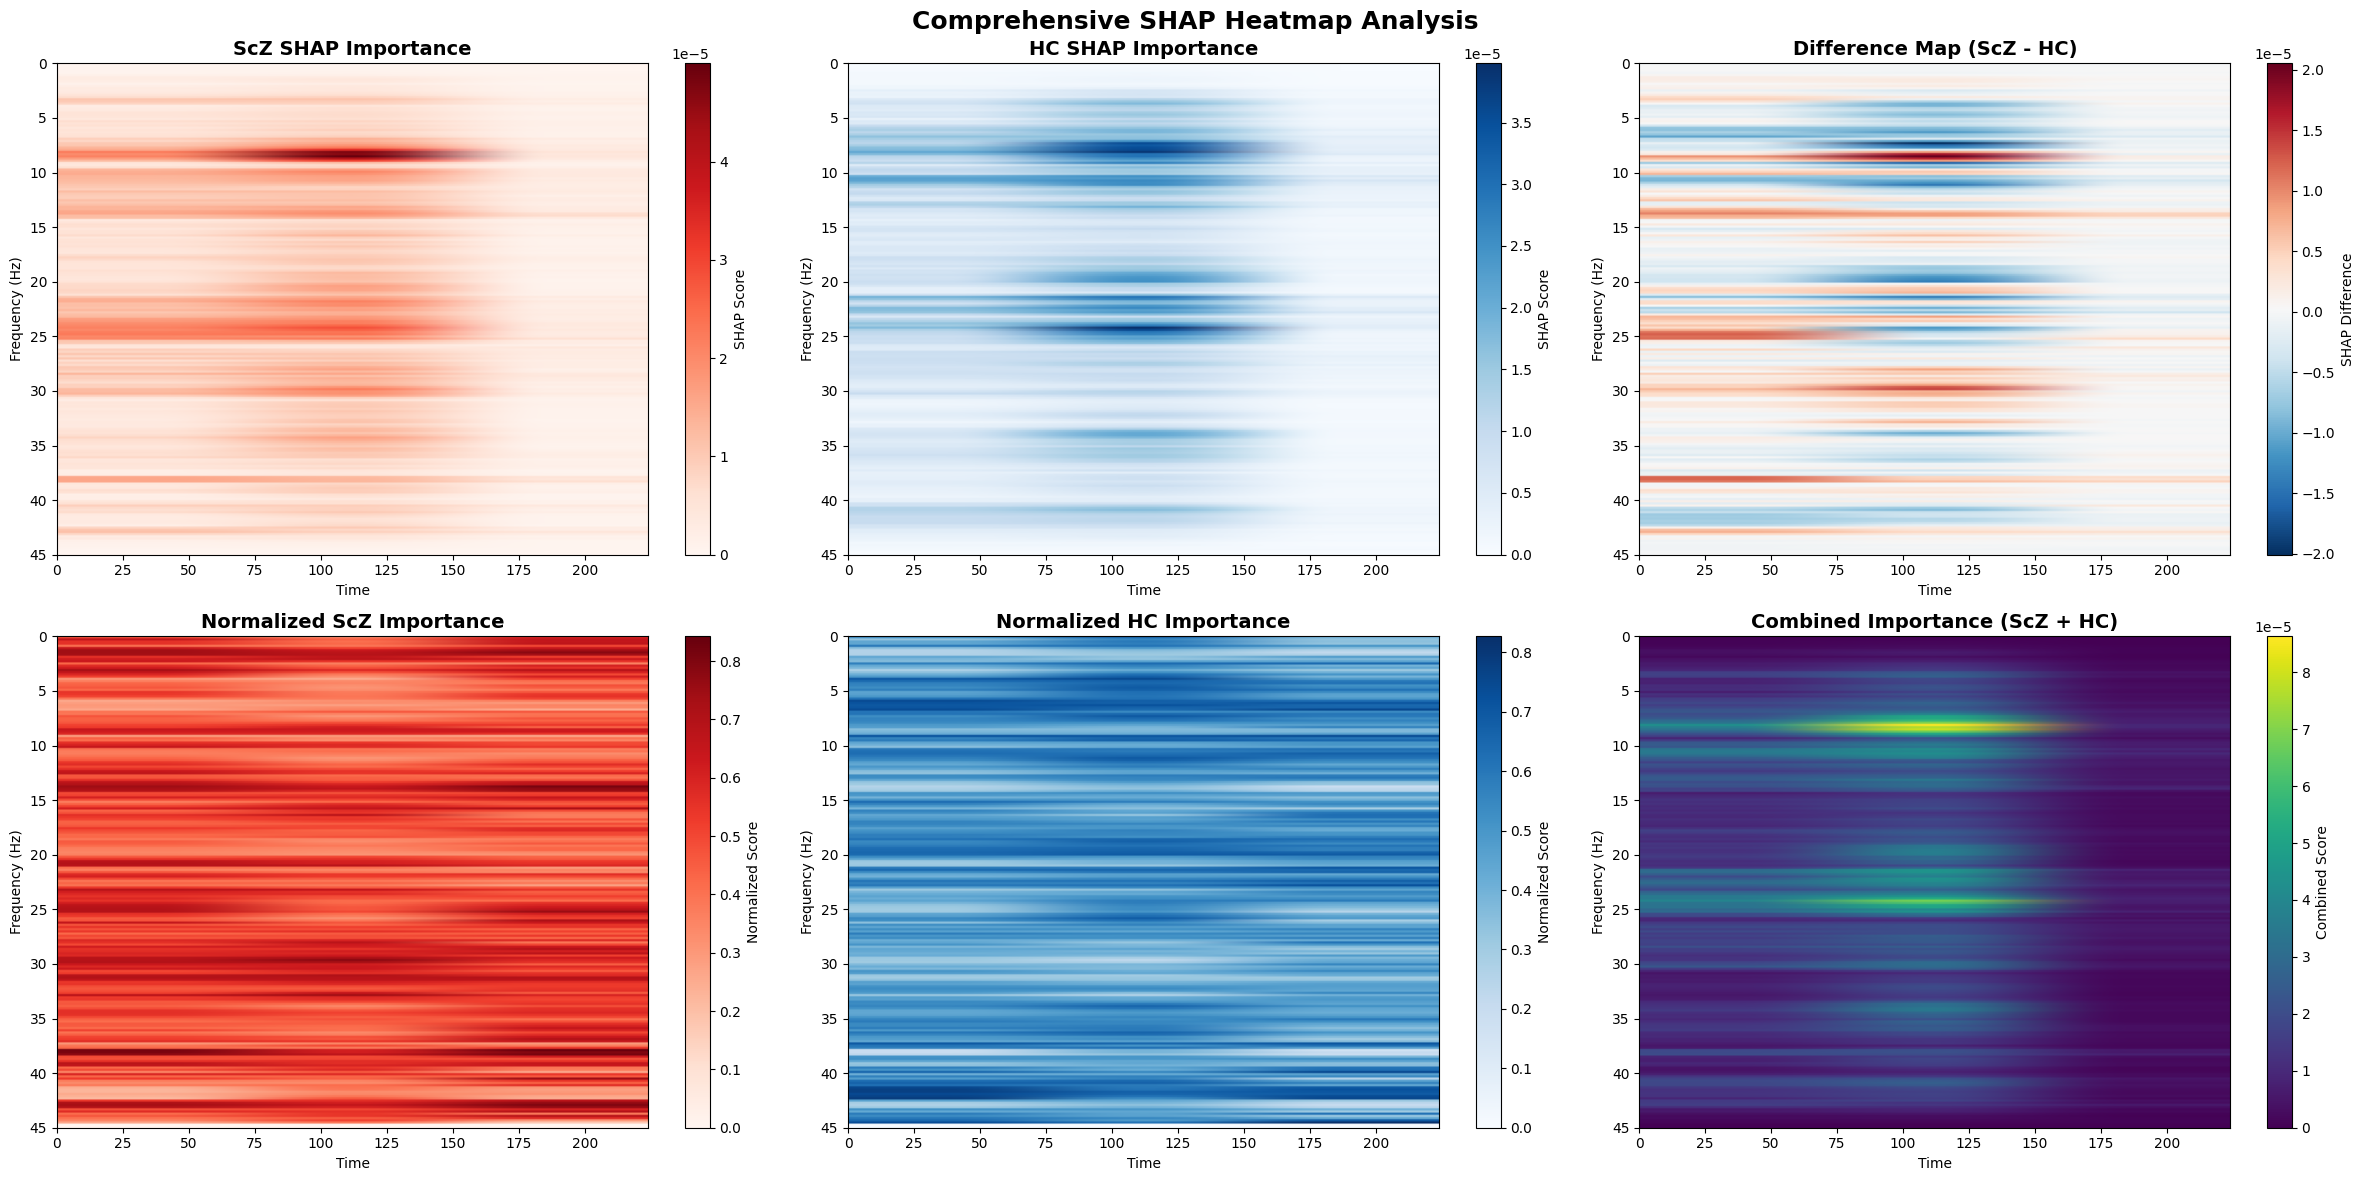


8. PERCENTILE THRESHOLD ANALYSIS
--------------------------------------------------


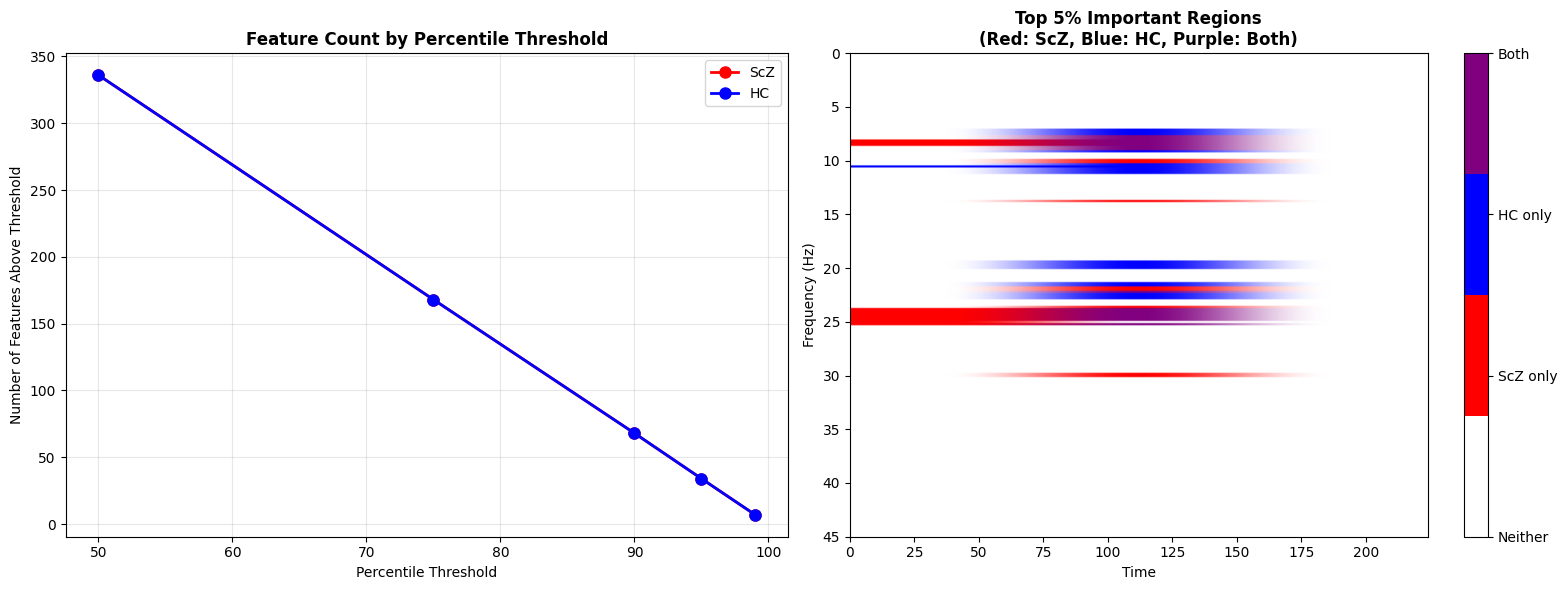


9. CLINICAL PATTERN DETECTION
--------------------------------------------------


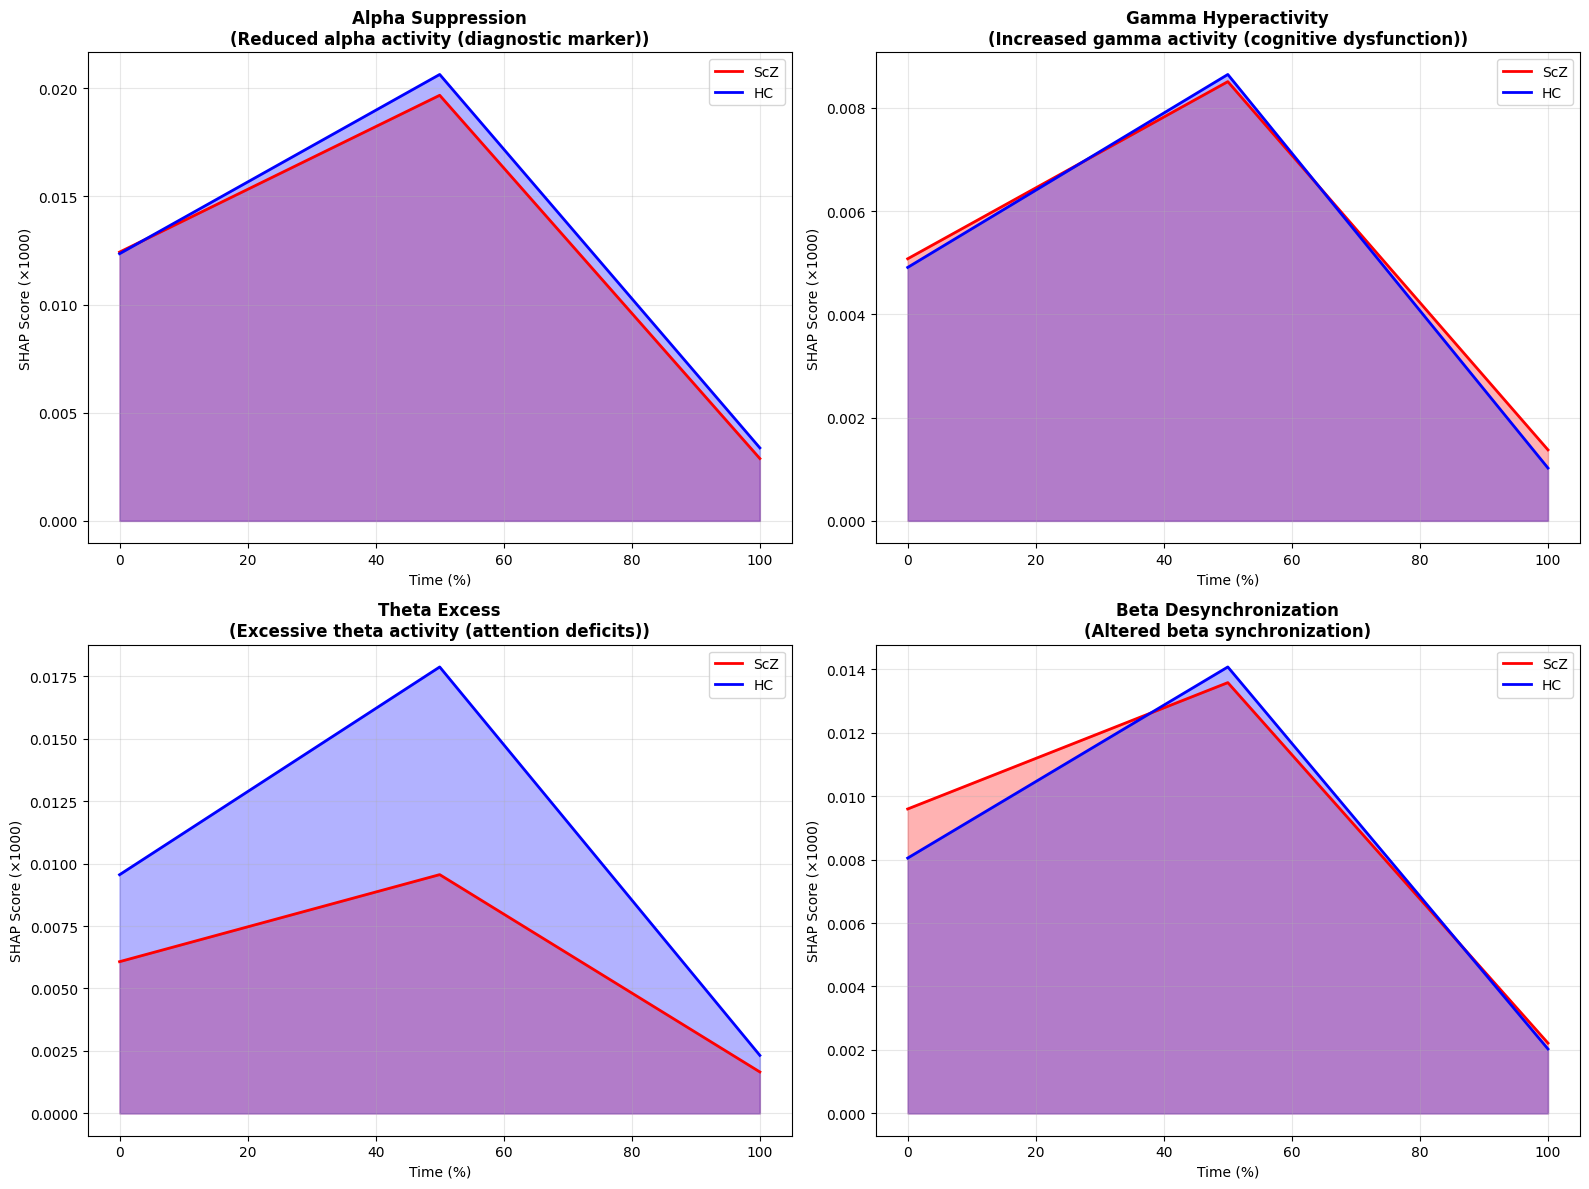


Clinical Pattern Analysis:

Alpha Suppression:
  Expected: Lower in ScZ
  ScZ Mean: 0.012, Peak: 0.020
  HC Mean:  0.012, Peak: 0.021
  Difference (ScZ-HC): -0.000
  ✓ MATCHES expected pattern

Gamma Hyperactivity:
  Expected: Higher in ScZ
  ScZ Mean: 0.005, Peak: 0.009
  HC Mean:  0.005, Peak: 0.009
  Difference (ScZ-HC): 0.000
  ✓ MATCHES expected pattern

Theta Excess:
  Expected: Higher in ScZ
  ScZ Mean: 0.006, Peak: 0.010
  HC Mean:  0.010, Peak: 0.018
  Difference (ScZ-HC): -0.004
  ✗ Does NOT match expected pattern

Beta Desynchronization:
  Expected: Different pattern in ScZ
  ScZ Mean: 0.008, Peak: 0.014
  HC Mean:  0.008, Peak: 0.014
  Difference (ScZ-HC): 0.000
  → Shows different pattern (diff: 0.000)

COMPREHENSIVE ANALYSIS COMPLETED!


In [ ]:
# COMPREHENSIVE SHAP FEATURE ANALYSIS
# Add this as a new cell in your notebook

def create_comprehensive_feature_analysis():
    """Create comprehensive feature analysis with multiple visualizations"""

    # Calculate mean SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    return mean_shap_scz_2d, mean_shap_hc_2d

# 1. DETAILED FREQUENCY BAND ANALYSIS
def analyze_detailed_frequency_bands():
    """Analyze detailed frequency bands with clinical relevance"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # More detailed frequency bands with clinical significance
    detailed_freq_bands = {
        'Delta (0.5-4 Hz)': (int(224*0.5/45), int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha Low (8-10 Hz)': (int(224*8/45), int(224*10/45)),
        'Alpha High (10-13 Hz)': (int(224*10/45), int(224*13/45)),
        'Beta Low (13-20 Hz)': (int(224*13/45), int(224*20/45)),
        'Beta High (20-30 Hz)': (int(224*20/45), int(224*30/45)),
        'Gamma Low (30-40 Hz)': (int(224*30/45), int(224*40/45)),
        'Gamma High (40-45 Hz)': (int(224*40/45), 224)
    }

    importance_scz = []
    importance_hc = []
    band_names = []

    for band_name, (start_freq, end_freq) in detailed_freq_bands.items():
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        scz_imp = np.mean(mean_shap_scz_2d[start_freq:end_freq, :]) * 1000
        hc_imp = np.mean(mean_shap_hc_2d[start_freq:end_freq, :]) * 1000

        importance_scz.append(scz_imp)
        importance_hc.append(hc_imp)
        band_names.append(band_name)

    # Create detailed frequency band plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Bar plot comparison
    x = np.arange(len(band_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, importance_scz, width, label='ScZ', alpha=0.8, color='red')
    bars2 = ax1.bar(x + width/2, importance_hc, width, label='HC', alpha=0.8, color='blue')

    ax1.set_xlabel('Detailed Frequency Bands', fontsize=12)
    ax1.set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    ax1.set_title('Detailed Frequency Band Analysis', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(band_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if abs(height) > 0.001:
                ax1.text(bar.get_x() + bar.get_width()/2., height + max(importance_scz + importance_hc)*0.01,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9, rotation=90)

    # Difference plot
    differences = np.array(importance_scz) - np.array(importance_hc)
    colors = ['red' if d > 0 else 'blue' for d in differences]
    bars3 = ax2.bar(x, differences, color=colors, alpha=0.7)
    ax2.set_xlabel('Detailed Frequency Bands', fontsize=12)
    ax2.set_ylabel('SHAP Difference (ScZ - HC)', fontsize=12)
    ax2.set_title('Feature Importance Differences (Red: ScZ > HC, Blue: HC > ScZ)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(band_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return detailed_freq_bands, importance_scz, importance_hc, differences

# 2. TEMPORAL ANALYSIS
def analyze_temporal_patterns():
    """Analyze temporal patterns in SHAP values"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define multiple temporal segments
    temporal_segments = {
        'Very Early (0-10%)': (0, 22),
        'Early (10-25%)': (22, 56),
        'Early-Mid (25-40%)': (56, 90),
        'Mid (40-60%)': (90, 134),
        'Mid-Late (60-75%)': (134, 168),
        'Late (75-90%)': (168, 202),
        'Very Late (90-100%)': (202, 224)
    }

    temporal_importance_scz = []
    temporal_importance_hc = []
    segment_names = []

    for seg_name, (start_time, end_time) in temporal_segments.items():
        start_time = max(0, min(start_time, mean_shap_scz_2d.shape[1]-1))
        end_time = max(start_time+1, min(end_time, mean_shap_scz_2d.shape[1]))

        scz_imp = np.mean(mean_shap_scz_2d[:, start_time:end_time]) * 1000
        hc_imp = np.mean(mean_shap_hc_2d[:, start_time:end_time]) * 1000

        temporal_importance_scz.append(scz_imp)
        temporal_importance_hc.append(hc_imp)
        segment_names.append(seg_name)

    # Create temporal analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Line plot showing temporal evolution
    time_points = range(len(segment_names))
    ax1.plot(time_points, temporal_importance_scz, 'ro-', label='ScZ', linewidth=2, markersize=8)
    ax1.plot(time_points, temporal_importance_hc, 'bo-', label='HC', linewidth=2, markersize=8)
    ax1.set_xlabel('Temporal Segments', fontsize=12)
    ax1.set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    ax1.set_title('Temporal Evolution of Feature Importance', fontsize=14, fontweight='bold')
    ax1.set_xticks(time_points)
    ax1.set_xticklabels(segment_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Heatmap showing temporal patterns
    temporal_data = np.array([temporal_importance_scz, temporal_importance_hc])
    im = ax2.imshow(temporal_data, cmap='RdYlBu_r', aspect='auto')
    ax2.set_xlabel('Temporal Segments', fontsize=12)
    ax2.set_ylabel('Classes', fontsize=12)
    ax2.set_title('Temporal Pattern Heatmap', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(segment_names)))
    ax2.set_xticklabels(segment_names, rotation=45, ha='right')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['ScZ', 'HC'])
    plt.colorbar(im, ax=ax2, label='SHAP Importance')

    plt.tight_layout()
    plt.show()

    return temporal_segments, temporal_importance_scz, temporal_importance_hc

# 3. FREQUENCY-TIME INTERACTION ANALYSIS
def analyze_frequency_time_interactions():
    """Analyze specific frequency-time combinations of clinical interest"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Clinical frequency-time combinations
    clinical_features = {
        'Early Delta Activity': {'freq': (0, int(224*4/45)), 'time': (0, 56)},
        'Early Theta Activity': {'freq': (int(224*4/45), int(224*8/45)), 'time': (0, 56)},
        'Early Alpha Activity': {'freq': (int(224*8/45), int(224*13/45)), 'time': (0, 56)},
        'Early Beta Activity': {'freq': (int(224*13/45), int(224*30/45)), 'time': (0, 56)},
        'Early Gamma Activity': {'freq': (int(224*30/45), 224), 'time': (0, 56)},

        'Mid Delta Activity': {'freq': (0, int(224*4/45)), 'time': (56, 168)},
        'Mid Theta Activity': {'freq': (int(224*4/45), int(224*8/45)), 'time': (56, 168)},
        'Mid Alpha Activity': {'freq': (int(224*8/45), int(224*13/45)), 'time': (56, 168)},
        'Mid Beta Activity': {'freq': (int(224*13/45), int(224*30/45)), 'time': (56, 168)},
        'Mid Gamma Activity': {'freq': (int(224*30/45), 224), 'time': (56, 168)},

        'Late Delta Activity': {'freq': (0, int(224*4/45)), 'time': (168, 224)},
        'Late Theta Activity': {'freq': (int(224*4/45), int(224*8/45)), 'time': (168, 224)},
        'Late Alpha Activity': {'freq': (int(224*8/45), int(224*13/45)), 'time': (168, 224)},
        'Late Beta Activity': {'freq': (int(224*13/45), int(224*30/45)), 'time': (168, 224)},
        'Late Gamma Activity': {'freq': (int(224*30/45), 224), 'time': (168, 224)},

        # Additional clinical patterns
        'Alpha-Beta Transition': {'freq': (int(224*10/45), int(224*15/45)), 'time': (56, 168)},
        'Beta-Gamma Transition': {'freq': (int(224*25/45), int(224*35/45)), 'time': (56, 168)},
        'High Frequency Burst': {'freq': (int(224*35/45), 224), 'time': (0, 112)},
        'Low Frequency Sustained': {'freq': (0, int(224*8/45)), 'time': (112, 224)},
    }

    feature_scores_scz = []
    feature_scores_hc = []
    feature_names = []

    for feature_name, coords in clinical_features.items():
        freq_range = coords['freq']
        time_range = coords['time']

        # Ensure indices are within bounds
        start_freq = max(0, min(freq_range[0], mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(freq_range[1], mean_shap_scz_2d.shape[0]))
        start_time = max(0, min(time_range[0], mean_shap_scz_2d.shape[1]-1))
        end_time = max(start_time+1, min(time_range[1], mean_shap_scz_2d.shape[1]))

        scz_score = np.mean(mean_shap_scz_2d[start_freq:end_freq, start_time:end_time]) * 1000
        hc_score = np.mean(mean_shap_hc_2d[start_freq:end_freq, start_time:end_time]) * 1000

        feature_scores_scz.append(scz_score)
        feature_scores_hc.append(hc_score)
        feature_names.append(feature_name)

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Top ScZ features
    scz_indices = np.argsort(feature_scores_scz)[::-1]
    top_15_scz = scz_indices[:15]

    y_pos = np.arange(len(top_15_scz))
    bars1 = axes[0,0].barh(y_pos, [feature_scores_scz[i] for i in top_15_scz],
                          color=plt.cm.Reds(np.linspace(0.4, 0.9, len(top_15_scz))))
    axes[0,0].set_yticks(y_pos)
    axes[0,0].set_yticklabels([feature_names[i] for i in top_15_scz], fontsize=10)
    axes[0,0].set_xlabel('SHAP Importance Score (×1000)', fontsize=12)
    axes[0,0].set_title('Top 15 Features for ScZ Classification', fontsize=14, fontweight='bold')
    axes[0,0].invert_yaxis()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Top HC features
    hc_indices = np.argsort(feature_scores_hc)[::-1]
    top_15_hc = hc_indices[:15]

    y_pos = np.arange(len(top_15_hc))
    bars2 = axes[0,1].barh(y_pos, [feature_scores_hc[i] for i in top_15_hc],
                          color=plt.cm.Blues(np.linspace(0.4, 0.9, len(top_15_hc))))
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels([feature_names[i] for i in top_15_hc], fontsize=10)
    axes[0,1].set_xlabel('SHAP Importance Score (×1000)', fontsize=12)
    axes[0,1].set_title('Top 15 Features for HC Classification', fontsize=14, fontweight='bold')
    axes[0,1].invert_yaxis()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Difference analysis
    differences = np.array(feature_scores_scz) - np.array(feature_scores_hc)
    diff_indices = np.argsort(np.abs(differences))[::-1]
    top_15_diff = diff_indices[:15]

    colors_diff = ['red' if differences[i] > 0 else 'blue' for i in top_15_diff]
    y_pos = np.arange(len(top_15_diff))
    bars3 = axes[1,0].barh(y_pos, [differences[i] for i in top_15_diff], color=colors_diff, alpha=0.7)
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels([feature_names[i] for i in top_15_diff], fontsize=10)
    axes[1,0].set_xlabel('SHAP Difference (ScZ - HC)', fontsize=12)
    axes[1,0].set_title('Top 15 Discriminative Features', fontsize=14, fontweight='bold')
    axes[1,0].invert_yaxis()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # 4. Feature correlation matrix
    feature_matrix = np.array([feature_scores_scz, feature_scores_hc])
    correlation_matrix = np.corrcoef(feature_matrix)

    im = axes[1,1].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1,1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    axes[1,1].set_xticks([0, 1])
    axes[1,1].set_yticks([0, 1])
    axes[1,1].set_xticklabels(['ScZ', 'HC'])
    axes[1,1].set_yticklabels(['ScZ', 'HC'])

    # Add correlation values
    for i in range(2):
        for j in range(2):
            axes[1,1].text(j, i, f'{correlation_matrix[i,j]:.3f}',
                          ha='center', va='center', fontsize=12, fontweight='bold')

    plt.colorbar(im, ax=axes[1,1], label='Correlation')

    plt.suptitle('Comprehensive Clinical Feature Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return clinical_features, feature_scores_scz, feature_scores_hc, differences

# 4. REGIONAL ANALYSIS (Spatial Patterns)
def analyze_spatial_regions():
    """Analyze spatial regions of the time-frequency representation"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define spatial regions
    height, width = mean_shap_scz_2d.shape
    regions = {
        'Top-Left': {'freq': (0, height//3), 'time': (0, width//3)},
        'Top-Center': {'freq': (0, height//3), 'time': (width//3, 2*width//3)},
        'Top-Right': {'freq': (0, height//3), 'time': (2*width//3, width)},
        'Mid-Left': {'freq': (height//3, 2*height//3), 'time': (0, width//3)},
        'Mid-Center': {'freq': (height//3, 2*height//3), 'time': (width//3, 2*width//3)},
        'Mid-Right': {'freq': (height//3, 2*height//3), 'time': (2*width//3, width)},
        'Bottom-Left': {'freq': (2*height//3, height), 'time': (0, width//3)},
        'Bottom-Center': {'freq': (2*height//3, height), 'time': (width//3, 2*width//3)},
        'Bottom-Right': {'freq': (2*height//3, height), 'time': (2*width//3, width)},
    }

    region_scores_scz = []
    region_scores_hc = []
    region_names = []

    for region_name, coords in regions.items():
        freq_range = coords['freq']
        time_range = coords['time']

        scz_score = np.mean(mean_shap_scz_2d[freq_range[0]:freq_range[1],
                                           time_range[0]:time_range[1]]) * 1000
        hc_score = np.mean(mean_shap_hc_2d[freq_range[0]:freq_range[1],
                                          time_range[0]:time_range[1]]) * 1000

        region_scores_scz.append(scz_score)
        region_scores_hc.append(hc_score)
        region_names.append(region_name)

    # Create 3x3 grid visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Reshape scores for grid visualization
    scz_grid = np.array(region_scores_scz).reshape(3, 3)
    hc_grid = np.array(region_scores_hc).reshape(3, 3)

    # ScZ spatial pattern
    im1 = axes[0,0].imshow(scz_grid, cmap='Reds', aspect='auto')
    axes[0,0].set_title('ScZ Spatial Importance Pattern', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Time (Left→Right)', fontsize=12)
    axes[0,0].set_ylabel('Frequency (Low→High)', fontsize=12)
    axes[0,0].set_xticks([0, 1, 2])
    axes[0,0].set_xticklabels(['Early', 'Mid', 'Late'])
    axes[0,0].set_yticks([0, 1, 2])
    axes[0,0].set_yticklabels(['High', 'Mid', 'Low'])
    plt.colorbar(im1, ax=axes[0,0], label='SHAP Score')

    # Add values to cells
    for i in range(3):
        for j in range(3):
            axes[0,0].text(j, i, f'{scz_grid[i,j]:.2f}', ha='center', va='center',
                          fontweight='bold', color='white' if scz_grid[i,j] > scz_grid.max()*0.5 else 'black')

    # HC spatial pattern
    im2 = axes[0,1].imshow(hc_grid, cmap='Blues', aspect='auto')
    axes[0,1].set_title('HC Spatial Importance Pattern', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Time (Left→Right)', fontsize=12)
    axes[0,1].set_ylabel('Frequency (Low→High)', fontsize=12)
    axes[0,1].set_xticks([0, 1, 2])
    axes[0,1].set_xticklabels(['Early', 'Mid', 'Late'])
    axes[0,1].set_yticks([0, 1, 2])
    axes[0,1].set_yticklabels(['High', 'Mid', 'Low'])
    plt.colorbar(im2, ax=axes[0,1], label='SHAP Score')

    # Add values to cells
    for i in range(3):
        for j in range(3):
            axes[0,1].text(j, i, f'{hc_grid[i,j]:.2f}', ha='center', va='center',
                          fontweight='bold', color='white' if hc_grid[i,j] > hc_grid.max()*0.5 else 'black')

    # Difference grid
    diff_grid = scz_grid - hc_grid
    im3 = axes[1,0].imshow(diff_grid, cmap='RdBu_r', aspect='auto')
    axes[1,0].set_title('Difference Pattern (ScZ - HC)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Time (Left→Right)', fontsize=12)
    axes[1,0].set_ylabel('Frequency (Low→High)', fontsize=12)
    axes[1,0].set_xticks([0, 1, 2])
    axes[1,0].set_xticklabels(['Early', 'Mid', 'Late'])
    axes[1,0].set_yticks([0, 1, 2])
    axes[1,0].set_yticklabels(['High', 'Mid', 'Low'])
    plt.colorbar(im3, ax=axes[1,0], label='SHAP Difference')

    # Add values to cells
    for i in range(3):
        for j in range(3):
            axes[1,0].text(j, i, f'{diff_grid[i,j]:.2f}', ha='center', va='center',
                          fontweight='bold', color='white' if abs(diff_grid[i,j]) > abs(diff_grid).max()*0.5 else 'black')

    # Regional comparison bar plot
    x = np.arange(len(region_names))
    width = 0.35
    bars1 = axes[1,1].bar(x - width/2, region_scores_scz, width, label='ScZ', alpha=0.8, color='red')
    bars2 = axes[1,1].bar(x + width/2, region_scores_hc, width, label='HC', alpha=0.8, color='blue')

    axes[1,1].set_xlabel('Spatial Regions', fontsize=12)
    axes[1,1].set_ylabel('SHAP Importance Score (×1000)', fontsize=12)
    axes[1,1].set_title('Regional Importance Comparison', fontsize=14, fontweight='bold')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(region_names, rotation=45, ha='right')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return regions, region_scores_scz, region_scores_hc

# 5. STATISTICAL SIGNIFICANCE ANALYSIS
def analyze_statistical_significance():
    """Analyze statistical significance of SHAP differences"""

    from scipy import stats

    # Get raw SHAP values for statistical testing
    shap_scz_raw = combined_shap_values[0]  # Shape: (n_samples, height, width, channels)
    shap_hc_raw = combined_shap_values[1]

    # Calculate sample-wise importance for each frequency band
    freq_bands = {
        'Delta (0.5-4 Hz)': (int(224*0.5/45), int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha (8-13 Hz)': (int(224*8/45), int(224*13/45)),
        'Beta (13-30 Hz)': (int(224*13/45), int(224*30/45)),
        'Gamma (30-45 Hz)': (int(224*30/45), 224)
    }

    statistical_results = {}

    for band_name, (start_freq, end_freq) in freq_bands.items():
        start_freq = max(0, min(start_freq, shap_scz_raw.shape[1]-1))
        end_freq = max(start_freq+1, min(end_freq, shap_scz_raw.shape[1]))

        # Calculate importance per sample
        scz_samples = []
        hc_samples = []

        for sample_idx in range(shap_scz_raw.shape[0]):
            scz_sample_importance = np.mean(np.abs(shap_scz_raw[sample_idx, start_freq:end_freq, :, :]))
            scz_samples.append(scz_sample_importance)

        for sample_idx in range(shap_hc_raw.shape[0]):
            hc_sample_importance = np.mean(np.abs(shap_hc_raw[sample_idx, start_freq:end_freq, :, :]))
            hc_samples.append(hc_sample_importance)

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(scz_samples, hc_samples)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(scz_samples)-1)*np.var(scz_samples) +
                             (len(hc_samples)-1)*np.var(hc_samples)) /
                            (len(scz_samples) + len(hc_samples) - 2))
        cohens_d = (np.mean(scz_samples) - np.mean(hc_samples)) / pooled_std

        statistical_results[band_name] = {
            'scz_mean': np.mean(scz_samples) * 1000,
            'hc_mean': np.mean(hc_samples) * 1000,
            'scz_std': np.std(scz_samples) * 1000,
            'hc_std': np.std(hc_samples) * 1000,
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significant': p_value < 0.05
        }

    # Create statistical visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Error bar plot
    bands = list(statistical_results.keys())
    scz_means = [statistical_results[b]['scz_mean'] for b in bands]
    hc_means = [statistical_results[b]['hc_mean'] for b in bands]
    scz_stds = [statistical_results[b]['scz_std'] for b in bands]
    hc_stds = [statistical_results[b]['hc_std'] for b in bands]

    x = np.arange(len(bands))
    width = 0.35

    bars1 = ax1.bar(x - width/2, scz_means, width, yerr=scz_stds, label='ScZ',
                   alpha=0.8, color='red', capsize=5)
    bars2 = ax1.bar(x + width/2, hc_means, width, yerr=hc_stds, label='HC',
                   alpha=0.8, color='blue', capsize=5)

    ax1.set_xlabel('Frequency Bands', fontsize=12)
    ax1.set_ylabel('SHAP Importance (×1000)', fontsize=12)
    ax1.set_title('Statistical Comparison with Error Bars', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(bands, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add significance markers
    for i, band in enumerate(bands):
        if statistical_results[band]['significant']:
            max_height = max(scz_means[i] + scz_stds[i], hc_means[i] + hc_stds[i])
            ax1.text(i, max_height + max(scz_means + hc_means)*0.05, '*',
                    ha='center', va='bottom', fontsize=16, fontweight='bold')

    # Effect size plot
    effect_sizes = [statistical_results[b]['cohens_d'] for b in bands]
    colors = ['red' if es > 0 else 'blue' for es in effect_sizes]

    bars3 = ax2.bar(x, effect_sizes, color=colors, alpha=0.7)
    ax2.set_xlabel('Frequency Bands', fontsize=12)
    ax2.set_ylabel("Cohen's d (Effect Size)", fontsize=12)
    ax2.set_title('Effect Sizes for Group Differences', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(bands, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add effect size interpretation lines
    ax2.axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Small effect')
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Medium effect')
    ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.9, label='Large effect')
    ax2.axhline(y=-0.2, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.7)
    ax2.axhline(y=-0.8, color='gray', linestyle='--', alpha=0.9)

    plt.tight_layout()
    plt.show()

    # Print statistical results
    print("\nStatistical Significance Analysis:")
    print("=" * 70)
    print(f"{'Band':<20} {'ScZ Mean':<10} {'HC Mean':<10} {'p-value':<10} {'Cohen d':<10} {'Significant'}")
    print("-" * 70)
    for band in bands:
        result = statistical_results[band]
        sig_marker = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['significant'] else ""
        print(f"{band:<20} {result['scz_mean']:<10.3f} {result['hc_mean']:<10.3f} "
              f"{result['p_value']:<10.3f} {result['cohens_d']:<10.3f} {sig_marker}")

    return statistical_results

# 6. INDIVIDUAL SAMPLE ANALYSIS
def analyze_individual_samples(n_samples=10):
    """Analyze individual samples to show SHAP explanations"""

    # Select diverse samples
    scz_indices = np.where(combined_test_labels == 0)[0]
    hc_indices = np.where(combined_test_labels == 1)[0]

    selected_scz = np.random.choice(scz_indices, min(n_samples//2, len(scz_indices)), replace=False)
    selected_hc = np.random.choice(hc_indices, min(n_samples//2, len(hc_indices)), replace=False)

    fig, axes = plt.subplots(2, min(5, n_samples//2), figsize=(20, 8))
    if min(5, n_samples//2) == 1:
        axes = axes.reshape(-1, 1)

    # Plot ScZ samples
    for i, sample_idx in enumerate(selected_scz[:5]):
        if i >= axes.shape[1]:
            break
        sample_shap = np.mean(np.abs(combined_shap_values[0][sample_idx]), axis=2)
        im = axes[0, i].imshow(sample_shap, cmap='Reds', aspect='auto', extent=[0, 224, 45, 0])
        axes[0, i].set_title(f'ScZ Sample {i+1}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel('Frequency (Hz)')

    # Plot HC samples
    for i, sample_idx in enumerate(selected_hc[:5]):
        if i >= axes.shape[1]:
            break
        sample_shap = np.mean(np.abs(combined_shap_values[1][sample_idx]), axis=2)
        im = axes[1, i].imshow(sample_shap, cmap='Blues', aspect='auto', extent=[0, 224, 45, 0])
        axes[1, i].set_title(f'HC Sample {i+1}', fontsize=12, fontweight='bold')
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel('Frequency (Hz)')

    plt.suptitle('Individual Sample SHAP Explanations', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 7. FEATURE RANKING WITH MULTIPLE METRICS
def create_multi_metric_ranking():
    """Create feature ranking using multiple metrics"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define features
    freq_bands = {
        'Delta': (0, int(224*4/45)),
        'Theta': (int(224*4/45), int(224*8/45)),
        'Alpha': (int(224*8/45), int(224*13/45)),
        'Beta': (int(224*13/45), int(224*30/45)),
        'Gamma': (int(224*30/45), 224)
    }

    time_segments = {
        'Early': (0, 75),
        'Mid': (75, 149),
        'Late': (149, 224)
    }

    features_data = []

    for band_name, (start_freq, end_freq) in freq_bands.items():
        for seg_name, (start_time, end_time) in time_segments.items():
            start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
            end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))
            start_time = max(0, min(start_time, mean_shap_scz_2d.shape[1]-1))
            end_time = max(start_time+1, min(end_time, mean_shap_scz_2d.shape[1]))

            # Extract region
            scz_region = mean_shap_scz_2d[start_freq:end_freq, start_time:end_time]
            hc_region = mean_shap_hc_2d[start_freq:end_freq, start_time:end_time]

            feature_name = f"{band_name}_{seg_name}"

            # Calculate multiple metrics
            scz_mean = np.mean(scz_region) * 1000
            hc_mean = np.mean(hc_region) * 1000
            scz_max = np.max(scz_region) * 1000
            hc_max = np.max(hc_region) * 1000
            scz_std = np.std(scz_region) * 1000
            hc_std = np.std(hc_region) * 1000

            difference = scz_mean - hc_mean
            ratio = scz_mean / (hc_mean + 1e-10)  # Avoid division by zero

            features_data.append({
                'feature': feature_name,
                'band': band_name,
                'time': seg_name,
                'scz_mean': scz_mean,
                'hc_mean': hc_mean,
                'scz_max': scz_max,
                'hc_max': hc_max,
                'scz_std': scz_std,
                'hc_std': hc_std,
                'difference': difference,
                'ratio': ratio,
                'abs_difference': abs(difference)
            })

    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(features_data)

    # Create multi-metric visualization
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))

    # 1. Top features by ScZ importance
    top_scz = df.nlargest(10, 'scz_mean')
    y_pos = np.arange(len(top_scz))
    axes[0,0].barh(y_pos, top_scz['scz_mean'], color='red', alpha=0.7)
    axes[0,0].set_yticks(y_pos)
    axes[0,0].set_yticklabels(top_scz['feature'], fontsize=10)
    axes[0,0].set_xlabel('SHAP Score (×1000)')
    axes[0,0].set_title('Top 10 ScZ Features (by Mean)', fontweight='bold')
    axes[0,0].invert_yaxis()

    # 2. Top features by HC importance
    top_hc = df.nlargest(10, 'hc_mean')
    y_pos = np.arange(len(top_hc))
    axes[0,1].barh(y_pos, top_hc['hc_mean'], color='blue', alpha=0.7)
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels(top_hc['feature'], fontsize=10)
    axes[0,1].set_xlabel('SHAP Score (×1000)')
    axes[0,1].set_title('Top 10 HC Features (by Mean)', fontweight='bold')
    axes[0,1].invert_yaxis()

    # 3. Top features by absolute difference
    top_diff = df.nlargest(10, 'abs_difference')
    colors_diff = ['red' if d > 0 else 'blue' for d in top_diff['difference']]
    y_pos = np.arange(len(top_diff))
    axes[0,2].barh(y_pos, top_diff['difference'], color=colors_diff, alpha=0.7)
    axes[0,2].set_yticks(y_pos)
    axes[0,2].set_yticklabels(top_diff['feature'], fontsize=10)
    axes[0,2].set_xlabel('SHAP Difference (ScZ - HC)')
    axes[0,2].set_title('Top 10 Discriminative Features', fontweight='bold')
    axes[0,2].invert_yaxis()
    axes[0,2].axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # 4. Feature variability (by std)
    top_var_scz = df.nlargest(8, 'scz_std')
    top_var_hc = df.nlargest(8, 'hc_std')

    axes[1,0].scatter(top_var_scz['scz_mean'], top_var_scz['scz_std'],
                     color='red', alpha=0.7, s=100, label='ScZ')
    axes[1,0].scatter(top_var_hc['hc_mean'], top_var_hc['hc_std'],
                     color='blue', alpha=0.7, s=100, label='HC')
    axes[1,0].set_xlabel('Mean SHAP Score (×1000)')
    axes[1,0].set_ylabel('Std SHAP Score (×1000)')
    axes[1,0].set_title('Feature Variability Analysis', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 5. Ratio analysis
    top_ratio = df.nlargest(10, 'ratio')
    y_pos = np.arange(len(top_ratio))
    axes[1,1].barh(y_pos, top_ratio['ratio'], color='purple', alpha=0.7)
    axes[1,1].set_yticks(y_pos)
    axes[1,1].set_yticklabels(top_ratio['feature'], fontsize=10)
    axes[1,1].set_xlabel('Ratio (ScZ/HC)')
    axes[1,1].set_title('Top 10 Features by ScZ/HC Ratio', fontweight='bold')
    axes[1,1].invert_yaxis()
    axes[1,1].axvline(x=1, color='black', linestyle='--', alpha=0.5)

    # 6. Band-wise summary
    band_summary = df.groupby('band').agg({
        'scz_mean': 'mean',
        'hc_mean': 'mean',
        'difference': 'mean',
        'abs_difference': 'mean'
    }).reset_index()

    x_bands = np.arange(len(band_summary))
    axes[1,2].bar(x_bands, band_summary['abs_difference'],
                 color=plt.cm.viridis(np.linspace(0, 1, len(band_summary))), alpha=0.8)
    axes[1,2].set_xlabel('Frequency Bands')
    axes[1,2].set_ylabel('Mean Absolute Difference')
    axes[1,2].set_title('Overall Band Discriminative Power', fontweight='bold')
    axes[1,2].set_xticks(x_bands)
    axes[1,2].set_xticklabels(band_summary['band'], rotation=45, ha='right')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df, statistical_results

# 8. HEATMAP GRID ANALYSIS
def create_detailed_heatmap_grid():
    """Create detailed heatmap grid for different aspects"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    fig, axes = plt.subplots(2, 3, figsize=(24, 12))

    # 1. Raw ScZ SHAP values
    im1 = axes[0,0].imshow(mean_shap_scz_2d, cmap='Reds', aspect='auto', extent=[0, 224, 45, 0])
    axes[0,0].set_title('ScZ SHAP Importance', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im1, ax=axes[0,0], label='SHAP Score')

    # 2. Raw HC SHAP values
    im2 = axes[0,1].imshow(mean_shap_hc_2d, cmap='Blues', aspect='auto', extent=[0, 224, 45, 0])
    axes[0,1].set_title('HC SHAP Importance', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im2, ax=axes[0,1], label='SHAP Score')

    # 3. Difference map
    difference_map = mean_shap_scz_2d - mean_shap_hc_2d
    im3 = axes[0,2].imshow(difference_map, cmap='RdBu_r', aspect='auto', extent=[0, 224, 45, 0])
    axes[0,2].set_title('Difference Map (ScZ - HC)', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Time')
    axes[0,2].set_ylabel('Frequency (Hz)')
    plt.colorbar(im3, ax=axes[0,2], label='SHAP Difference')

    # 4. Normalized ScZ (relative to total)
    total_importance = mean_shap_scz_2d + mean_shap_hc_2d + 1e-10
    normalized_scz = mean_shap_scz_2d / total_importance
    im4 = axes[1,0].imshow(normalized_scz, cmap='Reds', aspect='auto', extent=[0, 224, 45, 0])
    axes[1,0].set_title('Normalized ScZ Importance', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im4, ax=axes[1,0], label='Normalized Score')

    # 5. Normalized HC (relative to total)
    normalized_hc = mean_shap_hc_2d / total_importance
    im5 = axes[1,1].imshow(normalized_hc, cmap='Blues', aspect='auto', extent=[0, 224, 45, 0])
    axes[1,1].set_title('Normalized HC Importance', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im5, ax=axes[1,1], label='Normalized Score')

    # 6. Combined importance (sum of both classes)
    combined_importance = mean_shap_scz_2d + mean_shap_hc_2d
    im6 = axes[1,2].imshow(combined_importance, cmap='viridis', aspect='auto', extent=[0, 224, 45, 0])
    axes[1,2].set_title('Combined Importance (ScZ + HC)', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Frequency (Hz)')
    plt.colorbar(im6, ax=axes[1,2], label='Combined Score')

    plt.suptitle('Comprehensive SHAP Heatmap Analysis', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 9. PERCENTILE AND THRESHOLD ANALYSIS
def analyze_percentile_features():
    """Analyze features at different percentile thresholds"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Calculate percentiles
    percentiles = [50, 75, 90, 95, 99]

    scz_percentiles = []
    hc_percentiles = []

    for p in percentiles:
        scz_threshold = np.percentile(mean_shap_scz_2d, p)
        hc_threshold = np.percentile(mean_shap_hc_2d, p)

        scz_above_threshold = np.sum(mean_shap_scz_2d > scz_threshold)
        hc_above_threshold = np.sum(mean_shap_hc_2d > hc_threshold)

        scz_percentiles.append(scz_above_threshold)
        hc_percentiles.append(hc_above_threshold)

    # Plot percentile analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(percentiles, scz_percentiles, 'ro-', linewidth=2, markersize=8, label='ScZ')
    ax1.plot(percentiles, hc_percentiles, 'bo-', linewidth=2, markersize=8, label='HC')
    ax1.set_xlabel('Percentile Threshold')
    ax1.set_ylabel('Number of Features Above Threshold')
    ax1.set_title('Feature Count by Percentile Threshold', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Top regions heatmap
    top_regions_scz = mean_shap_scz_2d > np.percentile(mean_shap_scz_2d, 95)
    top_regions_hc = mean_shap_hc_2d > np.percentile(mean_shap_hc_2d, 95)

    combined_top = top_regions_scz.astype(int) + top_regions_hc.astype(int) * 2
    # 0: Neither, 1: ScZ only, 2: HC only, 3: Both

    colors = ['white', 'red', 'blue', 'purple']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = ax2.imshow(combined_top, cmap=cmap, aspect='auto', extent=[0, 224, 45, 0])
    ax2.set_title('Top 5% Important Regions\n(Red: ScZ, Blue: HC, Purple: Both)', fontweight='bold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Frequency (Hz)')

    # Create custom colorbar
    cbar = plt.colorbar(im, ax=ax2, ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Neither', 'ScZ only', 'HC only', 'Both'])

    plt.tight_layout()
    plt.show()

# 10. CLINICAL PATTERN DETECTION
def detect_clinical_patterns():
    """Detect clinically relevant patterns in SHAP values"""

    mean_shap_scz_2d, mean_shap_hc_2d = create_comprehensive_feature_analysis()

    # Define clinical patterns of interest
    clinical_patterns = {
        'Alpha Suppression': {
            'description': 'Reduced alpha activity (diagnostic marker)',
            'freq_range': (int(224*8/45), int(224*13/45)),
            'expected': 'Lower in ScZ'
        },
        'Gamma Hyperactivity': {
            'description': 'Increased gamma activity (cognitive dysfunction)',
            'freq_range': (int(224*30/45), 224),
            'expected': 'Higher in ScZ'
        },
        'Theta Excess': {
            'description': 'Excessive theta activity (attention deficits)',
            'freq_range': (int(224*4/45), int(224*8/45)),
            'expected': 'Higher in ScZ'
        },
        'Beta Desynchronization': {
            'description': 'Altered beta synchronization',
            'freq_range': (int(224*13/45), int(224*30/45)),
            'expected': 'Different pattern in ScZ'
        }
    }

    pattern_results = {}

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, (pattern_name, pattern_info) in enumerate(clinical_patterns.items()):
        start_freq, end_freq = pattern_info['freq_range']
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        # Extract pattern region
        scz_pattern = mean_shap_scz_2d[start_freq:end_freq, :]
        hc_pattern = mean_shap_hc_2d[start_freq:end_freq, :]

        # Calculate temporal evolution
        scz_temporal = np.mean(scz_pattern, axis=0) * 1000
        hc_temporal = np.mean(hc_pattern, axis=0) * 1000

        # Plot temporal evolution
        time_points = np.linspace(0, 100, len(scz_temporal))
        axes[idx].plot(time_points, scz_temporal, 'r-', linewidth=2, label='ScZ')
        axes[idx].plot(time_points, hc_temporal, 'b-', linewidth=2, label='HC')
        axes[idx].fill_between(time_points, scz_temporal, alpha=0.3, color='red')
        axes[idx].fill_between(time_points, hc_temporal, alpha=0.3, color='blue')

        axes[idx].set_xlabel('Time (%)')
        axes[idx].set_ylabel('SHAP Score (×1000)')
        axes[idx].set_title(f'{pattern_name}\n({pattern_info["description"]})', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

        # Store results
        pattern_results[pattern_name] = {
            'scz_mean': np.mean(scz_temporal),
            'hc_mean': np.mean(hc_temporal),
            'scz_peak': np.max(scz_temporal),
            'hc_peak': np.max(hc_temporal),
            'difference': np.mean(scz_temporal) - np.mean(hc_temporal),
            'expected': pattern_info['expected']
        }

    plt.tight_layout()
    plt.show()

    # Print clinical pattern summary
    print("\nClinical Pattern Analysis:")
    print("=" * 80)
    for pattern_name, results in pattern_results.items():
        print(f"\n{pattern_name}:")
        print(f"  Expected: {results['expected']}")
        print(f"  ScZ Mean: {results['scz_mean']:.3f}, Peak: {results['scz_peak']:.3f}")
        print(f"  HC Mean:  {results['hc_mean']:.3f}, Peak: {results['hc_peak']:.3f}")
        print(f"  Difference (ScZ-HC): {results['difference']:.3f}")

        if 'Lower in ScZ' in results['expected'] and results['difference'] < 0:
            print("  ✓ MATCHES expected pattern")
        elif 'Higher in ScZ' in results['expected'] and results['difference'] > 0:
            print("  ✓ MATCHES expected pattern")
        elif 'Different' in results['expected']:
            print(f"  → Shows different pattern (diff: {results['difference']:.3f})")
        else:
            print("  ✗ Does NOT match expected pattern")

    return pattern_results

# RUN ALL ANALYSES
print("=" * 80)
print("COMPREHENSIVE SHAP FEATURE ANALYSIS")
print("=" * 80)

print("\n1. DETAILED FREQUENCY BAND ANALYSIS")
print("-" * 50)
detailed_bands, scz_scores, hc_scores, differences = analyze_detailed_frequency_bands()

print("\n2. TEMPORAL PATTERN ANALYSIS")
print("-" * 50)
temporal_results = analyze_temporal_patterns()

print("\n3. SPATIAL REGION ANALYSIS")
print("-" * 50)
spatial_results = analyze_spatial_regions()

print("\n4. STATISTICAL SIGNIFICANCE ANALYSIS")
print("-" * 50)
statistical_results = analyze_statistical_significance()

print("\n5. MULTI-METRIC FEATURE RANKING")
print("-" * 50)
features_df, multi_stats = create_multi_metric_ranking()

print("\n6. INDIVIDUAL SAMPLE VISUALIZATION")
print("-" * 50)
analyze_individual_samples(n_samples=10)

print("\n7. DETAILED HEATMAP GRID")
print("-" * 50)
create_detailed_heatmap_grid()

print("\n8. PERCENTILE THRESHOLD ANALYSIS")
print("-" * 50)
analyze_percentile_features()

print("\n9. CLINICAL PATTERN DETECTION")
print("-" * 50)
clinical_results = detect_clinical_patterns()

print("\n" + "=" * 80)
print("COMPREHENSIVE ANALYSIS COMPLETED!")
print("=" * 80)


GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION


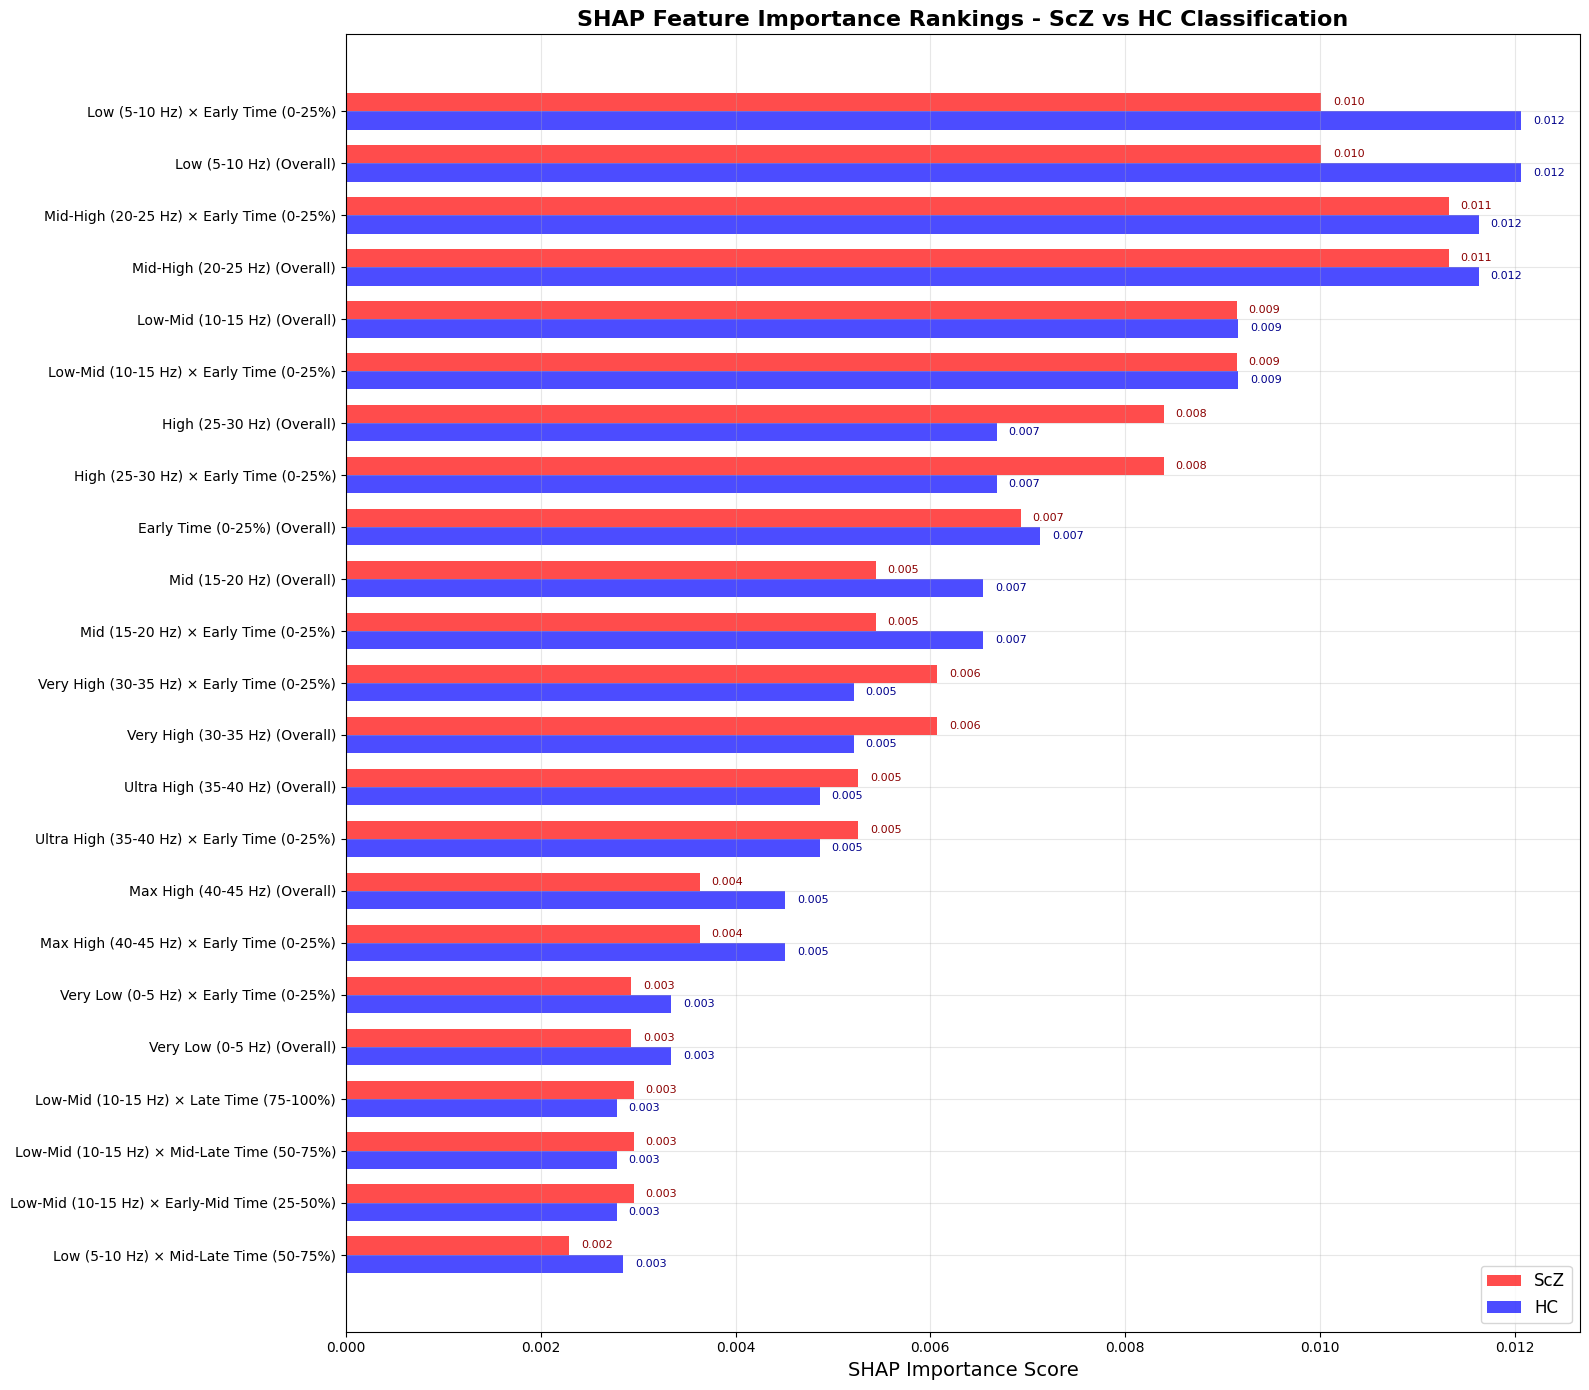

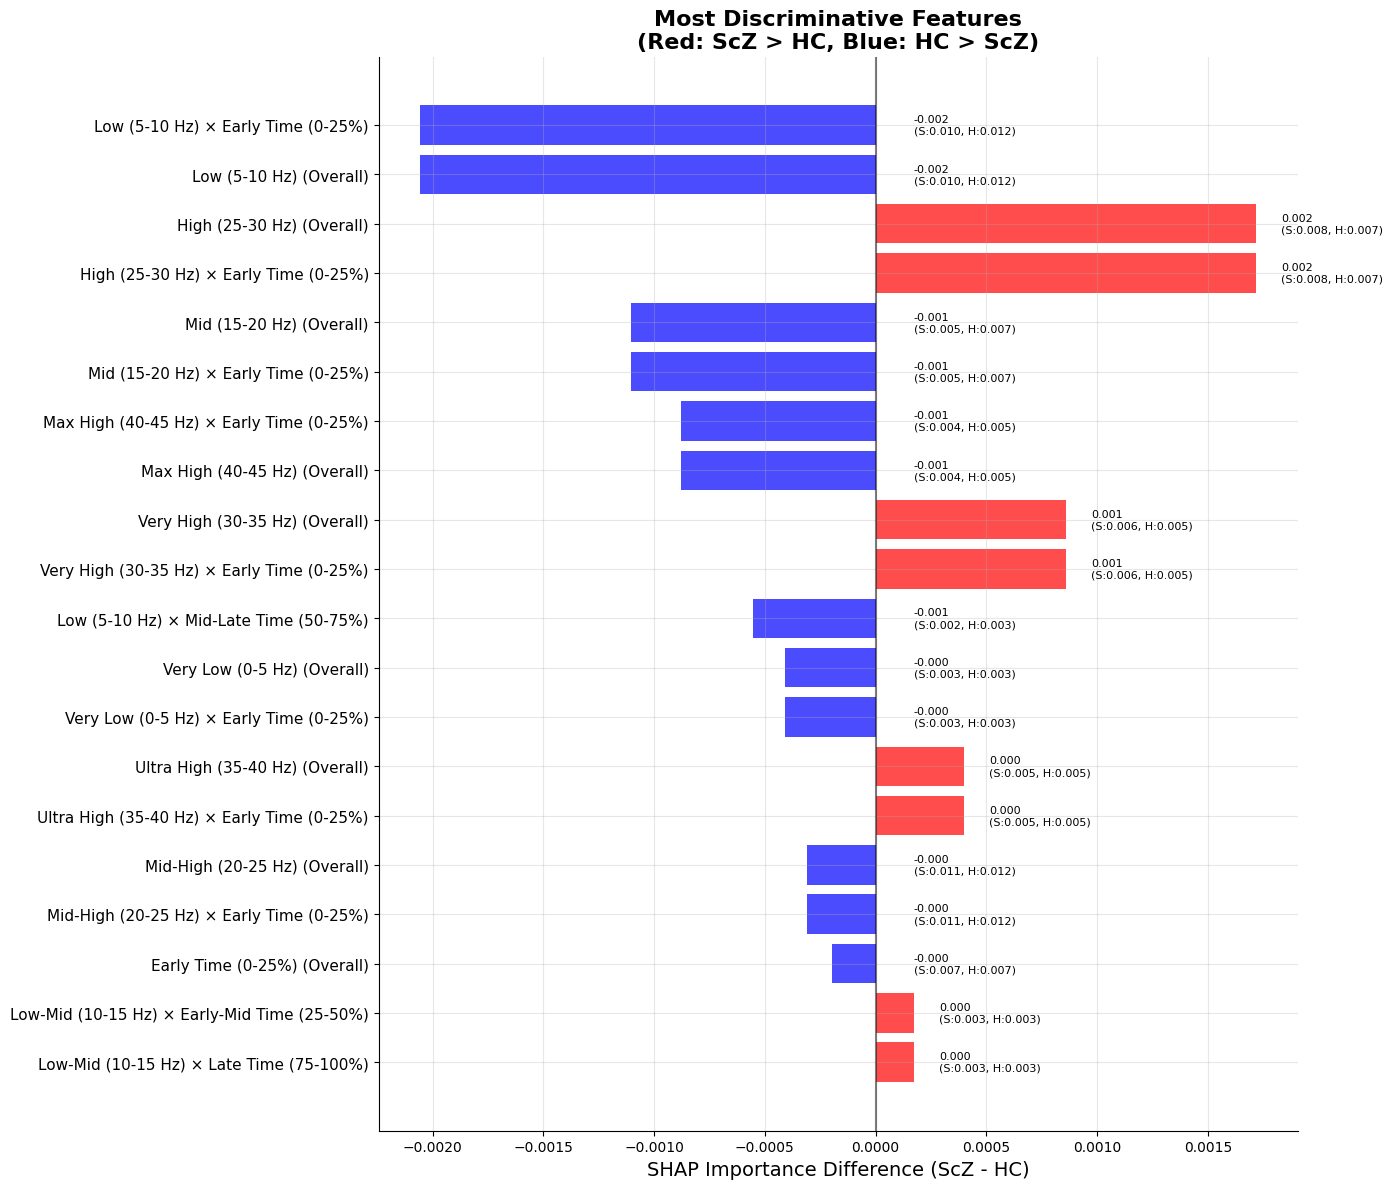


FINAL FEATURE IMPORTANCE RANKINGS

Top 15 features for ScZ classification:
------------------------------------------------------------
 1. Mid-High (20-25 Hz) (Overall)                 :   0.0113
 2. Mid-High (20-25 Hz) × Early Time (0-25%)      :   0.0113
 3. Low (5-10 Hz) (Overall)                       :   0.0100
 4. Low (5-10 Hz) × Early Time (0-25%)            :   0.0100
 5. Low-Mid (10-15 Hz) (Overall)                  :   0.0091
 6. Low-Mid (10-15 Hz) × Early Time (0-25%)       :   0.0091
 7. High (25-30 Hz) × Early Time (0-25%)          :   0.0084
 8. High (25-30 Hz) (Overall)                     :   0.0084
 9. Early Time (0-25%) (Overall)                  :   0.0069
10. Very High (30-35 Hz) (Overall)                :   0.0061
11. Very High (30-35 Hz) × Early Time (0-25%)     :   0.0061
12. Mid (15-20 Hz) × Early Time (0-25%)           :   0.0054
13. Mid (15-20 Hz) (Overall)                      :   0.0054
14. Ultra High (35-40 Hz) (Overall)               :   0.0053
15. Ultra

In [ ]:
# FINAL SHAP FEATURE RANKING PLOT
# Add this as the last cell in your notebook

def create_final_feature_ranking_plot():
    """Create the final comprehensive feature ranking plot"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define comprehensive frequency bands
    freq_bands = {
        'Very Low (0-5 Hz)': (0, int(224*5/45)),
        'Low (5-10 Hz)': (int(224*5/45), int(224*10/45)),
        'Low-Mid (10-15 Hz)': (int(224*10/45), int(224*15/45)),
        'Mid (15-20 Hz)': (int(224*15/45), int(224*20/45)),
        'Mid-High (20-25 Hz)': (int(224*20/45), int(224*25/45)),
        'High (25-30 Hz)': (int(224*25/45), int(224*30/45)),
        'Very High (30-35 Hz)': (int(224*30/45), int(224*35/45)),
        'Ultra High (35-40 Hz)': (int(224*35/45), int(224*40/45)),
        'Max High (40-45 Hz)': (int(224*40/45), 224)
    }

    time_segments = {
        'Early Time (0-25%)': (0, 56),
        'Early-Mid Time (25-50%)': (56, 112),
        'Mid-Late Time (50-75%)': (112, 168),
        'Late Time (75-100%)': (168, 224)
    }

    # Calculate all features
    feature_importance_scz = {}
    feature_importance_hc = {}

    # Frequency-Time combinations
    for band_name, (start_freq, end_freq) in freq_bands.items():
        for seg_name, (start_time, end_time) in time_segments.items():
            feature_name = f"{band_name} × {seg_name}"

            # Ensure indices are within bounds
            start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
            end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))
            start_time = max(0, min(start_time, mean_shap_scz_2d.shape[1]-1))
            end_time = max(start_time+1, min(end_time, mean_shap_scz_2d.shape[1]))

            scz_importance = np.mean(mean_shap_scz_2d[start_freq:end_freq, start_time:end_time])
            hc_importance = np.mean(mean_shap_hc_2d[start_freq:end_freq, start_time:end_time])

            feature_importance_scz[feature_name] = scz_importance
            feature_importance_hc[feature_name] = hc_importance

    # Overall frequency bands
    for band_name, (start_freq, end_freq) in freq_bands.items():
        start_freq = max(0, min(start_freq, mean_shap_scz_2d.shape[0]-1))
        end_freq = max(start_freq+1, min(end_freq, mean_shap_scz_2d.shape[0]))

        scz_importance = np.mean(mean_shap_scz_2d[start_freq:end_freq, :])
        hc_importance = np.mean(mean_shap_hc_2d[start_freq:end_freq, :])

        feature_importance_scz[f"{band_name} (Overall)"] = scz_importance
        feature_importance_hc[f"{band_name} (Overall)"] = hc_importance

    # Overall time segments
    for seg_name, (start_time, end_time) in time_segments.items():
        start_time = max(0, min(start_time, mean_shap_scz_2d.shape[1]-1))
        end_time = max(start_time+1, min(end_time, mean_shap_scz_2d.shape[1]))

        scz_importance = np.mean(mean_shap_scz_2d[:, start_time:end_time])
        hc_importance = np.mean(mean_shap_hc_2d[:, start_time:end_time])

        feature_importance_scz[f"{seg_name} (Overall)"] = scz_importance
        feature_importance_hc[f"{seg_name} (Overall)"] = hc_importance

    # Prepare data for plotting
    all_features = list(feature_importance_scz.keys())
    scz_values = [feature_importance_scz[f] for f in all_features]
    hc_values = [feature_importance_hc[f] for f in all_features]

    # Scale values for visibility (multiply by 1000)
    scz_values = np.array(scz_values) * 1000
    hc_values = np.array(hc_values) * 1000

    # Sort features by importance
    sorted_indices_scz = np.argsort(scz_values)[::-1]
    sorted_indices_hc = np.argsort(hc_values)[::-1]

    # Create single combined plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 14))

    # Number of top features to show for each class
    top_n = min(20, len(all_features))

    # Get top features for both classes
    top_features_scz = [all_features[i] for i in sorted_indices_scz[:top_n]]
    top_values_scz = [scz_values[i] for i in sorted_indices_scz[:top_n]]

    top_features_hc = [all_features[i] for i in sorted_indices_hc[:top_n]]
    top_values_hc = [hc_values[i] for i in sorted_indices_hc[:top_n]]

    # Combine unique features from both classes
    all_top_features = list(set(top_features_scz + top_features_hc))

    # Create data for combined plot
    combined_scz_values = []
    combined_hc_values = []

    for feature in all_top_features:
        scz_val = feature_importance_scz[feature] * 1000
        hc_val = feature_importance_hc[feature] * 1000
        combined_scz_values.append(scz_val)
        combined_hc_values.append(hc_val)

    # Sort by maximum importance across both classes
    max_importance = [max(s, h) for s, h in zip(combined_scz_values, combined_hc_values)]
    sorted_indices = np.argsort(max_importance)[::-1]

    # Take top features
    display_n = min(25, len(all_top_features))
    final_features = [all_top_features[i] for i in sorted_indices[:display_n]]
    final_scz_values = [combined_scz_values[i] for i in sorted_indices[:display_n]]
    final_hc_values = [combined_hc_values[i] for i in sorted_indices[:display_n]]

    # Create the combined horizontal bar plot
    y_pos = np.arange(len(final_features))
    bar_height = 0.35

    # Create bars for both classes
    bars1 = ax.barh(y_pos - bar_height/2, final_scz_values, bar_height,
                   label='ScZ', color='red', alpha=0.7)
    bars2 = ax.barh(y_pos + bar_height/2, final_hc_values, bar_height,
                   label='HC', color='blue', alpha=0.7)

    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=10)
    ax.set_xlabel('SHAP Importance Score', fontsize=14)
    ax.set_title('SHAP Feature Importance Rankings - ScZ vs HC Classification',
                 fontsize=16, fontweight='bold')
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar_scz, bar_hc, val_scz, val_hc) in enumerate(zip(bars1, bars2, final_scz_values, final_hc_values)):
        if abs(val_scz) > 0.001:
            ax.text(val_scz + max(final_scz_values + final_hc_values)*0.01,
                   bar_scz.get_y() + bar_scz.get_height()/2,
                   f'{val_scz:.3f}', va='center', fontsize=8, color='darkred')
        if abs(val_hc) > 0.001:
            ax.text(val_hc + max(final_scz_values + final_hc_values)*0.01,
                   bar_hc.get_y() + bar_hc.get_height()/2,
                   f'{val_hc:.3f}', va='center', fontsize=8, color='darkblue')

    plt.tight_layout()
    plt.show()

    # Create an alternative stacked comparison view
    fig2, ax2 = plt.subplots(1, 1, figsize=(14, 12))

    # Calculate differences and sort by absolute difference
    differences = np.array(final_scz_values) - np.array(final_hc_values)
    abs_diff_indices = np.argsort(np.abs(differences))[::-1]

    # Show top discriminative features
    disc_n = min(20, len(differences))
    disc_features = [final_features[i] for i in abs_diff_indices[:disc_n]]
    disc_differences = [differences[i] for i in abs_diff_indices[:disc_n]]
    disc_scz_values = [final_scz_values[i] for i in abs_diff_indices[:disc_n]]
    disc_hc_values = [final_hc_values[i] for i in abs_diff_indices[:disc_n]]

    y_pos = np.arange(len(disc_features))

    # Color bars based on which class has higher importance
    bar_colors = ['red' if d > 0 else 'blue' for d in disc_differences]

    bars = ax2.barh(y_pos, disc_differences, color=bar_colors, alpha=0.7)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=11)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC)', fontsize=14)
    ax2.set_title('Most Discriminative Features\n(Red: ScZ > HC, Blue: HC > ScZ)',
                  fontsize=16, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # Remove right spine (axis bar)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Add value labels with proper alignment
    for i, (bar, diff, scz_val, hc_val) in enumerate(zip(bars, disc_differences, disc_scz_values, disc_hc_values)):
        label_text = f'{diff:.3f}\n(S:{scz_val:.3f}, H:{hc_val:.3f})'

        if diff > 0:  # Positive difference (ScZ > HC) - red bars extending right
            x_pos = diff + abs(max(disc_differences) - min(disc_differences)) * 0.03
            ha = 'left'
        else:  # Negative difference (HC > ScZ) - blue bars extending left
            # Position labels on the right side of the plot, clear of y-axis labels
            x_pos = max(disc_differences) * 0.1  # Position at 10% of max positive value
            ha = 'left'

        ax2.text(x_pos, bar.get_y() + bar.get_height()/2, label_text,
                va='center', ha=ha, fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print detailed ranking results
    print("\nFINAL FEATURE IMPORTANCE RANKINGS")
    print("=" * 80)

    print(f"\nTop {min(15, len(top_features_scz))} features for ScZ classification:")
    print("-" * 60)
    for i, (feature, importance) in enumerate(zip(top_features_scz[:15], top_values_scz[:15])):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    print(f"\nTop {min(15, len(top_features_hc))} features for HC classification:")
    print("-" * 60)
    for i, (feature, importance) in enumerate(zip(top_features_hc[:15], top_values_hc[:15])):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    # Calculate and display summary statistics
    print(f"\nSUMMARY STATISTICS:")
    print("-" * 40)
    print(f"Total features analyzed: {len(all_features)}")
    print(f"ScZ features range: {min(scz_values):.6f} to {max(scz_values):.6f}")
    print(f"HC features range: {min(hc_values):.6f} to {max(hc_values):.6f}")
    print(f"ScZ mean importance: {np.mean(scz_values):.6f} ± {np.std(scz_values):.6f}")
    print(f"HC mean importance: {np.mean(hc_values):.6f} ± {np.std(hc_values):.6f}")

    return feature_importance_scz, feature_importance_hc

print("\n" + "="*80)
print("GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION")
print("="*80)

# Generate the final ranking plot
scz_rankings, hc_rankings = create_final_feature_ranking_plot()

print("\nFinal ranking plot generated successfully!")
print("="*80)

GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION


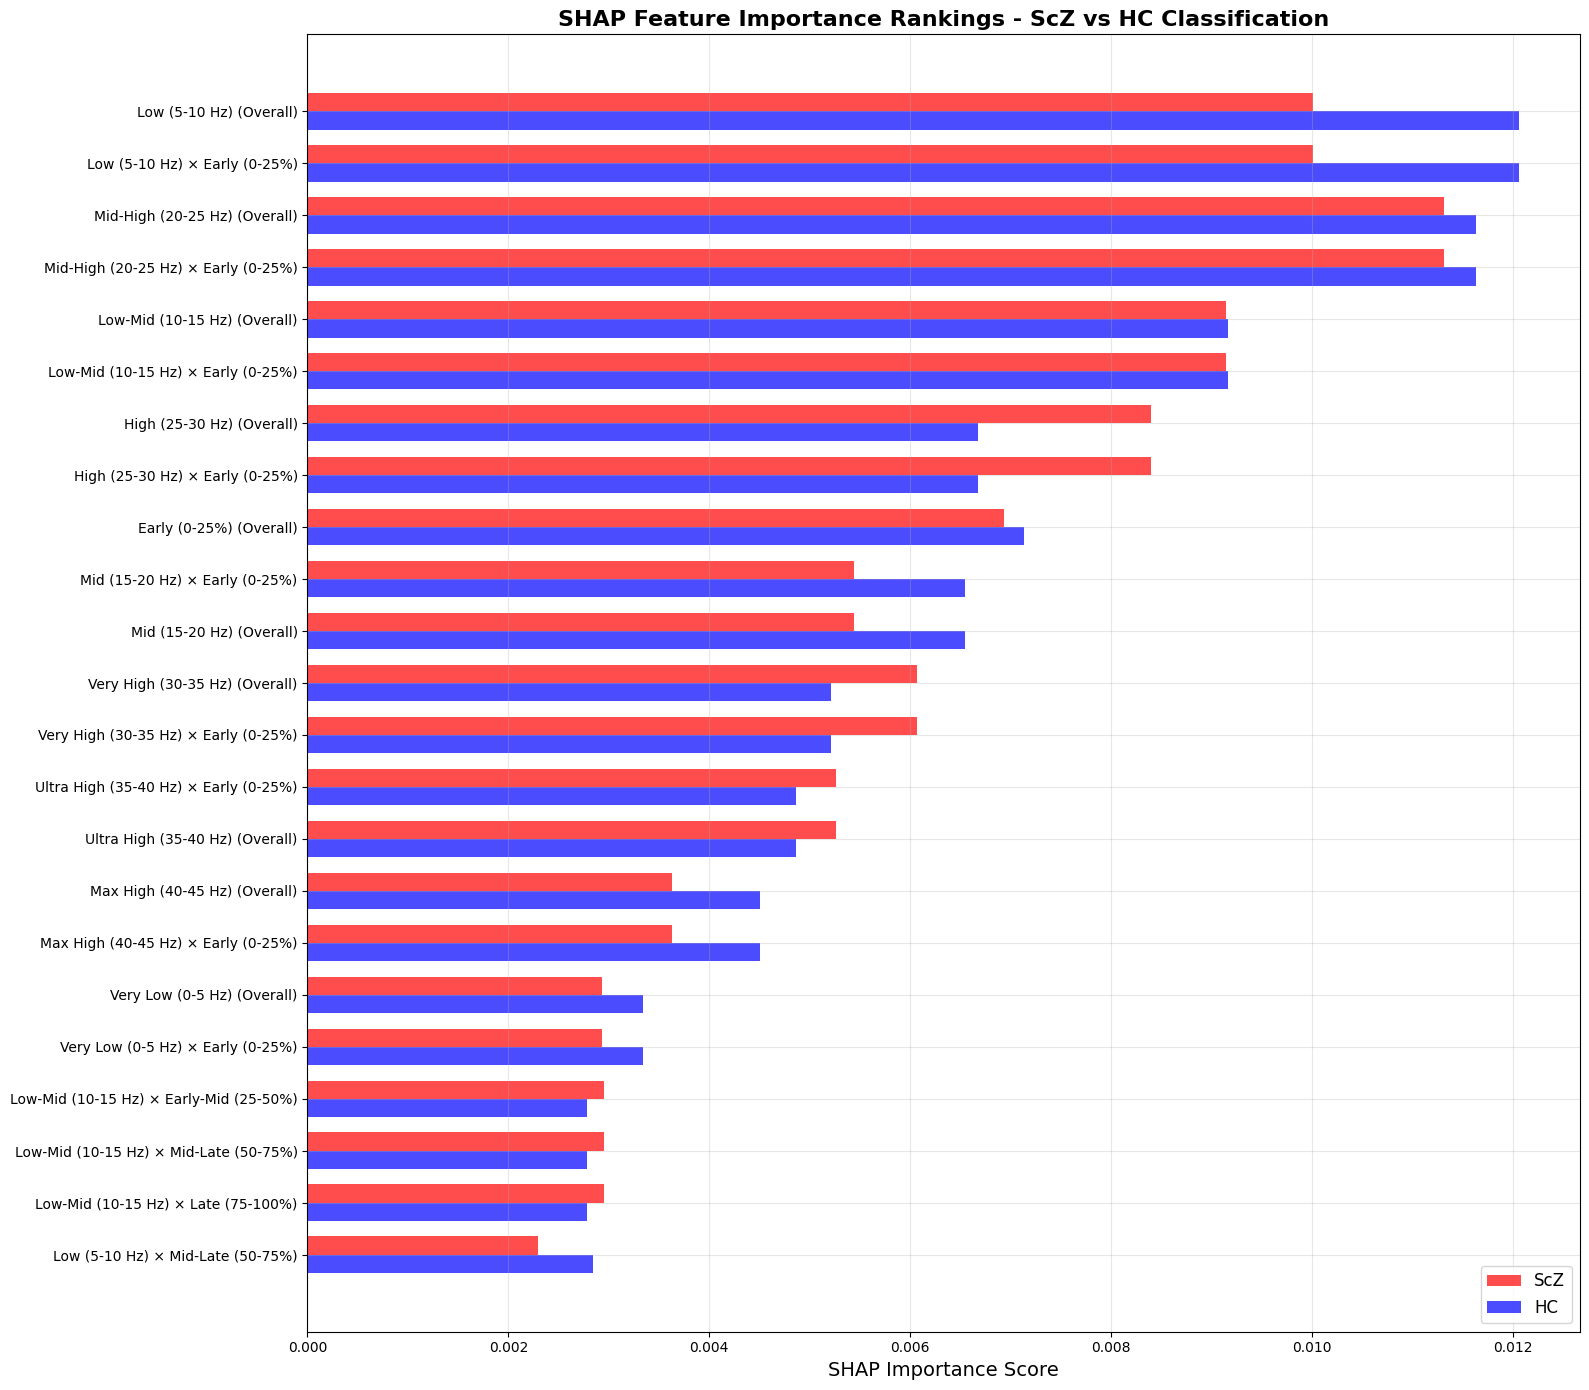

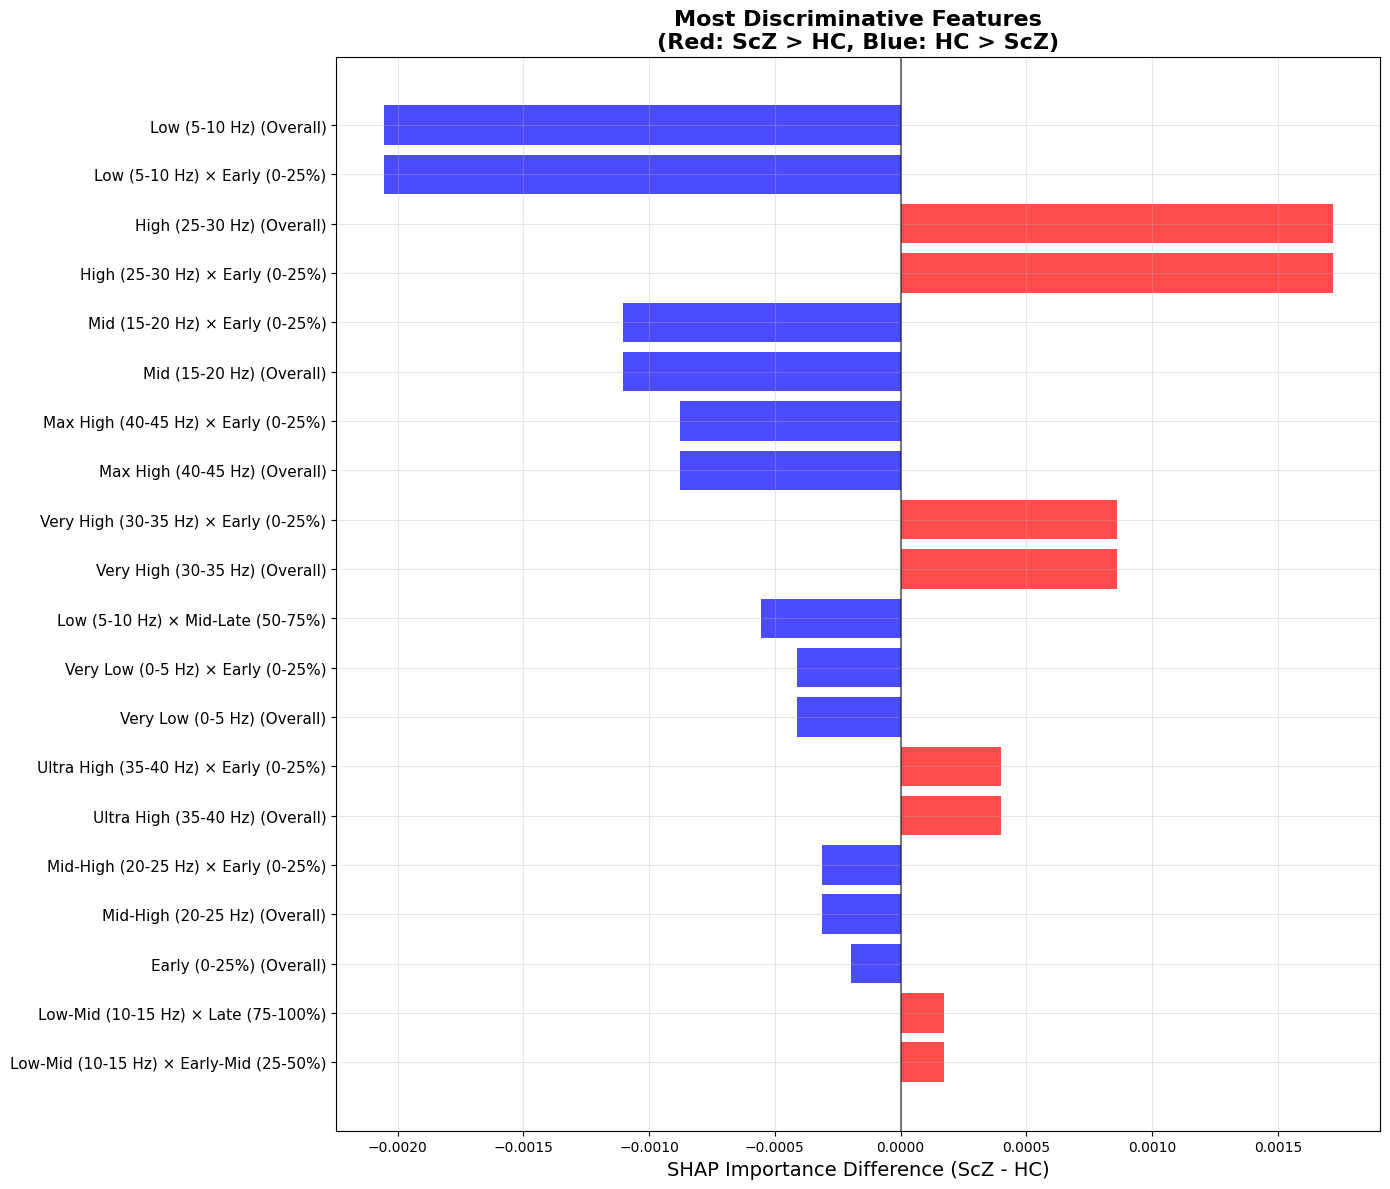


FINAL FEATURE IMPORTANCE RANKINGS

Top 15 features for ScZ classification:
 1. Mid-High (20-25 Hz) (Overall)                 :   0.0113
 2. Mid-High (20-25 Hz) × Early (0-25%)           :   0.0113
 3. Low (5-10 Hz) (Overall)                       :   0.0100
 4. Low (5-10 Hz) × Early (0-25%)                 :   0.0100
 5. Low-Mid (10-15 Hz) (Overall)                  :   0.0091
 6. Low-Mid (10-15 Hz) × Early (0-25%)            :   0.0091
 7. High (25-30 Hz) × Early (0-25%)               :   0.0084
 8. High (25-30 Hz) (Overall)                     :   0.0084
 9. Early (0-25%) (Overall)                       :   0.0069
10. Very High (30-35 Hz) (Overall)                :   0.0061
11. Very High (30-35 Hz) × Early (0-25%)          :   0.0061
12. Mid (15-20 Hz) × Early (0-25%)                :   0.0054
13. Mid (15-20 Hz) (Overall)                      :   0.0054
14. Ultra High (35-40 Hz) (Overall)               :   0.0053
15. Ultra High (35-40 Hz) × Early (0-25%)         :   0.0053

Top 15 f

In [ ]:
# COMPACT SHAP FEATURE RANKING PLOT

def create_final_feature_ranking_plot():
    """Create comprehensive feature ranking plot (compact version)"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    # Handle 3D arrays
    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define frequency bands and time segments
    freq_bands = {
        'Very Low (0-5 Hz)': (0, int(224*5/45)), 'Low (5-10 Hz)': (int(224*5/45), int(224*10/45)),
        'Low-Mid (10-15 Hz)': (int(224*10/45), int(224*15/45)), 'Mid (15-20 Hz)': (int(224*15/45), int(224*20/45)),
        'Mid-High (20-25 Hz)': (int(224*20/45), int(224*25/45)), 'High (25-30 Hz)': (int(224*25/45), int(224*30/45)),
        'Very High (30-35 Hz)': (int(224*30/45), int(224*35/45)), 'Ultra High (35-40 Hz)': (int(224*35/45), int(224*40/45)),
        'Max High (40-45 Hz)': (int(224*40/45), 224)
    }

    time_segments = {
        'Early (0-25%)': (0, 56), 'Early-Mid (25-50%)': (56, 112),
        'Mid-Late (50-75%)': (112, 168), 'Late (75-100%)': (168, 224)
    }

    # Calculate features
    feature_importance_scz = {}
    feature_importance_hc = {}

    def safe_bounds(start, end, max_val):
        start = max(0, min(start, max_val-1))
        end = max(start+1, min(end, max_val))
        return start, end

    # Frequency-Time combinations
    for band_name, (sf, ef) in freq_bands.items():
        for seg_name, (st, et) in time_segments.items():
            sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
            st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])

            feature_name = f"{band_name} × {seg_name}"
            feature_importance_scz[feature_name] = np.mean(mean_shap_scz_2d[sf:ef, st:et])
            feature_importance_hc[feature_name] = np.mean(mean_shap_hc_2d[sf:ef, st:et])

    # Overall frequency bands
    for band_name, (sf, ef) in freq_bands.items():
        sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
        feature_importance_scz[f"{band_name} (Overall)"] = np.mean(mean_shap_scz_2d[sf:ef, :])
        feature_importance_hc[f"{band_name} (Overall)"] = np.mean(mean_shap_hc_2d[sf:ef, :])

    # Overall time segments
    for seg_name, (st, et) in time_segments.items():
        st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])
        feature_importance_scz[f"{seg_name} (Overall)"] = np.mean(mean_shap_scz_2d[:, st:et])
        feature_importance_hc[f"{seg_name} (Overall)"] = np.mean(mean_shap_hc_2d[:, st:et])

    # Prepare data
    all_features = list(feature_importance_scz.keys())
    scz_values = np.array([feature_importance_scz[f] for f in all_features]) * 1000
    hc_values = np.array([feature_importance_hc[f] for f in all_features]) * 1000

    # Get top features from both classes
    top_n = 20
    top_scz_idx = np.argsort(scz_values)[::-1][:top_n]
    top_hc_idx = np.argsort(hc_values)[::-1][:top_n]
    unique_top_idx = list(set(top_scz_idx) | set(top_hc_idx))

    # Sort by maximum importance and take top 25
    max_importance = np.maximum(scz_values[unique_top_idx], hc_values[unique_top_idx])
    sorted_idx = np.argsort(max_importance)[::-1][:25]

    final_idx = [unique_top_idx[i] for i in sorted_idx]
    final_features = [all_features[i] for i in final_idx]
    final_scz = scz_values[final_idx]
    final_hc = hc_values[final_idx]

    # Plot 1: Combined horizontal bar plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 14))
    y_pos = np.arange(len(final_features))

    bars1 = ax.barh(y_pos - 0.175, final_scz, 0.35, label='ScZ', color='red', alpha=0.7)
    bars2 = ax.barh(y_pos + 0.175, final_hc, 0.35, label='HC', color='blue', alpha=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=10)
    ax.set_xlabel('SHAP Importance Score', fontsize=14)
    ax.set_title('SHAP Feature Importance Rankings - ScZ vs HC Classification', fontsize=16, fontweight='bold')
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot 2: Discriminative features (difference plot)
    fig2, ax2 = plt.subplots(1, 1, figsize=(14, 12))
    differences = final_scz - final_hc
    diff_idx = np.argsort(np.abs(differences))[::-1][:20]

    disc_features = [final_features[i] for i in diff_idx]
    disc_diff = differences[diff_idx]
    bar_colors = ['red' if d > 0 else 'blue' for d in disc_diff]

    y_pos = np.arange(len(disc_features))
    ax2.barh(y_pos, disc_diff, color=bar_colors, alpha=0.7)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=11)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC)', fontsize=14)
    ax2.set_title('Most Discriminative Features\n(Red: ScZ > HC, Blue: HC > ScZ)', fontsize=16, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nFINAL FEATURE IMPORTANCE RANKINGS")
    print("=" * 80)

    top_scz_features = [all_features[i] for i in np.argsort(scz_values)[::-1][:15]]
    top_scz_values = sorted(scz_values, reverse=True)[:15]

    print(f"\nTop 15 features for ScZ classification:")
    for i, (feature, importance) in enumerate(zip(top_scz_features, top_scz_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    top_hc_features = [all_features[i] for i in np.argsort(hc_values)[::-1][:15]]
    top_hc_values = sorted(hc_values, reverse=True)[:15]

    print(f"\nTop 15 features for HC classification:")
    for i, (feature, importance) in enumerate(zip(top_hc_features, top_hc_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    print(f"\nSUMMARY STATISTICS:")
    print(f"Total features: {len(all_features)}")
    print(f"ScZ range: {scz_values.min():.6f} to {scz_values.max():.6f}")
    print(f"HC range: {hc_values.min():.6f} to {hc_values.max():.6f}")

    return feature_importance_scz, feature_importance_hc

# Generate the final ranking plot
print("="*80)
print("GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION")
print("="*80)

scz_rankings, hc_rankings = create_final_feature_ranking_plot()
print("\nFinal ranking plot generated successfully!")
print("="*80)

GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION


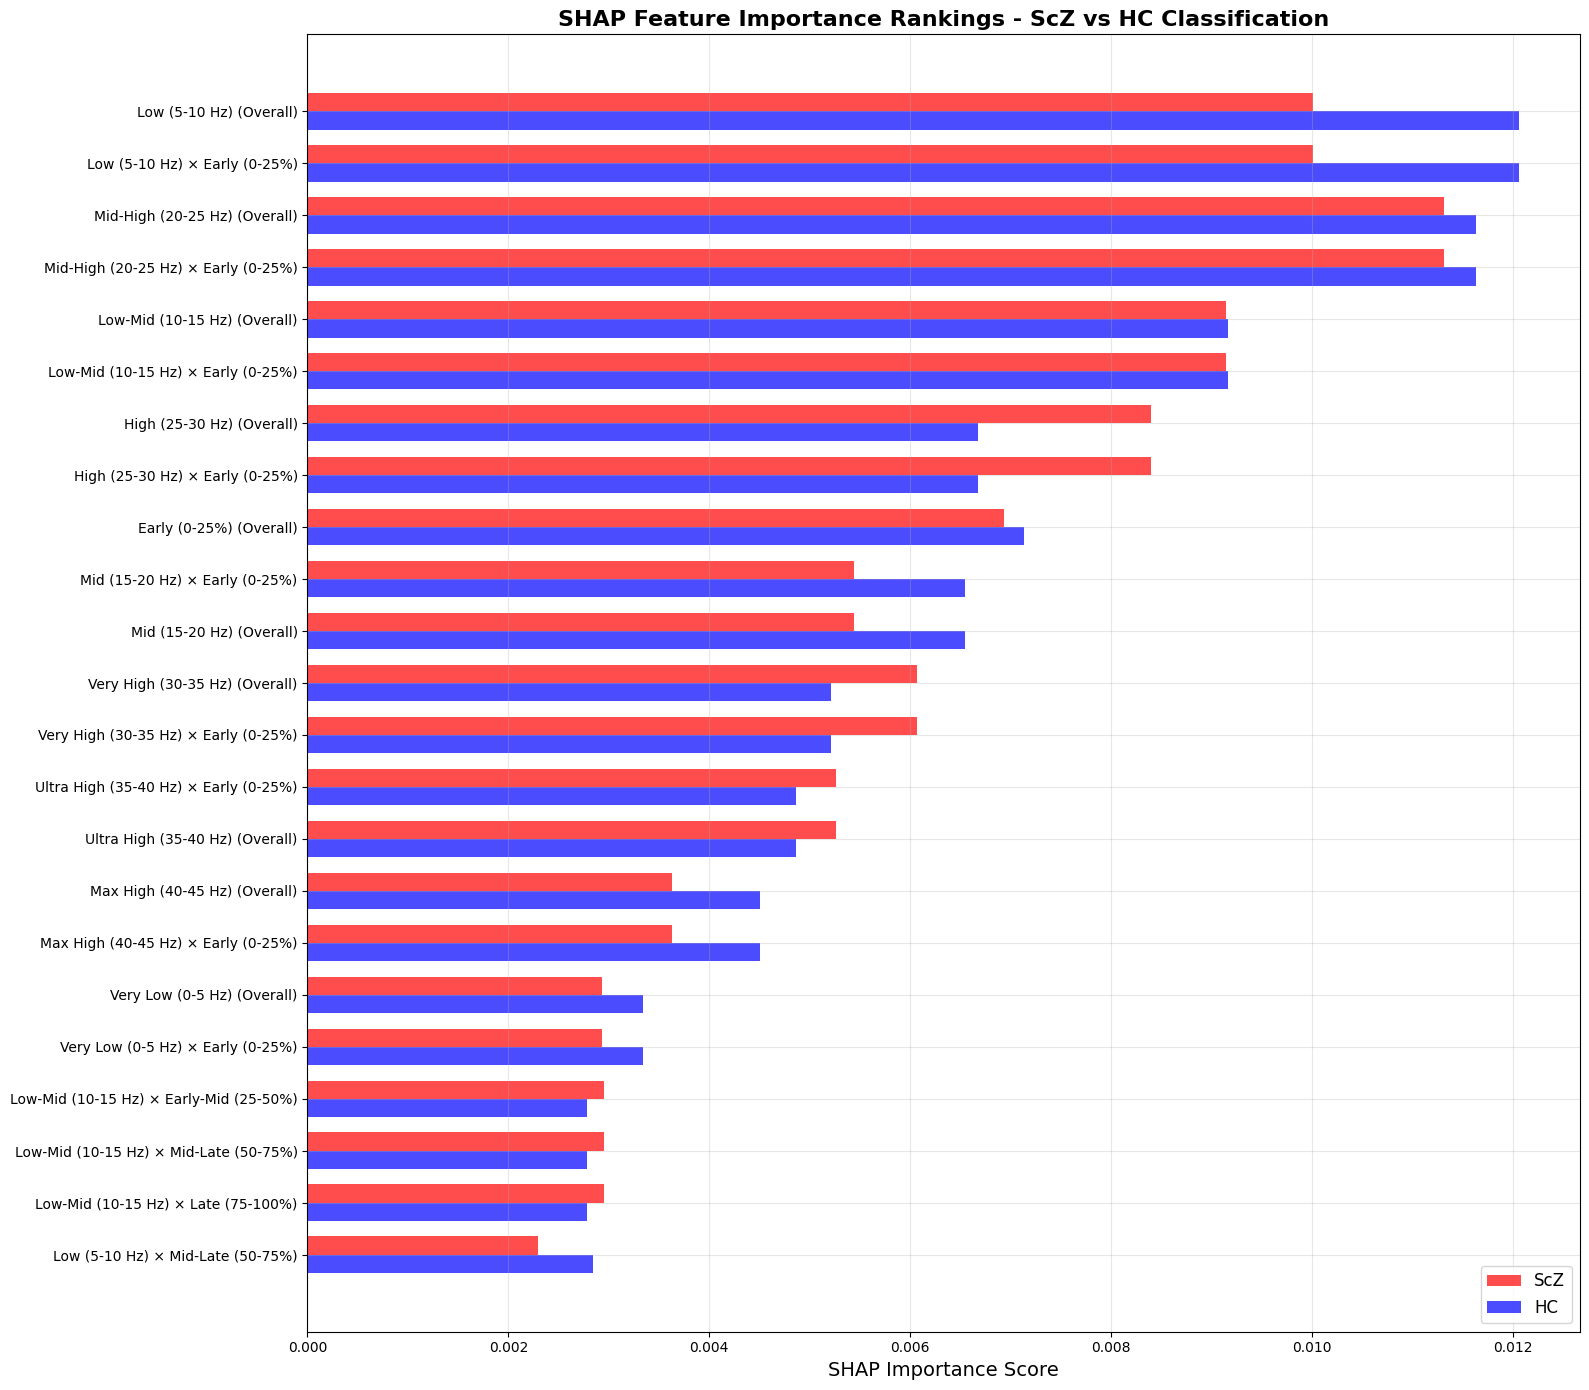

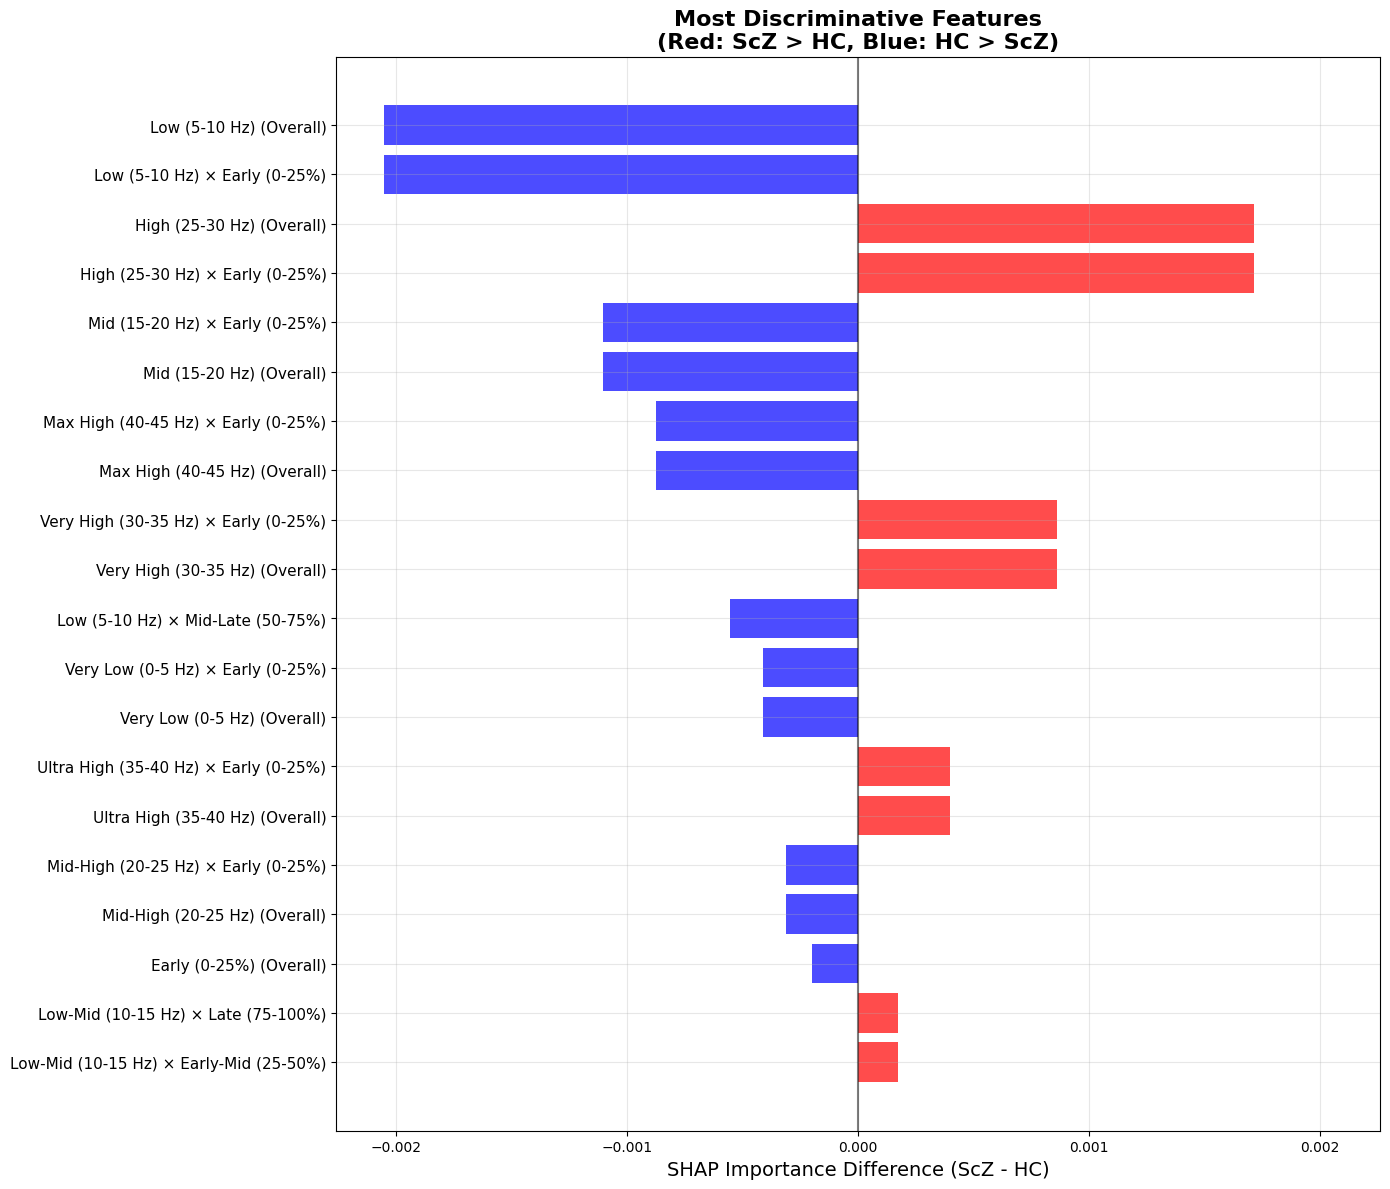


FINAL FEATURE IMPORTANCE RANKINGS

Top 15 features for ScZ classification:
 1. Mid-High (20-25 Hz) (Overall)                 :   0.0113
 2. Mid-High (20-25 Hz) × Early (0-25%)           :   0.0113
 3. Low (5-10 Hz) (Overall)                       :   0.0100
 4. Low (5-10 Hz) × Early (0-25%)                 :   0.0100
 5. Low-Mid (10-15 Hz) (Overall)                  :   0.0091
 6. Low-Mid (10-15 Hz) × Early (0-25%)            :   0.0091
 7. High (25-30 Hz) × Early (0-25%)               :   0.0084
 8. High (25-30 Hz) (Overall)                     :   0.0084
 9. Early (0-25%) (Overall)                       :   0.0069
10. Very High (30-35 Hz) (Overall)                :   0.0061
11. Very High (30-35 Hz) × Early (0-25%)          :   0.0061
12. Mid (15-20 Hz) × Early (0-25%)                :   0.0054
13. Mid (15-20 Hz) (Overall)                      :   0.0054
14. Ultra High (35-40 Hz) (Overall)               :   0.0053
15. Ultra High (35-40 Hz) × Early (0-25%)         :   0.0053

Top 15 f

In [ ]:
# COMPACT SHAP FEATURE RANKING PLOT

def create_final_feature_ranking_plot():
    """Create comprehensive feature ranking plot (compact version)"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    # Handle 3D arrays
    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define frequency bands and time segments
    freq_bands = {
        'Very Low (0-5 Hz)': (0, int(224*5/45)), 'Low (5-10 Hz)': (int(224*5/45), int(224*10/45)),
        'Low-Mid (10-15 Hz)': (int(224*10/45), int(224*15/45)), 'Mid (15-20 Hz)': (int(224*15/45), int(224*20/45)),
        'Mid-High (20-25 Hz)': (int(224*20/45), int(224*25/45)), 'High (25-30 Hz)': (int(224*25/45), int(224*30/45)),
        'Very High (30-35 Hz)': (int(224*30/45), int(224*35/45)), 'Ultra High (35-40 Hz)': (int(224*35/45), int(224*40/45)),
        'Max High (40-45 Hz)': (int(224*40/45), 224)
    }

    time_segments = {
        'Early (0-25%)': (0, 56), 'Early-Mid (25-50%)': (56, 112),
        'Mid-Late (50-75%)': (112, 168), 'Late (75-100%)': (168, 224)
    }

    # Calculate features
    feature_importance_scz = {}
    feature_importance_hc = {}

    def safe_bounds(start, end, max_val):
        start = max(0, min(start, max_val-1))
        end = max(start+1, min(end, max_val))
        return start, end

    # Frequency-Time combinations
    for band_name, (sf, ef) in freq_bands.items():
        for seg_name, (st, et) in time_segments.items():
            sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
            st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])

            feature_name = f"{band_name} × {seg_name}"
            feature_importance_scz[feature_name] = np.mean(mean_shap_scz_2d[sf:ef, st:et])
            feature_importance_hc[feature_name] = np.mean(mean_shap_hc_2d[sf:ef, st:et])

    # Overall frequency bands
    for band_name, (sf, ef) in freq_bands.items():
        sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
        feature_importance_scz[f"{band_name} (Overall)"] = np.mean(mean_shap_scz_2d[sf:ef, :])
        feature_importance_hc[f"{band_name} (Overall)"] = np.mean(mean_shap_hc_2d[sf:ef, :])

    # Overall time segments
    for seg_name, (st, et) in time_segments.items():
        st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])
        feature_importance_scz[f"{seg_name} (Overall)"] = np.mean(mean_shap_scz_2d[:, st:et])
        feature_importance_hc[f"{seg_name} (Overall)"] = np.mean(mean_shap_hc_2d[:, st:et])

    # Prepare data
    all_features = list(feature_importance_scz.keys())
    scz_values = np.array([feature_importance_scz[f] for f in all_features]) * 1000
    hc_values = np.array([feature_importance_hc[f] for f in all_features]) * 1000

    # Get top features from both classes
    top_n = 20
    top_scz_idx = np.argsort(scz_values)[::-1][:top_n]
    top_hc_idx = np.argsort(hc_values)[::-1][:top_n]
    unique_top_idx = list(set(top_scz_idx) | set(top_hc_idx))

    # Sort by maximum importance and take top 25
    max_importance = np.maximum(scz_values[unique_top_idx], hc_values[unique_top_idx])
    sorted_idx = np.argsort(max_importance)[::-1][:25]

    final_idx = [unique_top_idx[i] for i in sorted_idx]
    final_features = [all_features[i] for i in final_idx]
    final_scz = scz_values[final_idx]
    final_hc = hc_values[final_idx]

    # Plot 1: Combined horizontal bar plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 14))
    y_pos = np.arange(len(final_features))

    bars1 = ax.barh(y_pos - 0.175, final_scz, 0.35, label='ScZ', color='red', alpha=0.7)
    bars2 = ax.barh(y_pos + 0.175, final_hc, 0.35, label='HC', color='blue', alpha=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=10)
    ax.set_xlabel('SHAP Importance Score', fontsize=14)
    ax.set_title('SHAP Feature Importance Rankings - ScZ vs HC Classification', fontsize=16, fontweight='bold')
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot 2: Discriminative features (difference plot)
    fig2, ax2 = plt.subplots(1, 1, figsize=(14, 12))
    differences = final_scz - final_hc
    diff_idx = np.argsort(np.abs(differences))[::-1][:20]

    disc_features = [final_features[i] for i in diff_idx]
    disc_diff = differences[diff_idx]
    bar_colors = ['red' if d > 0 else 'blue' for d in disc_diff]

    y_pos = np.arange(len(disc_features))
    ax2.barh(y_pos, disc_diff, color=bar_colors, alpha=0.7)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=11)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC)', fontsize=14)
    ax2.set_title('Most Discriminative Features\n(Red: ScZ > HC, Blue: HC > ScZ)', fontsize=16, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # Set tighter x-axis bounds for difference plot
    max_diff = max(abs(np.min(disc_diff)), abs(np.max(disc_diff)))
    ax2.set_xlim(-max_diff * 1.1, max_diff * 1.1)

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nFINAL FEATURE IMPORTANCE RANKINGS")
    print("=" * 80)

    top_scz_features = [all_features[i] for i in np.argsort(scz_values)[::-1][:15]]
    top_scz_values = sorted(scz_values, reverse=True)[:15]

    print(f"\nTop 15 features for ScZ classification:")
    for i, (feature, importance) in enumerate(zip(top_scz_features, top_scz_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    top_hc_features = [all_features[i] for i in np.argsort(hc_values)[::-1][:15]]
    top_hc_values = sorted(hc_values, reverse=True)[:15]

    print(f"\nTop 15 features for HC classification:")
    for i, (feature, importance) in enumerate(zip(top_hc_features, top_hc_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    print(f"\nSUMMARY STATISTICS:")
    print(f"Total features: {len(all_features)}")
    print(f"ScZ range: {scz_values.min():.6f} to {scz_values.max():.6f}")
    print(f"HC range: {hc_values.min():.6f} to {hc_values.max():.6f}")

    return feature_importance_scz, feature_importance_hc

# Generate the final ranking plot
print("="*80)
print("GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION")
print("="*80)

scz_rankings, hc_rankings = create_final_feature_ranking_plot()
print("\nFinal ranking plot generated successfully!")
print("="*80)

GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION


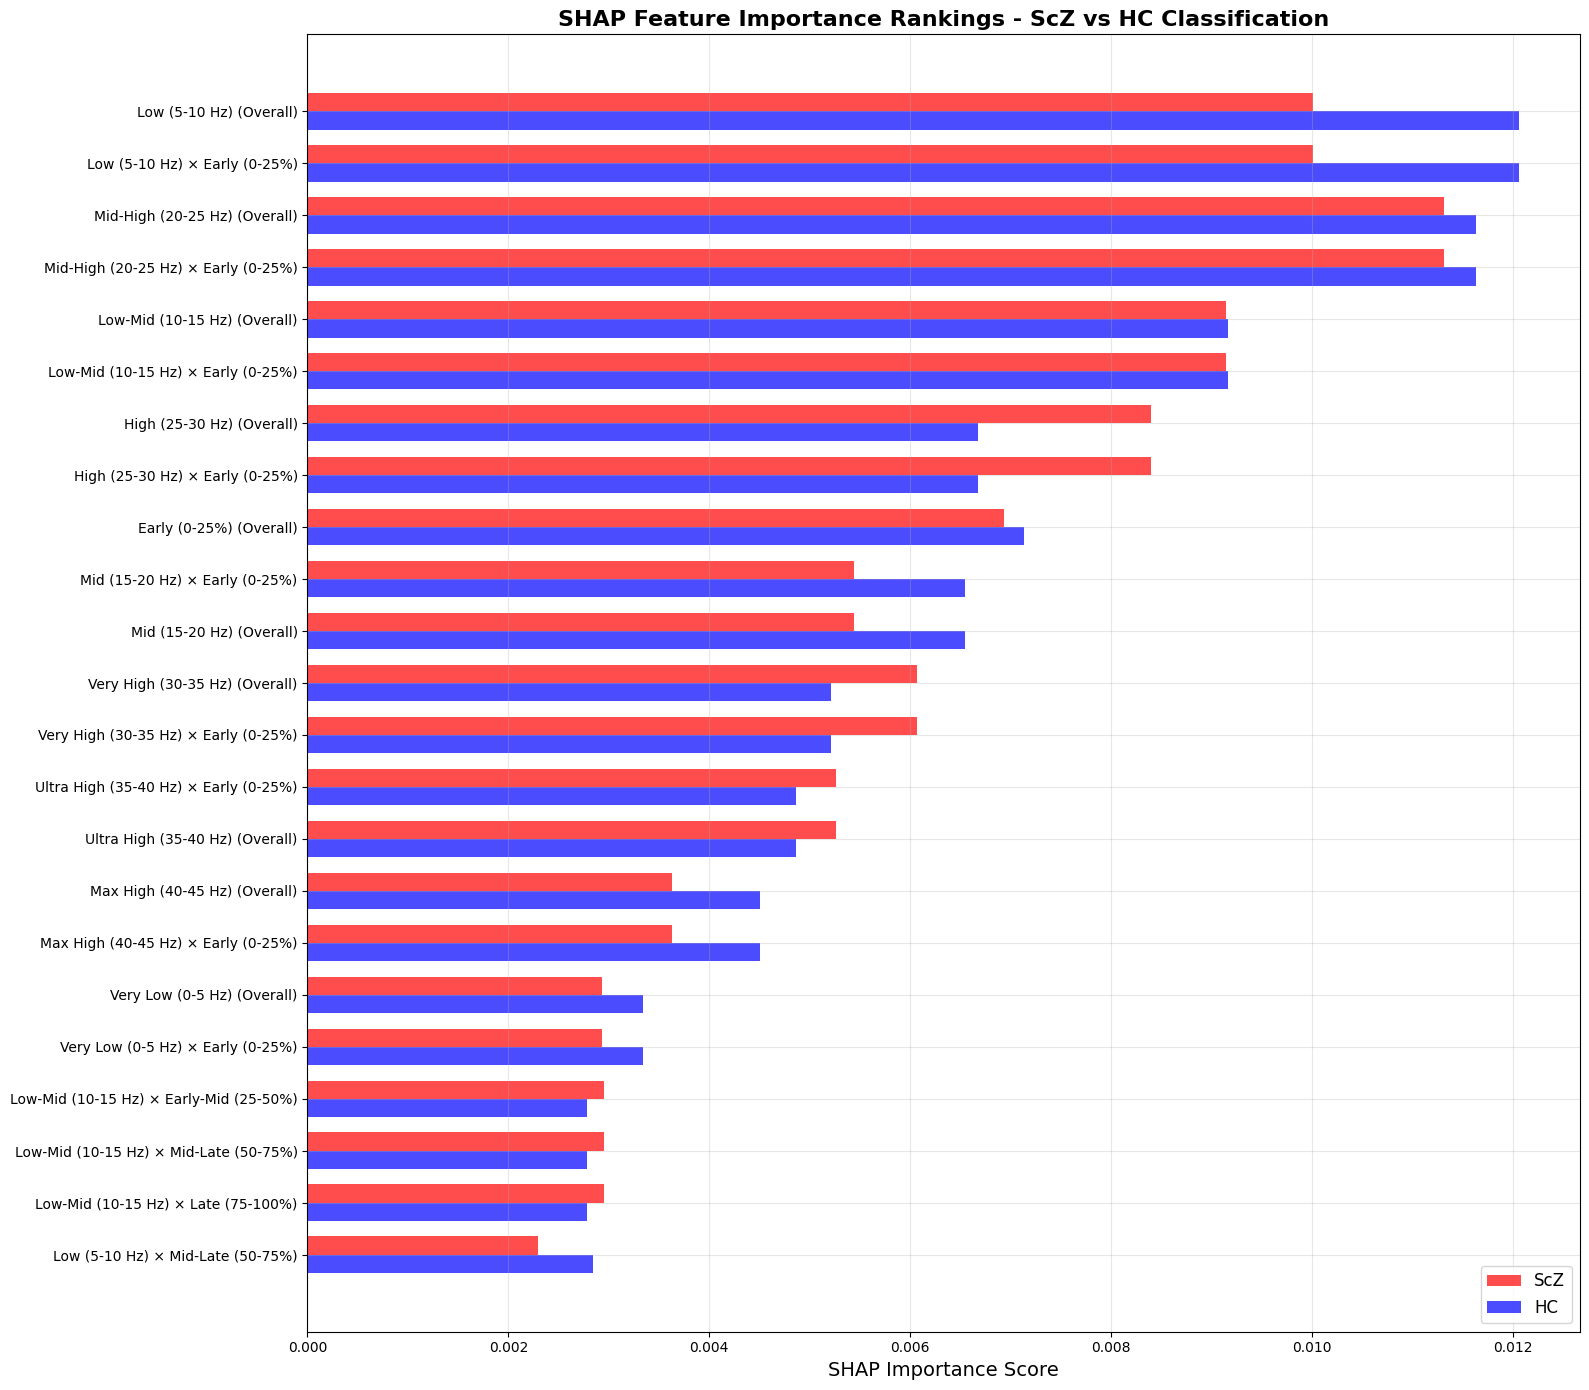

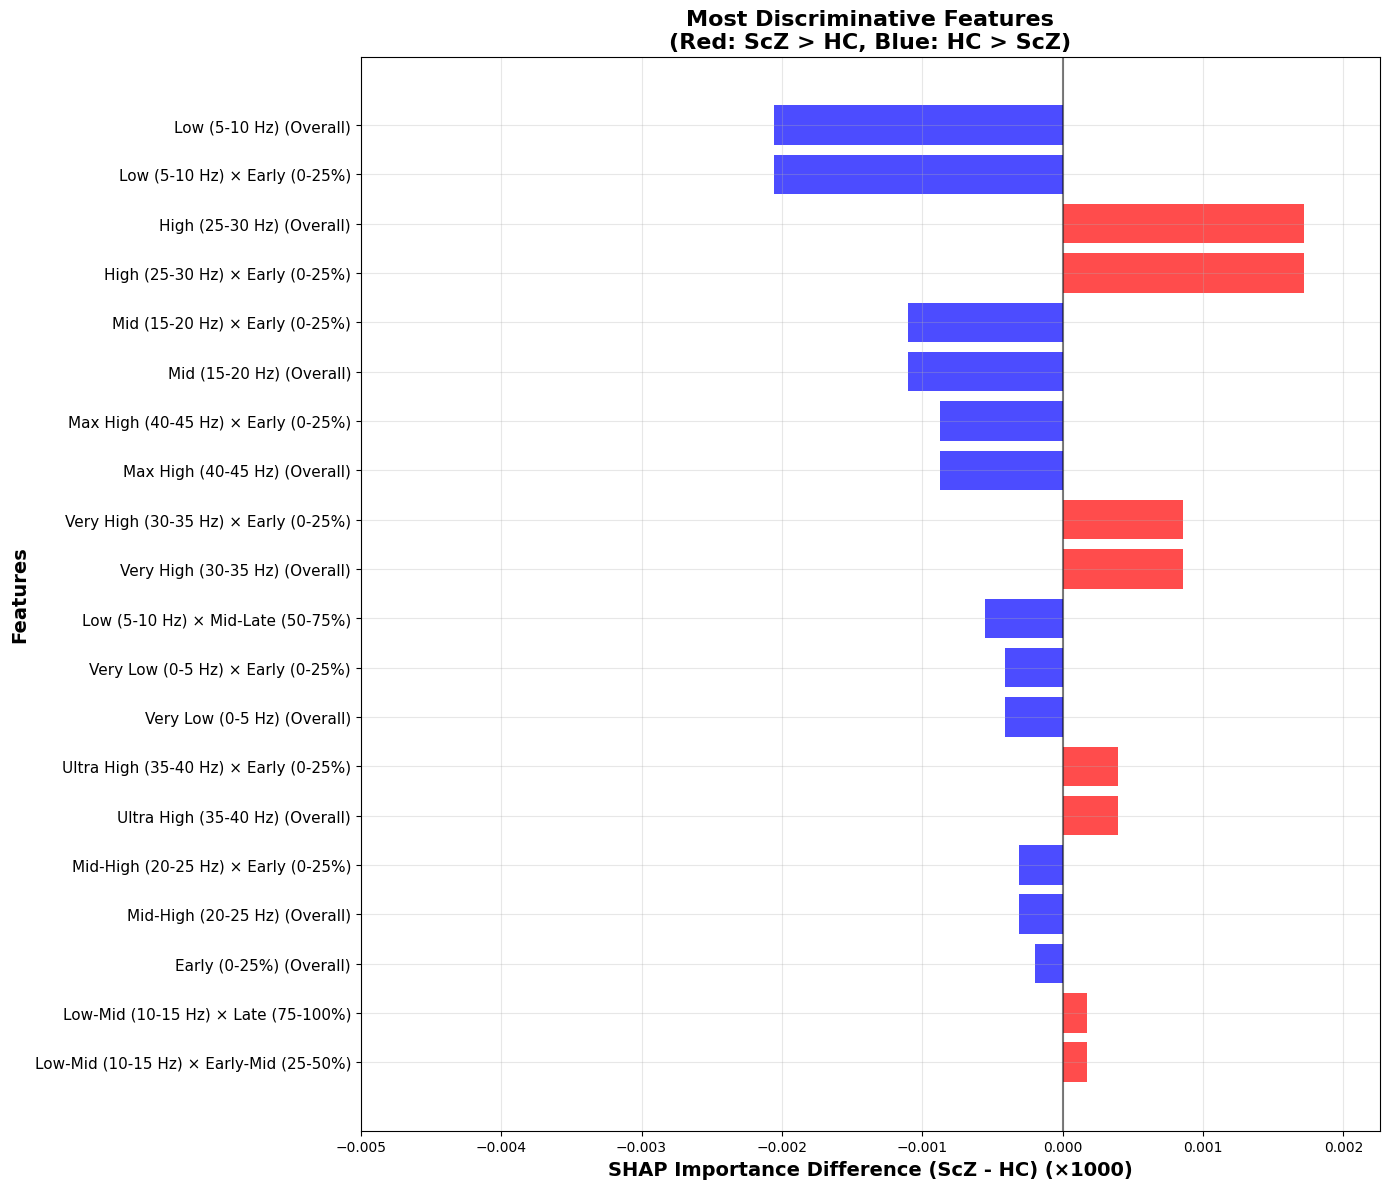


FINAL FEATURE IMPORTANCE RANKINGS

Top 15 features for ScZ classification:
 1. Mid-High (20-25 Hz) (Overall)                 :   0.0113
 2. Mid-High (20-25 Hz) × Early (0-25%)           :   0.0113
 3. Low (5-10 Hz) (Overall)                       :   0.0100
 4. Low (5-10 Hz) × Early (0-25%)                 :   0.0100
 5. Low-Mid (10-15 Hz) (Overall)                  :   0.0091
 6. Low-Mid (10-15 Hz) × Early (0-25%)            :   0.0091
 7. High (25-30 Hz) × Early (0-25%)               :   0.0084
 8. High (25-30 Hz) (Overall)                     :   0.0084
 9. Early (0-25%) (Overall)                       :   0.0069
10. Very High (30-35 Hz) (Overall)                :   0.0061
11. Very High (30-35 Hz) × Early (0-25%)          :   0.0061
12. Mid (15-20 Hz) × Early (0-25%)                :   0.0054
13. Mid (15-20 Hz) (Overall)                      :   0.0054
14. Ultra High (35-40 Hz) (Overall)               :   0.0053
15. Ultra High (35-40 Hz) × Early (0-25%)         :   0.0053

Top 15 f

In [ ]:
# COMPACT SHAP FEATURE RANKING PLOT

def create_final_feature_ranking_plot():
    """Create comprehensive feature ranking plot (compact version)"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    # Handle 3D arrays
    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define frequency bands and time segments
    freq_bands = {
        'Very Low (0-5 Hz)': (0, int(224*5/45)), 'Low (5-10 Hz)': (int(224*5/45), int(224*10/45)),
        'Low-Mid (10-15 Hz)': (int(224*10/45), int(224*15/45)), 'Mid (15-20 Hz)': (int(224*15/45), int(224*20/45)),
        'Mid-High (20-25 Hz)': (int(224*20/45), int(224*25/45)), 'High (25-30 Hz)': (int(224*25/45), int(224*30/45)),
        'Very High (30-35 Hz)': (int(224*30/45), int(224*35/45)), 'Ultra High (35-40 Hz)': (int(224*35/45), int(224*40/45)),
        'Max High (40-45 Hz)': (int(224*40/45), 224)
    }

    time_segments = {
        'Early (0-25%)': (0, 56), 'Early-Mid (25-50%)': (56, 112),
        'Mid-Late (50-75%)': (112, 168), 'Late (75-100%)': (168, 224)
    }

    # Calculate features
    feature_importance_scz = {}
    feature_importance_hc = {}

    def safe_bounds(start, end, max_val):
        start = max(0, min(start, max_val-1))
        end = max(start+1, min(end, max_val))
        return start, end

    # Frequency-Time combinations
    for band_name, (sf, ef) in freq_bands.items():
        for seg_name, (st, et) in time_segments.items():
            sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
            st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])

            feature_name = f"{band_name} × {seg_name}"
            feature_importance_scz[feature_name] = np.mean(mean_shap_scz_2d[sf:ef, st:et])
            feature_importance_hc[feature_name] = np.mean(mean_shap_hc_2d[sf:ef, st:et])

    # Overall frequency bands
    for band_name, (sf, ef) in freq_bands.items():
        sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
        feature_importance_scz[f"{band_name} (Overall)"] = np.mean(mean_shap_scz_2d[sf:ef, :])
        feature_importance_hc[f"{band_name} (Overall)"] = np.mean(mean_shap_hc_2d[sf:ef, :])

    # Overall time segments
    for seg_name, (st, et) in time_segments.items():
        st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])
        feature_importance_scz[f"{seg_name} (Overall)"] = np.mean(mean_shap_scz_2d[:, st:et])
        feature_importance_hc[f"{seg_name} (Overall)"] = np.mean(mean_shap_hc_2d[:, st:et])

    # Prepare data
    all_features = list(feature_importance_scz.keys())
    scz_values = np.array([feature_importance_scz[f] for f in all_features]) * 1000
    hc_values = np.array([feature_importance_hc[f] for f in all_features]) * 1000

    # Get top features from both classes
    top_n = 20
    top_scz_idx = np.argsort(scz_values)[::-1][:top_n]
    top_hc_idx = np.argsort(hc_values)[::-1][:top_n]
    unique_top_idx = list(set(top_scz_idx) | set(top_hc_idx))

    # Sort by maximum importance and take top 25
    max_importance = np.maximum(scz_values[unique_top_idx], hc_values[unique_top_idx])
    sorted_idx = np.argsort(max_importance)[::-1][:25]

    final_idx = [unique_top_idx[i] for i in sorted_idx]
    final_features = [all_features[i] for i in final_idx]
    final_scz = scz_values[final_idx]
    final_hc = hc_values[final_idx]

    # Plot 1: Combined horizontal bar plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 14))
    y_pos = np.arange(len(final_features))

    bars1 = ax.barh(y_pos - 0.175, final_scz, 0.35, label='ScZ', color='red', alpha=0.7)
    bars2 = ax.barh(y_pos + 0.175, final_hc, 0.35, label='HC', color='blue', alpha=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=10)
    ax.set_xlabel('SHAP Importance Score', fontsize=14)
    ax.set_title('SHAP Feature Importance Rankings - ScZ vs HC Classification', fontsize=16, fontweight='bold')
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot 2: Discriminative features (difference plot)
    fig2, ax2 = plt.subplots(1, 1, figsize=(14, 12))
    differences = final_scz - final_hc
    diff_idx = np.argsort(np.abs(differences))[::-1][:20]

    disc_features = [final_features[i] for i in diff_idx]
    disc_diff = differences[diff_idx]
    bar_colors = ['red' if d > 0 else 'blue' for d in disc_diff]

    y_pos = np.arange(len(disc_features))
    ax2.barh(y_pos, disc_diff, color=bar_colors, alpha=0.7)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=11)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC) (×1000)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Features', fontsize=14, fontweight='bold')
    ax2.set_title('Most Discriminative Features\n(Red: ScZ > HC, Blue: HC > ScZ)', fontsize=16, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # Set specific x-axis bounds for difference plot
    max_diff = max(abs(np.min(disc_diff)), abs(np.max(disc_diff)))
    ax2.set_xlim(-0.005, max_diff * 1.1)

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nFINAL FEATURE IMPORTANCE RANKINGS")
    print("=" * 80)

    top_scz_features = [all_features[i] for i in np.argsort(scz_values)[::-1][:15]]
    top_scz_values = sorted(scz_values, reverse=True)[:15]

    print(f"\nTop 15 features for ScZ classification:")
    for i, (feature, importance) in enumerate(zip(top_scz_features, top_scz_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    top_hc_features = [all_features[i] for i in np.argsort(hc_values)[::-1][:15]]
    top_hc_values = sorted(hc_values, reverse=True)[:15]

    print(f"\nTop 15 features for HC classification:")
    for i, (feature, importance) in enumerate(zip(top_hc_features, top_hc_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    print(f"\nSUMMARY STATISTICS:")
    print(f"Total features: {len(all_features)}")
    print(f"ScZ range: {scz_values.min():.6f} to {scz_values.max():.6f}")
    print(f"HC range: {hc_values.min():.6f} to {hc_values.max():.6f}")

    return feature_importance_scz, feature_importance_hc

# Generate the final ranking plot
print("="*80)
print("GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION")
print("="*80)

scz_rankings, hc_rankings = create_final_feature_ranking_plot()
print("\nFinal ranking plot generated successfully!")
print("="*80)

GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION


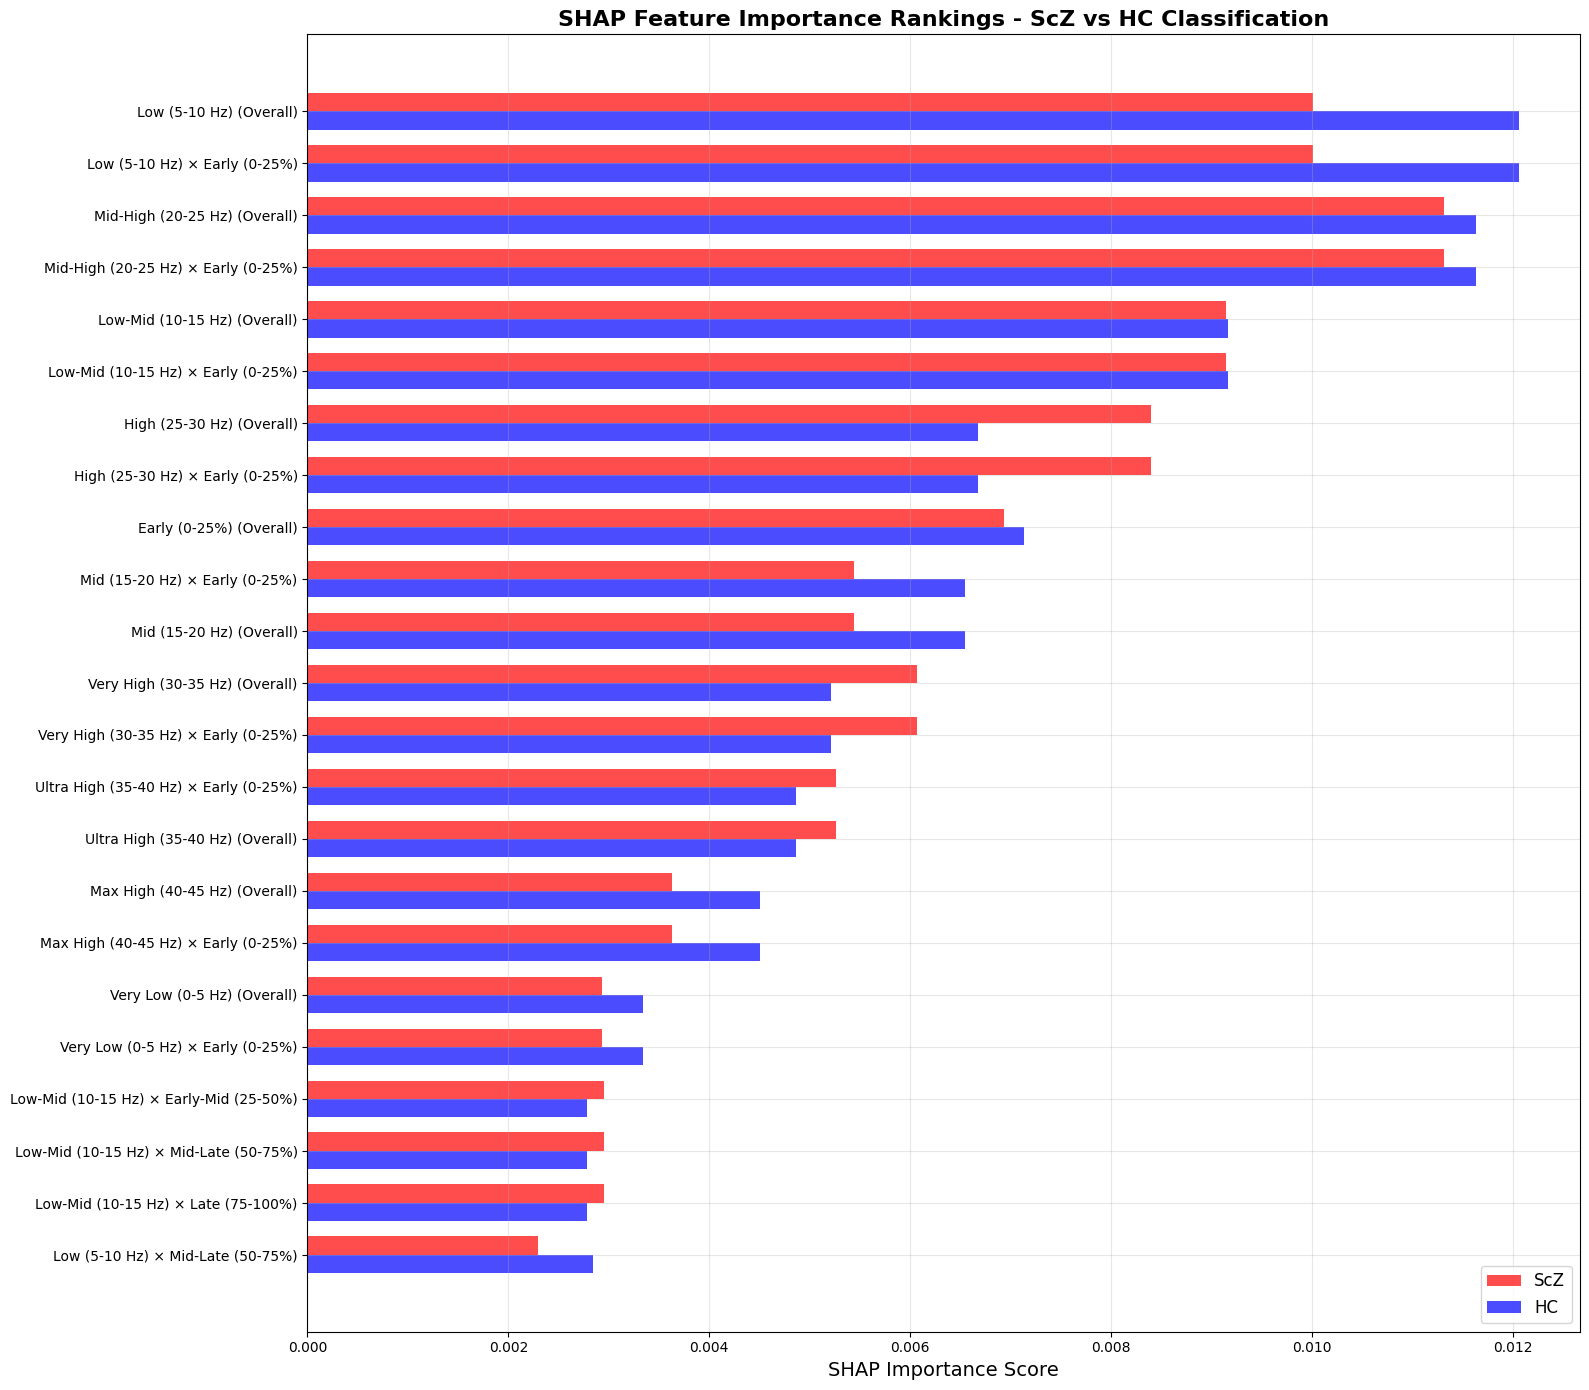

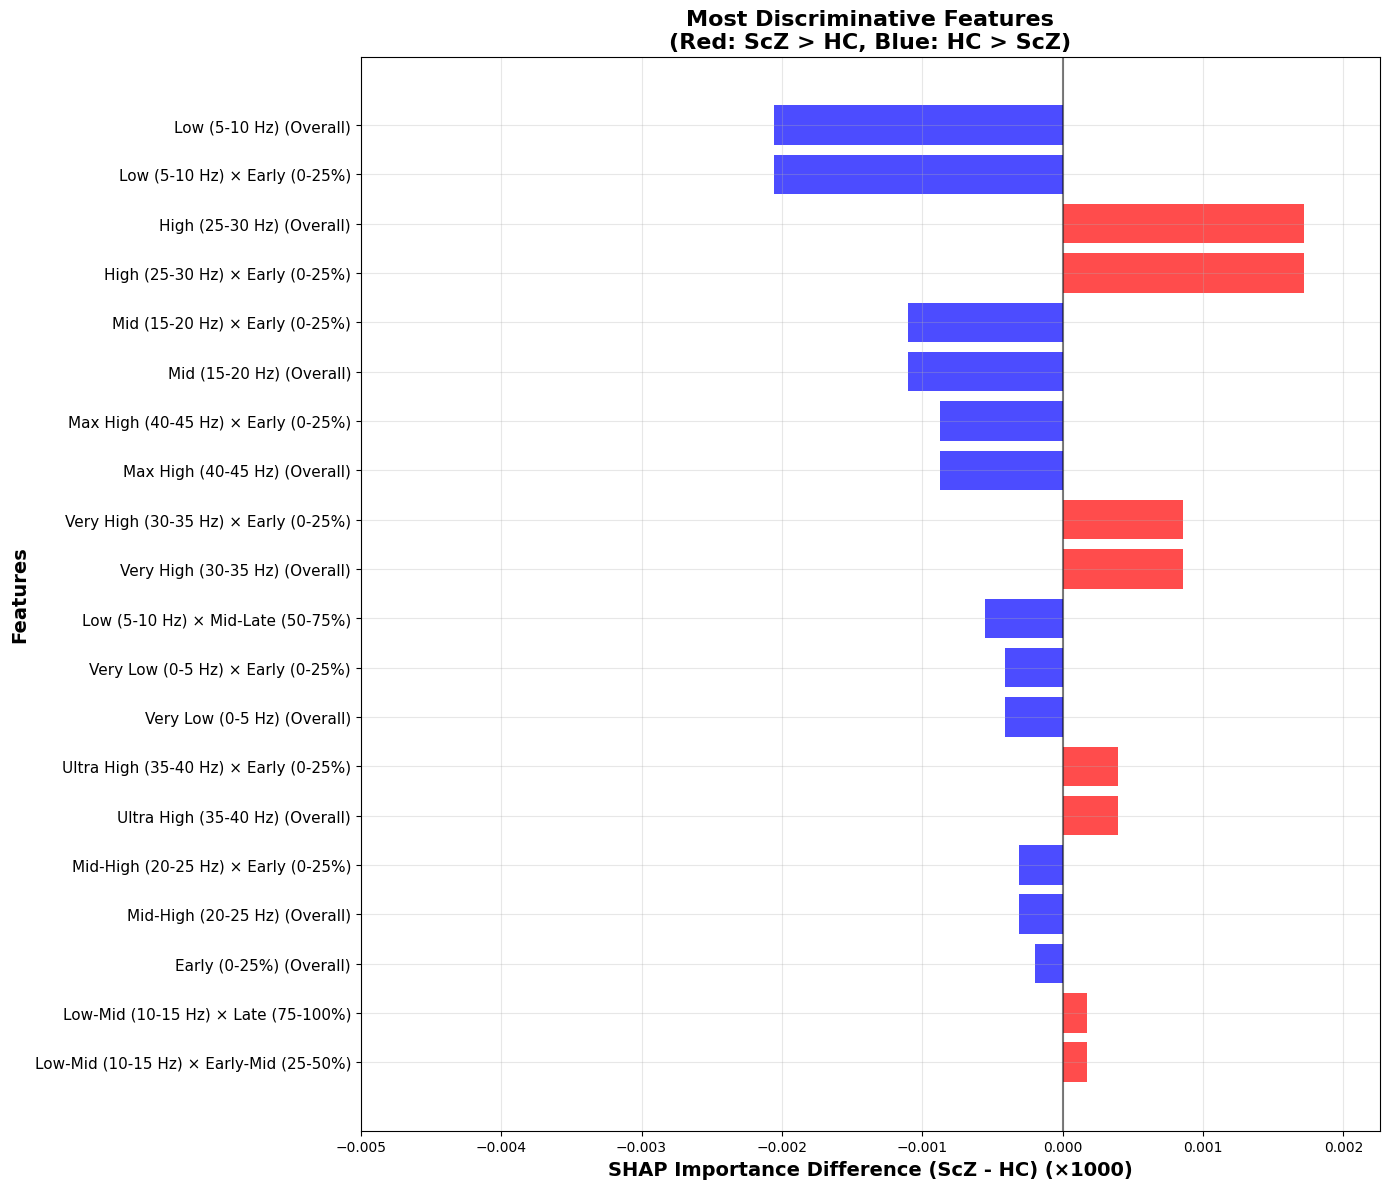


FINAL FEATURE IMPORTANCE RANKINGS

Top 15 features for ScZ classification:
 1. Mid-High (20-25 Hz) (Overall)                 :   0.0113
 2. Mid-High (20-25 Hz) × Early (0-25%)           :   0.0113
 3. Low (5-10 Hz) (Overall)                       :   0.0100
 4. Low (5-10 Hz) × Early (0-25%)                 :   0.0100
 5. Low-Mid (10-15 Hz) (Overall)                  :   0.0091
 6. Low-Mid (10-15 Hz) × Early (0-25%)            :   0.0091
 7. High (25-30 Hz) × Early (0-25%)               :   0.0084
 8. High (25-30 Hz) (Overall)                     :   0.0084
 9. Early (0-25%) (Overall)                       :   0.0069
10. Very High (30-35 Hz) (Overall)                :   0.0061
11. Very High (30-35 Hz) × Early (0-25%)          :   0.0061
12. Mid (15-20 Hz) × Early (0-25%)                :   0.0054
13. Mid (15-20 Hz) (Overall)                      :   0.0054
14. Ultra High (35-40 Hz) (Overall)               :   0.0053
15. Ultra High (35-40 Hz) × Early (0-25%)         :   0.0053

Top 15 f

In [ ]:
# COMPACT SHAP FEATURE RANKING PLOT

def create_final_feature_ranking_plot():
    """Create comprehensive feature ranking plot (compact version)"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    # Handle 3D arrays
    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define frequency bands and time segments
    freq_bands = {
        'Very Low (0-5 Hz)': (0, int(224*5/45)), 'Low (5-10 Hz)': (int(224*5/45), int(224*10/45)),
        'Low-Mid (10-15 Hz)': (int(224*10/45), int(224*15/45)), 'Mid (15-20 Hz)': (int(224*15/45), int(224*20/45)),
        'Mid-High (20-25 Hz)': (int(224*20/45), int(224*25/45)), 'High (25-30 Hz)': (int(224*25/45), int(224*30/45)),
        'Very High (30-35 Hz)': (int(224*30/45), int(224*35/45)), 'Ultra High (35-40 Hz)': (int(224*35/45), int(224*40/45)),
        'Max High (40-45 Hz)': (int(224*40/45), 224)
    }

    time_segments = {
        'Early (0-25%)': (0, 56), 'Early-Mid (25-50%)': (56, 112),
        'Mid-Late (50-75%)': (112, 168), 'Late (75-100%)': (168, 224)
    }

    # Calculate features
    feature_importance_scz = {}
    feature_importance_hc = {}

    def safe_bounds(start, end, max_val):
        start = max(0, min(start, max_val-1))
        end = max(start+1, min(end, max_val))
        return start, end

    # Frequency-Time combinations
    for band_name, (sf, ef) in freq_bands.items():
        for seg_name, (st, et) in time_segments.items():
            sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
            st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])

            feature_name = f"{band_name} × {seg_name}"
            feature_importance_scz[feature_name] = np.mean(mean_shap_scz_2d[sf:ef, st:et])
            feature_importance_hc[feature_name] = np.mean(mean_shap_hc_2d[sf:ef, st:et])

    # Overall frequency bands
    for band_name, (sf, ef) in freq_bands.items():
        sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
        feature_importance_scz[f"{band_name} (Overall)"] = np.mean(mean_shap_scz_2d[sf:ef, :])
        feature_importance_hc[f"{band_name} (Overall)"] = np.mean(mean_shap_hc_2d[sf:ef, :])

    # Overall time segments
    for seg_name, (st, et) in time_segments.items():
        st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])
        feature_importance_scz[f"{seg_name} (Overall)"] = np.mean(mean_shap_scz_2d[:, st:et])
        feature_importance_hc[f"{seg_name} (Overall)"] = np.mean(mean_shap_hc_2d[:, st:et])

    # Prepare data
    all_features = list(feature_importance_scz.keys())
    scz_values = np.array([feature_importance_scz[f] for f in all_features]) * 1000
    hc_values = np.array([feature_importance_hc[f] for f in all_features]) * 1000

    # Get top features from both classes
    top_n = 20
    top_scz_idx = np.argsort(scz_values)[::-1][:top_n]
    top_hc_idx = np.argsort(hc_values)[::-1][:top_n]
    unique_top_idx = list(set(top_scz_idx) | set(top_hc_idx))

    # Sort by maximum importance and take top 25
    max_importance = np.maximum(scz_values[unique_top_idx], hc_values[unique_top_idx])
    sorted_idx = np.argsort(max_importance)[::-1][:25]

    final_idx = [unique_top_idx[i] for i in sorted_idx]
    final_features = [all_features[i] for i in final_idx]
    final_scz = scz_values[final_idx]
    final_hc = hc_values[final_idx]

    # Plot 1: Combined horizontal bar plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 14))
    y_pos = np.arange(len(final_features))

    bars1 = ax.barh(y_pos - 0.175, final_scz, 0.35, label='ScZ', color='red', alpha=0.7)
    bars2 = ax.barh(y_pos + 0.175, final_hc, 0.35, label='HC', color='blue', alpha=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=10)
    ax.set_xlabel('SHAP Importance Score', fontsize=14)
    ax.set_title('SHAP Feature Importance Rankings - ScZ vs HC Classification', fontsize=16, fontweight='bold')
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot 2: Discriminative features (difference plot)
    fig2, ax2 = plt.subplots(1, 1, figsize=(14, 12))
    differences = final_scz - final_hc
    diff_idx = np.argsort(np.abs(differences))[::-1][:20]

    disc_features = [final_features[i] for i in diff_idx]
    disc_diff = differences[diff_idx]
    bar_colors = ['red' if d > 0 else 'blue' for d in disc_diff]

    y_pos = np.arange(len(disc_features))
    ax2.barh(y_pos, disc_diff, color=bar_colors, alpha=0.7)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=11)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC) (×1000)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Features', fontsize=14, fontweight='bold')
    ax2.set_title('Most Discriminative Features\n(Red: ScZ > HC, Blue: HC > ScZ)', fontsize=16, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # Set specific x-axis bounds for difference plot
    max_diff = max(abs(np.min(disc_diff)), abs(np.max(disc_diff)))
    ax2.set_xlim(-0.005, max_diff * 1.1)

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nFINAL FEATURE IMPORTANCE RANKINGS")
    print("=" * 80)

    top_scz_features = [all_features[i] for i in np.argsort(scz_values)[::-1][:15]]
    top_scz_values = sorted(scz_values, reverse=True)[:15]

    print(f"\nTop 15 features for ScZ classification:")
    for i, (feature, importance) in enumerate(zip(top_scz_features, top_scz_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    top_hc_features = [all_features[i] for i in np.argsort(hc_values)[::-1][:15]]
    top_hc_values = sorted(hc_values, reverse=True)[:15]

    print(f"\nTop 15 features for HC classification:")
    for i, (feature, importance) in enumerate(zip(top_hc_features, top_hc_values)):
        print(f"{i+1:2d}. {feature:<45} : {importance:8.4f}")

    print(f"\nSUMMARY STATISTICS:")
    print(f"Total features: {len(all_features)}")
    print(f"ScZ range: {scz_values.min():.6f} to {scz_values.max():.6f}")
    print(f"HC range: {hc_values.min():.6f} to {hc_values.max():.6f}")

    return feature_importance_scz, feature_importance_hc

# Generate the final ranking plot
print("="*80)
print("GENERATING FINAL SHAP FEATURE RANKING VISUALIZATION")
print("="*80)

scz_rankings, hc_rankings = create_final_feature_ranking_plot()
print("\nFinal ranking plot generated successfully!")
print("="*80)

GENERATING SHAP FEATURE RANKING FOR EEG FREQUENCY BANDS ONLY


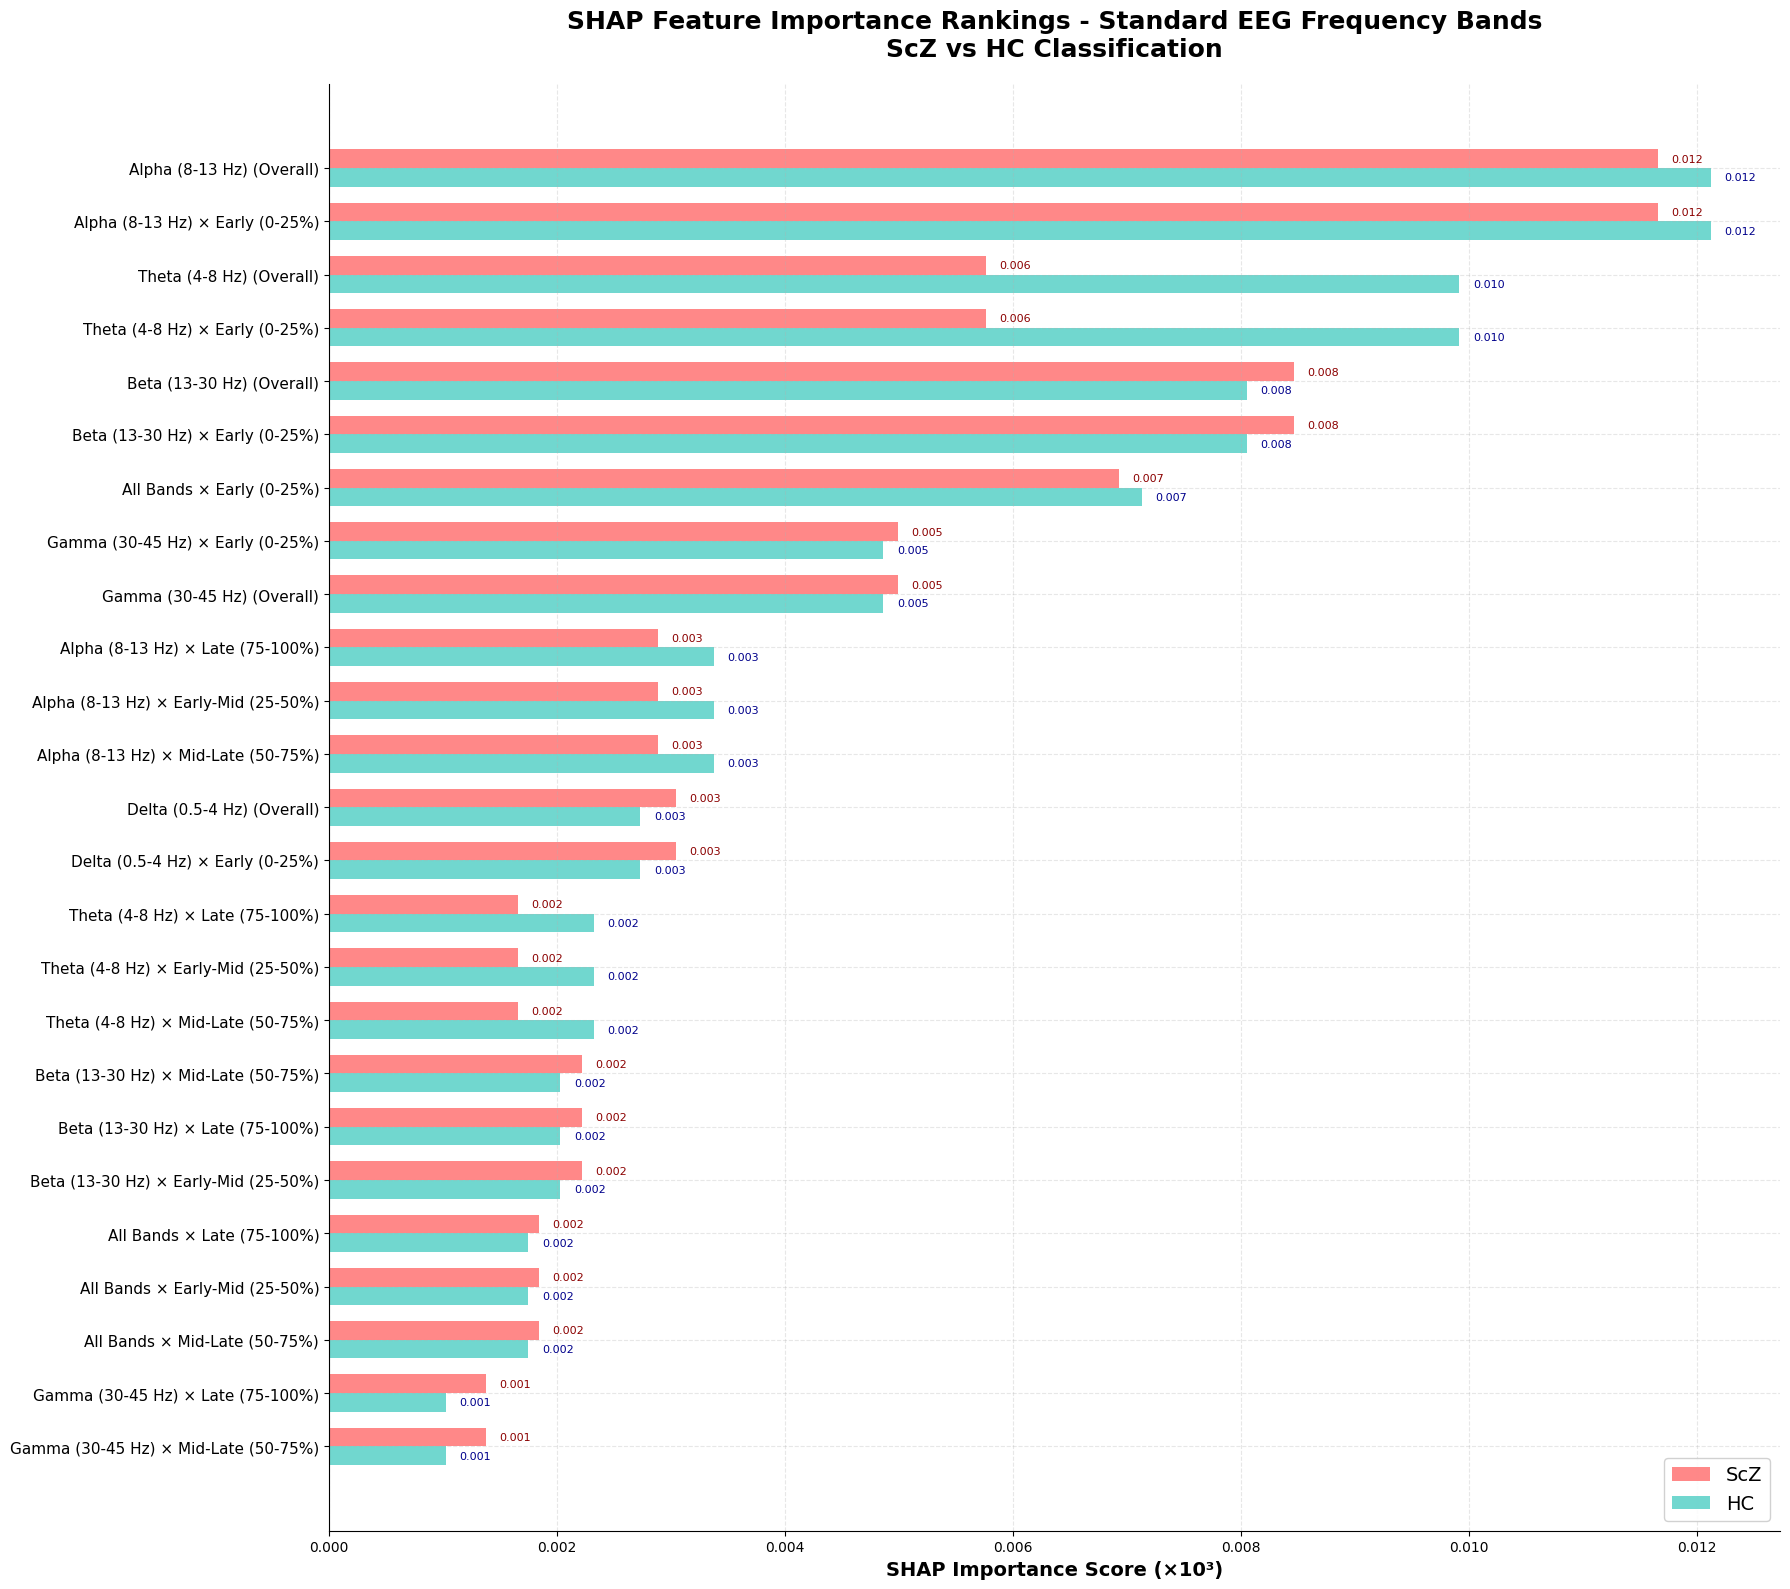

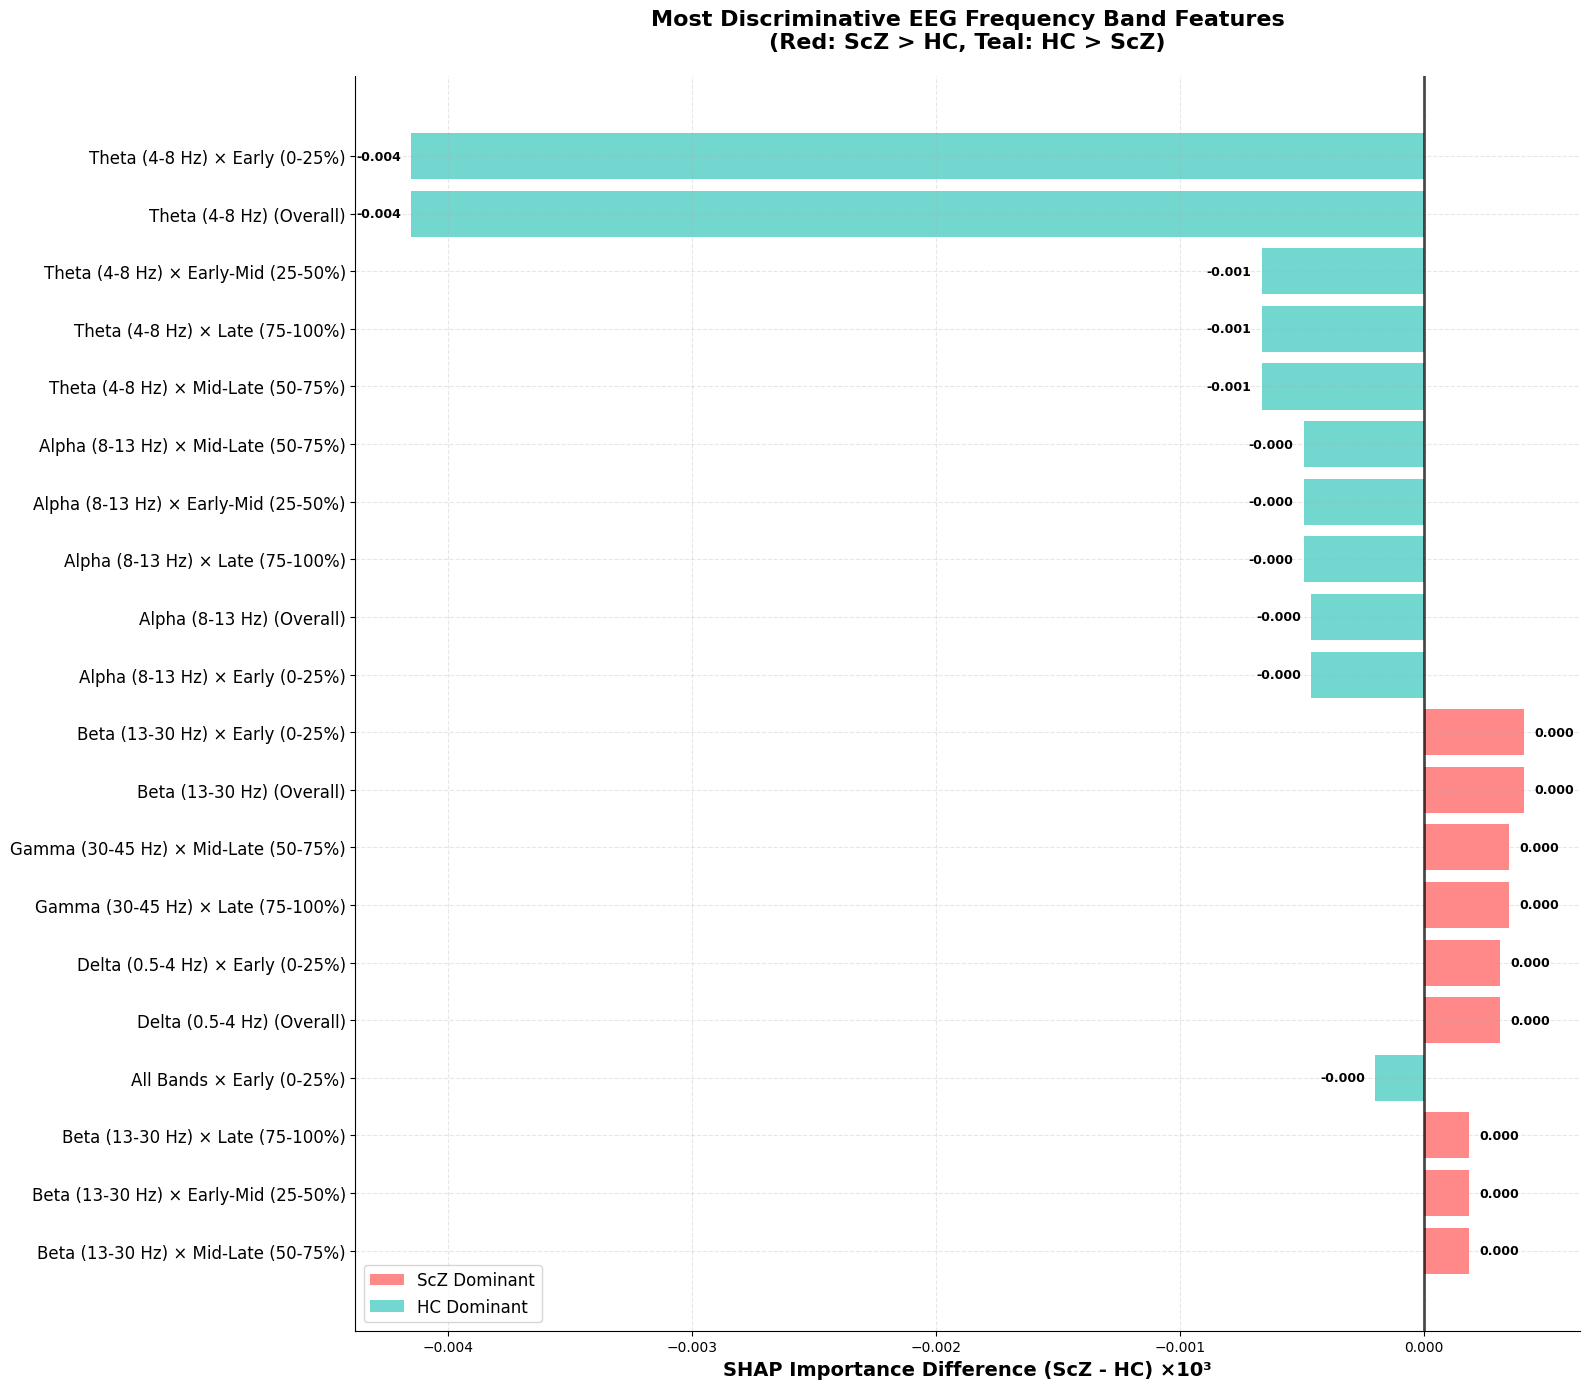

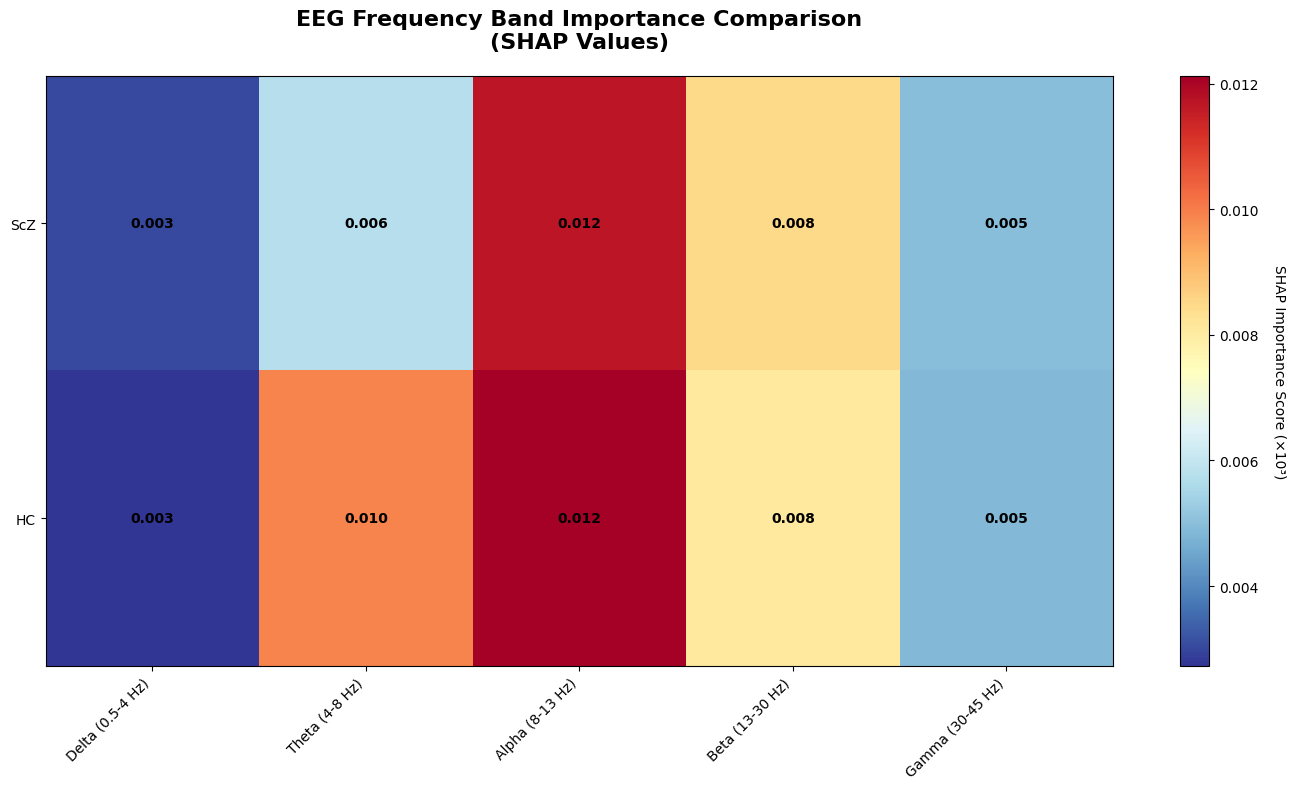


SHAP FEATURE IMPORTANCE RANKINGS FOR STANDARD EEG FREQUENCY BANDS

OVERALL FREQUENCY BAND RANKINGS:
--------------------------------------------------------------------------------

ScZ Classification - Frequency Band Importance:
 1. Alpha (8-13 Hz) (Overall)      :   0.0117
 2. Beta (13-30 Hz) (Overall)      :   0.0085
 3. Theta (4-8 Hz) (Overall)       :   0.0058
 4. Gamma (30-45 Hz) (Overall)     :   0.0050
 5. Delta (0.5-4 Hz) (Overall)     :   0.0030

HC Classification - Frequency Band Importance:
 1. Alpha (8-13 Hz) (Overall)      :   0.0121
 2. Theta (4-8 Hz) (Overall)       :   0.0099
 3. Beta (13-30 Hz) (Overall)      :   0.0080
 4. Gamma (30-45 Hz) (Overall)     :   0.0049
 5. Delta (0.5-4 Hz) (Overall)     :   0.0027

TOP 15 TIME-FREQUENCY COMBINATIONS:
--------------------------------------------------------------------------------

Rank | Feature | ScZ Score | HC Score | Difference
--------------------------------------------------------------------------------
   1 | Alp

In [ ]:
# SHAP FEATURE RANKING PLOT FOR STANDARD EEG FREQUENCY BANDS

def create_eeg_frequency_bands_ranking_plot():
    """Create comprehensive feature ranking plot for standard EEG frequency bands"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    # Handle 3D arrays
    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define standard EEG frequency bands
    # Assuming sampling rate allows frequency range 0-45 Hz over 224 frequency bins
    freq_bands = {
        'Delta (0.5-4 Hz)': (int(224*0.5/45), int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha (8-13 Hz)': (int(224*8/45), int(224*13/45)),
        'Beta (13-30 Hz)': (int(224*13/45), int(224*30/45)),
        'Gamma (30-45 Hz)': (int(224*30/45), 224)
    }

    # Define time segments for detailed analysis
    time_segments = {
        'Early (0-25%)': (0, 56),
        'Early-Mid (25-50%)': (56, 112),
        'Mid-Late (50-75%)': (112, 168),
        'Late (75-100%)': (168, 224)
    }

    # Calculate features
    feature_importance_scz = {}
    feature_importance_hc = {}

    def safe_bounds(start, end, max_val):
        start = max(0, min(start, max_val-1))
        end = max(start+1, min(end, max_val))
        return start, end

    # Frequency-Time combinations
    for band_name, (sf, ef) in freq_bands.items():
        for seg_name, (st, et) in time_segments.items():
            sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
            st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])

            feature_name = f"{band_name} × {seg_name}"
            feature_importance_scz[feature_name] = np.mean(mean_shap_scz_2d[sf:ef, st:et])
            feature_importance_hc[feature_name] = np.mean(mean_shap_hc_2d[sf:ef, st:et])

    # Overall frequency bands
    for band_name, (sf, ef) in freq_bands.items():
        sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
        feature_importance_scz[f"{band_name} (Overall)"] = np.mean(mean_shap_scz_2d[sf:ef, :])
        feature_importance_hc[f"{band_name} (Overall)"] = np.mean(mean_shap_hc_2d[sf:ef, :])

    # Overall time segments
    for seg_name, (st, et) in time_segments.items():
        st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])
        feature_importance_scz[f"All Bands × {seg_name}"] = np.mean(mean_shap_scz_2d[:, st:et])
        feature_importance_hc[f"All Bands × {seg_name}"] = np.mean(mean_shap_hc_2d[:, st:et])

    # Prepare data
    all_features = list(feature_importance_scz.keys())
    scz_values = np.array([feature_importance_scz[f] for f in all_features]) * 1000
    hc_values = np.array([feature_importance_hc[f] for f in all_features]) * 1000

    # Get all features and sort by maximum importance
    max_importance = np.maximum(scz_values, hc_values)
    sorted_idx = np.argsort(max_importance)[::-1]

    # Take top features
    top_n = min(25, len(all_features))
    final_idx = sorted_idx[:top_n]
    final_features = [all_features[i] for i in final_idx]
    final_scz = scz_values[final_idx]
    final_hc = hc_values[final_idx]

    # Plot 1: Combined horizontal bar plot
    fig, ax = plt.subplots(1, 1, figsize=(18, 16))
    y_pos = np.arange(len(final_features))

    bars1 = ax.barh(y_pos - 0.175, final_scz, 0.35, label='ScZ', color='#FF6B6B', alpha=0.8)
    bars2 = ax.barh(y_pos + 0.175, final_hc, 0.35, label='HC', color='#4ECDC4', alpha=0.8)

    # Add value labels on bars
    for i, (scz_val, hc_val) in enumerate(zip(final_scz, final_hc)):
        ax.text(scz_val + max(final_scz) * 0.01, i - 0.175, f'{scz_val:.3f}',
                va='center', ha='left', fontsize=8, color='darkred')
        ax.text(hc_val + max(final_hc) * 0.01, i + 0.175, f'{hc_val:.3f}',
                va='center', ha='left', fontsize=8, color='darkblue')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=11)
    ax.set_xlabel('SHAP Importance Score (×10³)', fontsize=14, fontweight='bold')
    ax.set_title('SHAP Feature Importance Rankings - Standard EEG Frequency Bands\nScZ vs HC Classification',
                 fontsize=18, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=14, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Plot 2: Discriminative features (difference plot)
    fig2, ax2 = plt.subplots(1, 1, figsize=(16, 14))
    differences = final_scz - final_hc
    diff_idx = np.argsort(np.abs(differences))[::-1][:20]

    disc_features = [final_features[i] for i in diff_idx]
    disc_diff = differences[diff_idx]
    bar_colors = ['#FF6B6B' if d > 0 else '#4ECDC4' for d in disc_diff]

    y_pos = np.arange(len(disc_features))
    bars = ax2.barh(y_pos, disc_diff, color=bar_colors, alpha=0.8)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, disc_diff)):
        x_pos = val + (0.01 if val >= 0 else -0.01) * max(np.abs(disc_diff))
        ha = 'left' if val >= 0 else 'right'
        ax2.text(x_pos, i, f'{val:.3f}', va='center', ha=ha, fontsize=9, fontweight='bold')

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=12)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC) ×10³', fontsize=14, fontweight='bold')
    ax2.set_title('Most Discriminative EEG Frequency Band Features\n(Red: ScZ > HC, Teal: HC > ScZ)',
                  fontsize=16, fontweight='bold', pad=20)
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.8, label='ScZ Dominant'),
                      Patch(facecolor='#4ECDC4', alpha=0.8, label='HC Dominant')]
    ax2.legend(handles=legend_elements, loc='best', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Plot 3: Frequency band comparison heatmap
    fig3, ax3 = plt.subplots(1, 1, figsize=(14, 8))

    # Extract overall band importances
    band_data_scz = []
    band_data_hc = []
    band_labels = []

    for band_name in freq_bands.keys():
        overall_key = f"{band_name} (Overall)"
        if overall_key in feature_importance_scz:
            band_data_scz.append(feature_importance_scz[overall_key] * 1000)
            band_data_hc.append(feature_importance_hc[overall_key] * 1000)
            band_labels.append(band_name)

    # Create comparison data
    comparison_data = np.array([band_data_scz, band_data_hc])

    im = ax3.imshow(comparison_data, cmap='RdYlBu_r', aspect='auto')
    ax3.set_xticks(range(len(band_labels)))
    ax3.set_xticklabels(band_labels, rotation=45, ha='right')
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(['ScZ', 'HC'])
    ax3.set_title('EEG Frequency Band Importance Comparison\n(SHAP Values)',
                  fontsize=16, fontweight='bold', pad=20)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3)
    cbar.set_label('SHAP Importance Score (×10³)', rotation=270, labelpad=20)

    # Add text annotations
    for i in range(2):
        for j in range(len(band_labels)):
            text = ax3.text(j, i, f'{comparison_data[i, j]:.3f}',
                           ha="center", va="center", color="black", fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\n" + "="*100)
    print("SHAP FEATURE IMPORTANCE RANKINGS FOR STANDARD EEG FREQUENCY BANDS")
    print("="*100)

    # Overall frequency bands ranking
    print(f"\nOVERALL FREQUENCY BAND RANKINGS:")
    print("-" * 80)

    overall_features_scz = [(k, v*1000) for k, v in feature_importance_scz.items() if "(Overall)" in k]
    overall_features_hc = [(k, v*1000) for k, v in feature_importance_hc.items() if "(Overall)" in k]

    overall_features_scz.sort(key=lambda x: x[1], reverse=True)
    overall_features_hc.sort(key=lambda x: x[1], reverse=True)

    print(f"\nScZ Classification - Frequency Band Importance:")
    for i, (feature, importance) in enumerate(overall_features_scz):
        print(f"{i+1:2d}. {feature:<30} : {importance:8.4f}")

    print(f"\nHC Classification - Frequency Band Importance:")
    for i, (feature, importance) in enumerate(overall_features_hc):
        print(f"{i+1:2d}. {feature:<30} : {importance:8.4f}")

    # Top time-frequency combinations
    print(f"\nTOP 15 TIME-FREQUENCY COMBINATIONS:")
    print("-" * 80)

    all_sorted_idx = np.argsort(np.maximum(scz_values, hc_values))[::-1]

    print(f"\nRank | Feature | ScZ Score | HC Score | Difference")
    print("-" * 80)
    for i in range(min(15, len(all_features))):
        idx = all_sorted_idx[i]
        feature = all_features[idx]
        scz_score = scz_values[idx]
        hc_score = hc_values[idx]
        diff = scz_score - hc_score
        print(f"{i+1:4d} | {feature:<40} | {scz_score:8.4f} | {hc_score:8.4f} | {diff:8.4f}")

    print(f"\nSUMMARY STATISTICS:")
    print("-" * 40)
    print(f"Total features analyzed: {len(all_features)}")
    print(f"ScZ SHAP range: {scz_values.min():.6f} to {scz_values.max():.6f}")
    print(f"HC SHAP range: {hc_values.min():.6f} to {hc_values.max():.6f}")

    # Find most discriminative bands
    band_discrimination = {}
    for band_name in freq_bands.keys():
        overall_key = f"{band_name} (Overall)"
        if overall_key in feature_importance_scz:
            scz_imp = feature_importance_scz[overall_key] * 1000
            hc_imp = feature_importance_hc[overall_key] * 1000
            band_discrimination[band_name] = abs(scz_imp - hc_imp)

    most_discriminative = sorted(band_discrimination.items(), key=lambda x: x[1], reverse=True)

    print(f"\nMOST DISCRIMINATIVE FREQUENCY BANDS:")
    print("-" * 50)
    for i, (band, discrimination) in enumerate(most_discriminative):
        print(f"{i+1}. {band:<20} : {discrimination:.4f}")

    return feature_importance_scz, feature_importance_hc

# Generate the EEG frequency bands ranking plot
print("="*80)
print("GENERATING SHAP FEATURE RANKING FOR EEG FREQUENCY BANDS ONLY")
print("="*80)

scz_rankings, hc_rankings = create_eeg_frequency_bands_ranking_plot()
print(f"\nEEG frequency bands SHAP analysis completed successfully!")
print("="*80)

GENERATING SHAP FEATURE RANKING VISUALIZATION FOR STANDARD EEG FREQUENCY BANDS


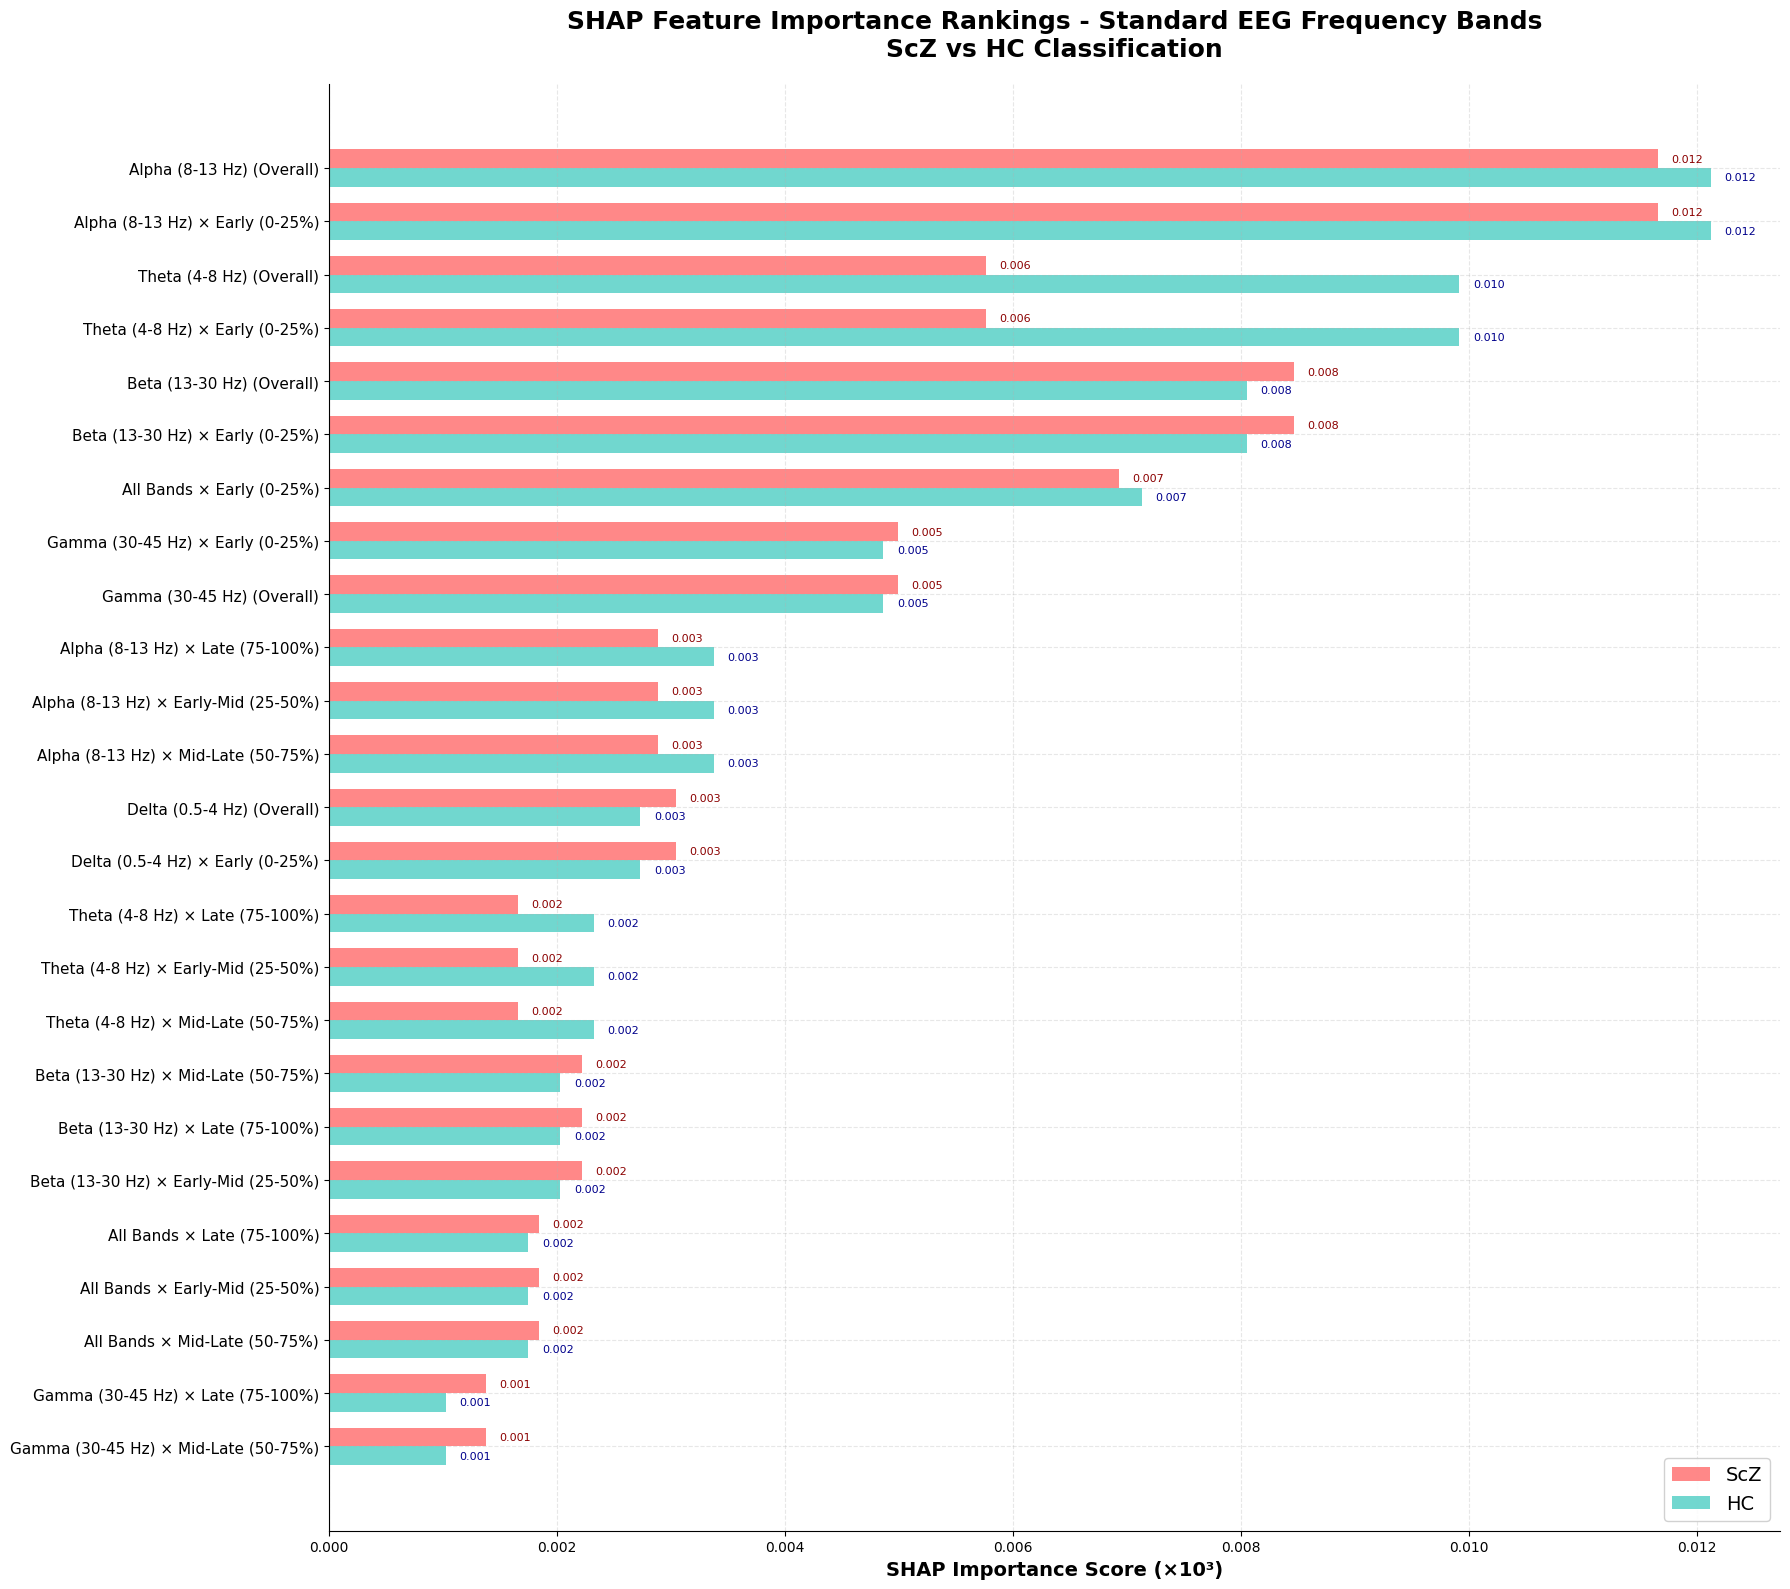

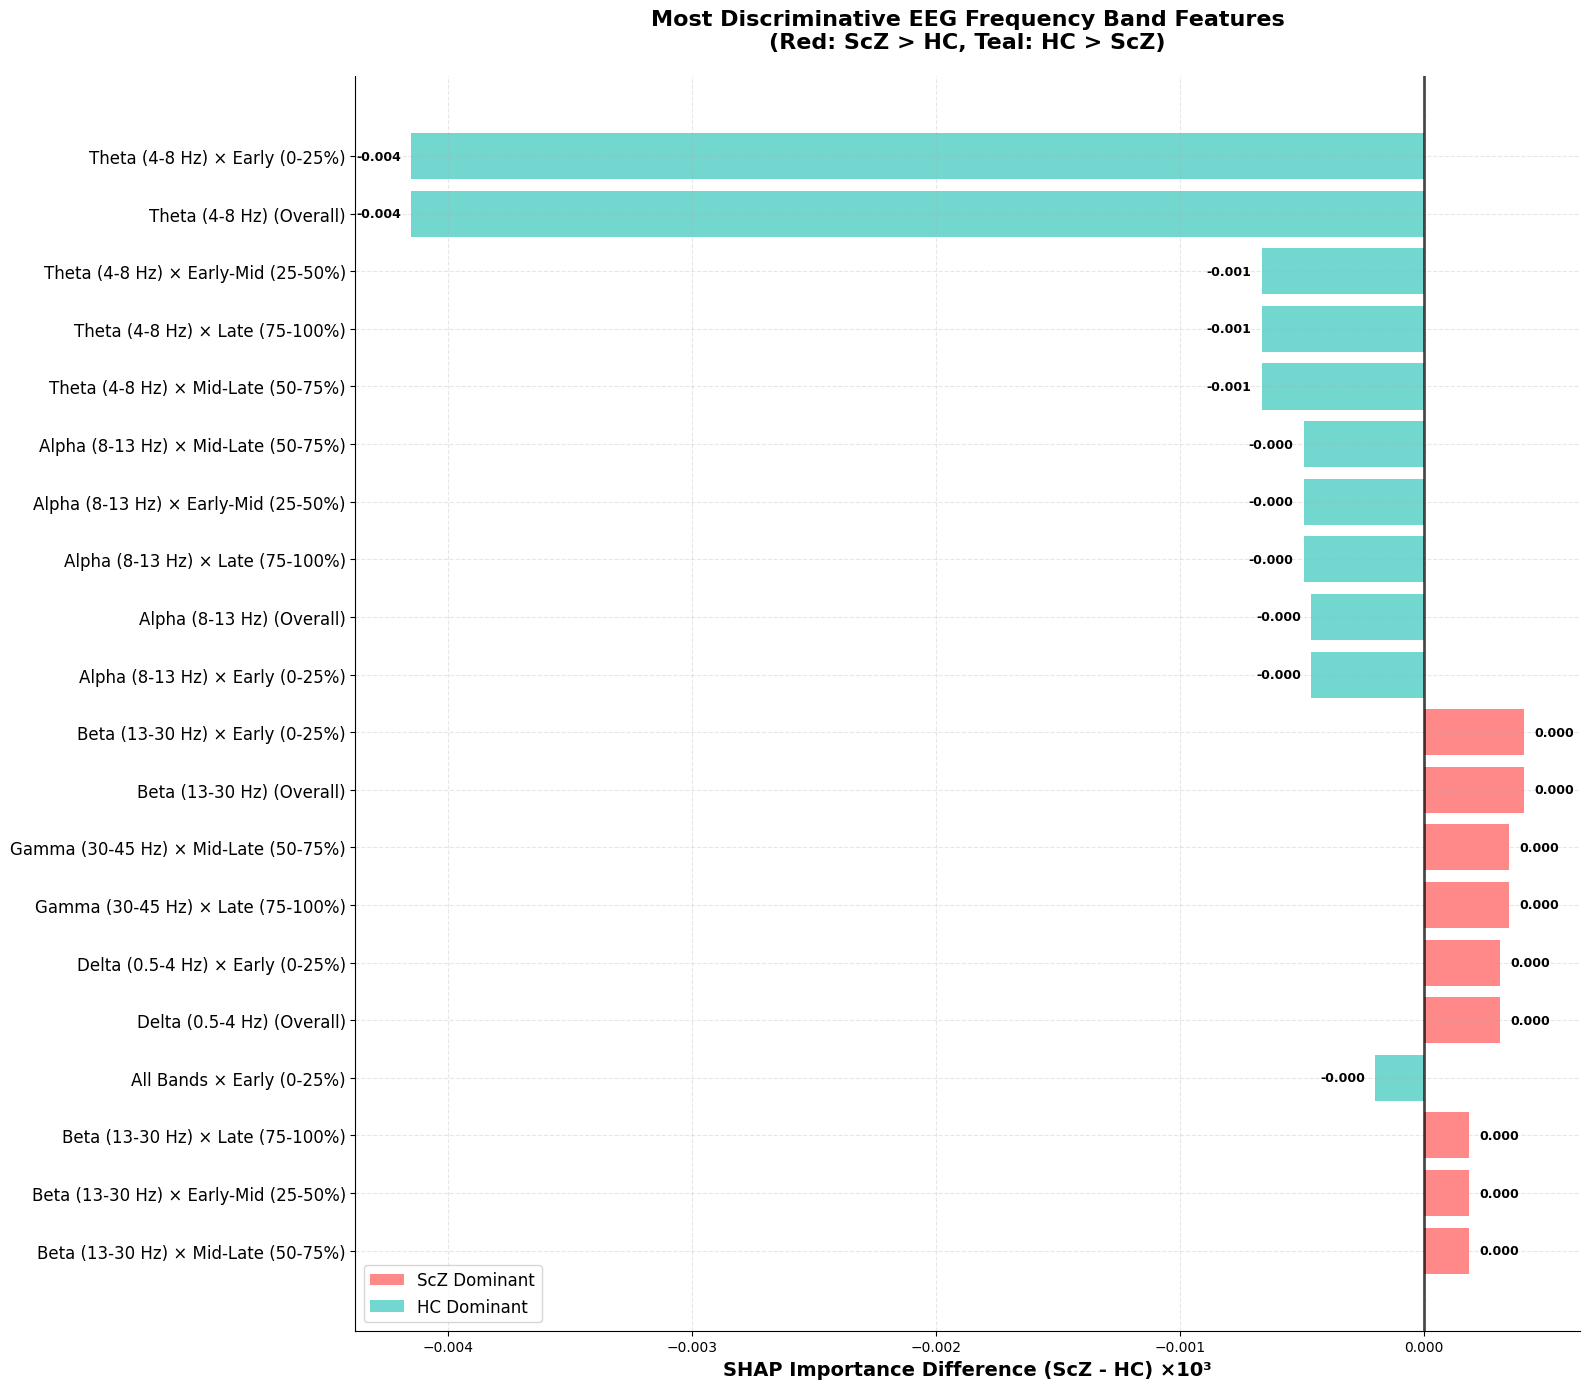

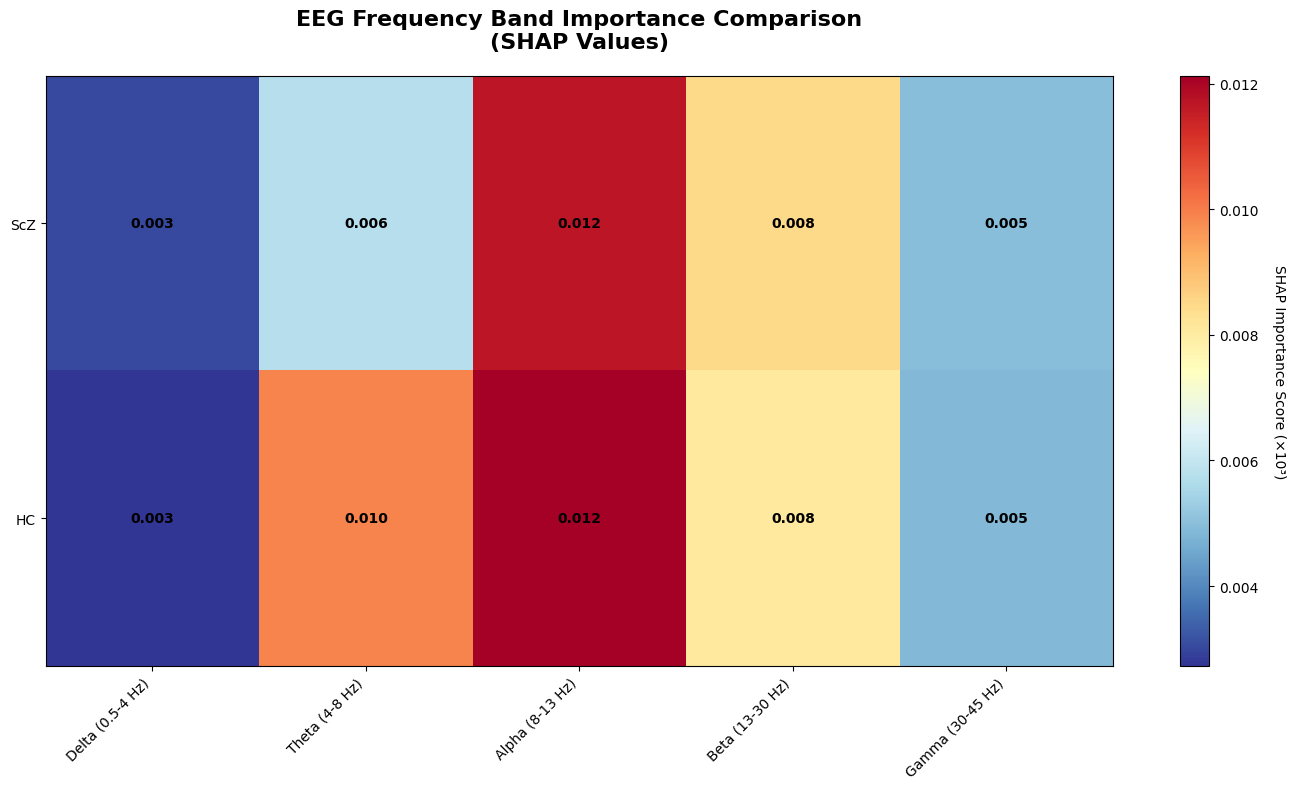


SHAP FEATURE IMPORTANCE RANKINGS FOR STANDARD EEG FREQUENCY BANDS

OVERALL FREQUENCY BAND RANKINGS:
--------------------------------------------------------------------------------

ScZ Classification - Frequency Band Importance:
 1. Alpha (8-13 Hz) (Overall)      :   0.0117
 2. Beta (13-30 Hz) (Overall)      :   0.0085
 3. Theta (4-8 Hz) (Overall)       :   0.0058
 4. Gamma (30-45 Hz) (Overall)     :   0.0050
 5. Delta (0.5-4 Hz) (Overall)     :   0.0030

HC Classification - Frequency Band Importance:
 1. Alpha (8-13 Hz) (Overall)      :   0.0121
 2. Theta (4-8 Hz) (Overall)       :   0.0099
 3. Beta (13-30 Hz) (Overall)      :   0.0080
 4. Gamma (30-45 Hz) (Overall)     :   0.0049
 5. Delta (0.5-4 Hz) (Overall)     :   0.0027

TOP 15 TIME-FREQUENCY COMBINATIONS:
--------------------------------------------------------------------------------

Rank | Feature | ScZ Score | HC Score | Difference
--------------------------------------------------------------------------------
   1 | Alp

In [ ]:
# SHAP FEATURE RANKING PLOT FOR STANDARD EEG FREQUENCY BANDS

def create_eeg_frequency_bands_ranking_plot():
    """Create comprehensive feature ranking plot for standard EEG frequency bands"""

    # Get SHAP values
    mean_shap_scz = np.mean(np.abs(combined_shap_values[0]), axis=0)
    mean_shap_hc = np.mean(np.abs(combined_shap_values[1]), axis=0)

    # Handle 3D arrays
    if len(mean_shap_scz.shape) == 3:
        mean_shap_scz_2d = np.mean(mean_shap_scz, axis=2)
        mean_shap_hc_2d = np.mean(mean_shap_hc, axis=2)
    else:
        mean_shap_scz_2d = mean_shap_scz
        mean_shap_hc_2d = mean_shap_hc

    # Define standard EEG frequency bands
    # Assuming sampling rate allows frequency range 0-45 Hz over 224 frequency bins
    freq_bands = {
        'Delta (0.5-4 Hz)': (int(224*0.5/45), int(224*4/45)),
        'Theta (4-8 Hz)': (int(224*4/45), int(224*8/45)),
        'Alpha (8-13 Hz)': (int(224*8/45), int(224*13/45)),
        'Beta (13-30 Hz)': (int(224*13/45), int(224*30/45)),
        'Gamma (30-45 Hz)': (int(224*30/45), 224)
    }

    # Define time segments for detailed analysis
    time_segments = {
        'Early (0-25%)': (0, 56),
        'Early-Mid (25-50%)': (56, 112),
        'Mid-Late (50-75%)': (112, 168),
        'Late (75-100%)': (168, 224)
    }

    # Calculate features
    feature_importance_scz = {}
    feature_importance_hc = {}

    def safe_bounds(start, end, max_val):
        start = max(0, min(start, max_val-1))
        end = max(start+1, min(end, max_val))
        return start, end

    # Frequency-Time combinations
    for band_name, (sf, ef) in freq_bands.items():
        for seg_name, (st, et) in time_segments.items():
            sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
            st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])

            feature_name = f"{band_name} × {seg_name}"
            feature_importance_scz[feature_name] = np.mean(mean_shap_scz_2d[sf:ef, st:et])
            feature_importance_hc[feature_name] = np.mean(mean_shap_hc_2d[sf:ef, st:et])

    # Overall frequency bands
    for band_name, (sf, ef) in freq_bands.items():
        sf, ef = safe_bounds(sf, ef, mean_shap_scz_2d.shape[0])
        feature_importance_scz[f"{band_name} (Overall)"] = np.mean(mean_shap_scz_2d[sf:ef, :])
        feature_importance_hc[f"{band_name} (Overall)"] = np.mean(mean_shap_hc_2d[sf:ef, :])

    # Overall time segments
    for seg_name, (st, et) in time_segments.items():
        st, et = safe_bounds(st, et, mean_shap_scz_2d.shape[1])
        feature_importance_scz[f"All Bands × {seg_name}"] = np.mean(mean_shap_scz_2d[:, st:et])
        feature_importance_hc[f"All Bands × {seg_name}"] = np.mean(mean_shap_hc_2d[:, st:et])

    # Prepare data
    all_features = list(feature_importance_scz.keys())
    scz_values = np.array([feature_importance_scz[f] for f in all_features]) * 1000
    hc_values = np.array([feature_importance_hc[f] for f in all_features]) * 1000

    # Get all features and sort by maximum importance
    max_importance = np.maximum(scz_values, hc_values)
    sorted_idx = np.argsort(max_importance)[::-1]

    # Take top features
    top_n = min(25, len(all_features))
    final_idx = sorted_idx[:top_n]
    final_features = [all_features[i] for i in final_idx]
    final_scz = scz_values[final_idx]
    final_hc = hc_values[final_idx]

    # Plot 1: Combined horizontal bar plot
    fig, ax = plt.subplots(1, 1, figsize=(18, 16))
    y_pos = np.arange(len(final_features))

    bars1 = ax.barh(y_pos - 0.175, final_scz, 0.35, label='ScZ', color='#FF6B6B', alpha=0.8)
    bars2 = ax.barh(y_pos + 0.175, final_hc, 0.35, label='HC', color='#4ECDC4', alpha=0.8)

    # Add value labels on bars
    for i, (scz_val, hc_val) in enumerate(zip(final_scz, final_hc)):
        ax.text(scz_val + max(final_scz) * 0.01, i - 0.175, f'{scz_val:.3f}',
                va='center', ha='left', fontsize=8, color='darkred')
        ax.text(hc_val + max(final_hc) * 0.01, i + 0.175, f'{hc_val:.3f}',
                va='center', ha='left', fontsize=8, color='darkblue')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(final_features, fontsize=11)
    ax.set_xlabel('SHAP Importance Score (×10³)', fontsize=14, fontweight='bold')
    ax.set_title('SHAP Feature Importance Rankings - Standard EEG Frequency Bands\nScZ vs HC Classification',
                 fontsize=18, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.legend(loc='lower right', fontsize=14, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Plot 2: Discriminative features (difference plot)
    fig2, ax2 = plt.subplots(1, 1, figsize=(16, 14))
    differences = final_scz - final_hc
    diff_idx = np.argsort(np.abs(differences))[::-1][:20]

    disc_features = [final_features[i] for i in diff_idx]
    disc_diff = differences[diff_idx]
    bar_colors = ['#FF6B6B' if d > 0 else '#4ECDC4' for d in disc_diff]

    y_pos = np.arange(len(disc_features))
    bars = ax2.barh(y_pos, disc_diff, color=bar_colors, alpha=0.8)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, disc_diff)):
        x_pos = val + (0.01 if val >= 0 else -0.01) * max(np.abs(disc_diff))
        ha = 'left' if val >= 0 else 'right'
        ax2.text(x_pos, i, f'{val:.3f}', va='center', ha=ha, fontsize=9, fontweight='bold')

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(disc_features, fontsize=12)
    ax2.set_xlabel('SHAP Importance Difference (ScZ - HC) ×10³', fontsize=14, fontweight='bold')
    ax2.set_title('Most Discriminative EEG Frequency Band Features\n(Red: ScZ > HC, Teal: HC > ScZ)',
                  fontsize=16, fontweight='bold', pad=20)
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.8, label='ScZ Dominant'),
                      Patch(facecolor='#4ECDC4', alpha=0.8, label='HC Dominant')]
    ax2.legend(handles=legend_elements, loc='best', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Plot 3: Frequency band comparison heatmap
    fig3, ax3 = plt.subplots(1, 1, figsize=(14, 8))

    # Extract overall band importances
    band_data_scz = []
    band_data_hc = []
    band_labels = []

    for band_name in freq_bands.keys():
        overall_key = f"{band_name} (Overall)"
        if overall_key in feature_importance_scz:
            band_data_scz.append(feature_importance_scz[overall_key] * 1000)
            band_data_hc.append(feature_importance_hc[overall_key] * 1000)
            band_labels.append(band_name)

    # Create comparison data
    comparison_data = np.array([band_data_scz, band_data_hc])

    im = ax3.imshow(comparison_data, cmap='RdYlBu_r', aspect='auto')
    ax3.set_xticks(range(len(band_labels)))
    ax3.set_xticklabels(band_labels, rotation=45, ha='right')
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(['ScZ', 'HC'])
    ax3.set_title('EEG Frequency Band Importance Comparison\n(SHAP Values)',
                  fontsize=16, fontweight='bold', pad=20)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3)
    cbar.set_label('SHAP Importance Score (×10³)', rotation=270, labelpad=20)

    # Add text annotations
    for i in range(2):
        for j in range(len(band_labels)):
            text = ax3.text(j, i, f'{comparison_data[i, j]:.3f}',
                           ha="center", va="center", color="black", fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\n" + "="*100)
    print("SHAP FEATURE IMPORTANCE RANKINGS FOR STANDARD EEG FREQUENCY BANDS")
    print("="*100)

    # Overall frequency bands ranking
    print(f"\nOVERALL FREQUENCY BAND RANKINGS:")
    print("-" * 80)

    overall_features_scz = [(k, v*1000) for k, v in feature_importance_scz.items() if "(Overall)" in k]
    overall_features_hc = [(k, v*1000) for k, v in feature_importance_hc.items() if "(Overall)" in k]

    overall_features_scz.sort(key=lambda x: x[1], reverse=True)
    overall_features_hc.sort(key=lambda x: x[1], reverse=True)

    print(f"\nScZ Classification - Frequency Band Importance:")
    for i, (feature, importance) in enumerate(overall_features_scz):
        print(f"{i+1:2d}. {feature:<30} : {importance:8.4f}")

    print(f"\nHC Classification - Frequency Band Importance:")
    for i, (feature, importance) in enumerate(overall_features_hc):
        print(f"{i+1:2d}. {feature:<30} : {importance:8.4f}")

    # Top time-frequency combinations
    print(f"\nTOP 15 TIME-FREQUENCY COMBINATIONS:")
    print("-" * 80)

    all_sorted_idx = np.argsort(np.maximum(scz_values, hc_values))[::-1]

    print(f"\nRank | Feature | ScZ Score | HC Score | Difference")
    print("-" * 80)
    for i in range(min(15, len(all_features))):
        idx = all_sorted_idx[i]
        feature = all_features[idx]
        scz_score = scz_values[idx]
        hc_score = hc_values[idx]
        diff = scz_score - hc_score
        print(f"{i+1:4d} | {feature:<40} | {scz_score:8.4f} | {hc_score:8.4f} | {diff:8.4f}")

    print(f"\nSUMMARY STATISTICS:")
    print("-" * 40)
    print(f"Total features analyzed: {len(all_features)}")
    print(f"ScZ SHAP range: {scz_values.min():.6f} to {scz_values.max():.6f}")
    print(f"HC SHAP range: {hc_values.min():.6f} to {hc_values.max():.6f}")

    # Find most discriminative bands
    band_discrimination = {}
    for band_name in freq_bands.keys():
        overall_key = f"{band_name} (Overall)"
        if overall_key in feature_importance_scz:
            scz_imp = feature_importance_scz[overall_key] * 1000
            hc_imp = feature_importance_hc[overall_key] * 1000
            band_discrimination[band_name] = abs(scz_imp - hc_imp)

    most_discriminative = sorted(band_discrimination.items(), key=lambda x: x[1], reverse=True)

    print(f"\nMOST DISCRIMINATIVE FREQUENCY BANDS:")
    print("-" * 50)
    for i, (band, discrimination) in enumerate(most_discriminative):
        print(f"{i+1}. {band:<20} : {discrimination:.4f}")

    return feature_importance_scz, feature_importance_hc

# Generate the EEG frequency bands ranking plot
print("="*100)
print("GENERATING SHAP FEATURE RANKING VISUALIZATION FOR STANDARD EEG FREQUENCY BANDS")
print("="*100)

scz_rankings, hc_rankings = create_eeg_frequency_bands_ranking_plot()
print(f"\nEEG frequency bands ranking plot generated successfully!")
print("="*100)